### VantagePoint Analytics - Employer 
NOTE: this notebook uses 3.13.5 pyhton version 

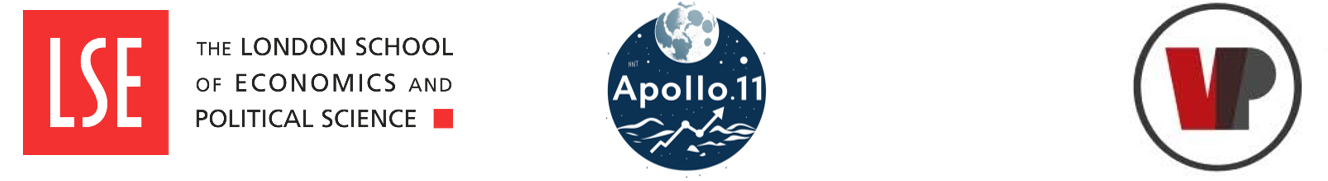

# **Predicting Stock Price Movements Around Earnings for NVIDIA, Apple & Google in the Era of AI & Trade Tensions**

#### _Exploring Root Causes for Rapid Movement in Stock Prices Around Earnings Dates & Delivering Data-Driven Solutions Through Advanced ML Modeling & Analytics_

# + ADDITIONAL NOTEBOOK: **Neighboring Companies - Clustering & Peer Selection**

## Neighboring Companies Selection: Intro & Rationale
Identifying “Apple-like” (stable compounding), “Nvidia-like” (high-beta, explosive), and “Google-like” (balanced, broad) companies to use for training a prediction model, using **behavioral similarity** rather than labels. Each NASDAQ-100 name name is evaluated across three complementary feature families:
* **Momentum (Position & Trend)** — where price sits now within a short-term band and how much directional progress has accumulated over recent windows.*Examples: RSI, Bollinger position, 20/63-day momentum, 20-day Sharpe, MACD.*

* **Volatility / Risk** — how large and asymmetric price moves typically are, how tightly the stock co-moves with the market versus its own idiosyncratic behavior, and how far it sits from recent peaks. *Examples: 5/20-day realized volatility, downside (semi)volatility, drawdown (60-day), beta to S&P (60-day), idiosyncratic volatility, plus single-day movement descriptors such as intraday range % and overnight gap return.*

* **Liquidity / Participation** — how unusual current trading activity is relative to the stock’s own history, as a proxy for attention and participation intensity. *Example: volume z-score (60-day).*

In [43]:
# import libraries

from typing import List

import numpy as np, pandas as pd, matplotlib.pyplot as plt, textwrap
import yfinance as yf
# Tech indicators
from ta.momentum import RSIIndicator
from ta.trend import MACD
from typing import Optional, List, Iterable
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings(
    "ignore",
    message="Could not find the number of physical cores",
    category=UserWarning,
    module="joblib"
)
import networkx as nx

In [22]:
# ===== Utilities =====
# Standardize a 'date' column so downstream merges/joins are reliable:
# - parse to datetime (coerce bad values to NaT)
# - strip any timezone info (tz-naive)
# - normalize to midnight (remove intra-day time component)
def _normalize_date(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure tz-free, midnight-normalized datetime64[ns] 'date' column."""
    out = df.copy()
    out["date"] = pd.to_datetime(out["date"], errors="coerce", utc=False)
    if getattr(out["date"].dt, "tz", None) is not None:
        out["date"] = out["date"].dt.tz_localize(None)
    out["date"] = out["date"].dt.normalize()
    return out

# Clamp a frame to a closed date interval [start, end] using the 'date' column.
# Dates are normalized first to avoid off-by-one due to time components.
def _slice_window(df: pd.DataFrame, start: Optional[str], end: Optional[str]) -> pd.DataFrame:
    """Clamp rows to [start, end] (inclusive) on the 'date' column."""
    if df.empty:
        return df
    out = _normalize_date(df)
    lo = pd.to_datetime(start).normalize() if start else None
    hi = pd.to_datetime(end).normalize()   if end   else None
    if lo is not None:
        out = out[out["date"] >= lo]
    if hi is not None:
        out = out[out["date"] <= hi]
    return out

# If yfinance returns MultiIndex columns (e.g., ('Adj Close','AAPL')),
# collapse to a single level by taking the first element of each tuple.
def _flatten_if_multiindex(df: pd.DataFrame) -> pd.DataFrame:
    """Flatten any MultiIndex columns to a single level using the first element."""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    return df


# ===== Downloaders =====
def _download_prices(
    ticker: str,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    auto_adjust: bool = False,
    columns: Optional[List[str]] = None,
) -> pd.DataFrame:
    """
    Clean OHLCV downloader. Returns columns: date + requested fields (lower_snake_case).
    """
    data = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        progress=False,
        auto_adjust=auto_adjust,
        group_by="column",
    )
    if data.empty:
        return pd.DataFrame()

    data.index = pd.to_datetime(data.index).tz_localize(None)
    data.index.name = "date"

    df = data.copy()
    df = _flatten_if_multiindex(df).reset_index()
    df.columns = [str(c).lower().replace(" ", "_") for c in df.columns]

    if columns is not None:
        want = [c.lower().replace(" ", "_") for c in columns]
        missing = [c for c in want if c not in df.columns]
        if missing:
            raise ValueError(
                f"Missing columns from yfinance for {ticker}: {missing}. "
                f"Available: {df.columns.tolist()}"
            )
        df = df[["date"] + want]

    return _normalize_date(df)

# Fetch Adj Close with a prebuffer to support rolling/warmups; normalize names and dates.
def _adj_close_with_buffer(
    ticker: str,
    start_date: Optional[str],
    end_date: Optional[str],
    buffer_days: int = 90,
) -> pd.DataFrame:
    """
    Fetch Adj Close with a prebuffer (for return/rolling warmup).
    Returns: date, adj_close (normalized). No slicing here.
    """
    start_ts = pd.to_datetime(start_date) if start_date else None
    end_ts   = pd.to_datetime(end_date)   if end_date   else None
    fetch_start = (start_ts - pd.Timedelta(days=buffer_days)).date().isoformat() if start_ts is not None else None

    data = yf.download(
        ticker,
        start=fetch_start,
        end=end_ts,
        progress=False,
        auto_adjust=False,
        group_by="column",
    )
    if data.empty:
        return pd.DataFrame(columns=["date", "adj_close"])

    data.index = pd.to_datetime(data.index).tz_localize(None)
    data.index.name = "date"

    df = data.reset_index()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns = [str(c).lower().replace(" ", "_") for c in df.columns]
    if "adj_close" not in df.columns and "adjclose" in df.columns:
        df = df.rename(columns={"adjclose": "adj_close"})
    if "adj_close" not in df.columns and "close" in df.columns:
        df = df.rename(columns={"close": "adj_close"})
    if "adj_close" not in df.columns:
        raise KeyError(f"Adj Close not found for {ticker}. Columns: {df.columns.tolist()}")

    return _normalize_date(df[["date", "adj_close"]])

# From 'adj_close', compute simple 1d and 5d returns; preserve empty inputs gracefully.
def _compute_returns_from_adj(adj_df: pd.DataFrame) -> pd.DataFrame:
    """Add simple 1d & 5d returns from adj_close."""
    if adj_df.empty:
        return adj_df.assign(ret_1d=pd.Series(dtype=float), ret_5d=pd.Series(dtype=float))
    out = adj_df.copy()
    out["ret_1d"] = out["adj_close"].pct_change(1)
    out["ret_5d"] = out["adj_close"].pct_change(5)
    return out


# ===== Metrics builders =====
# Build OHLCV + RSI/MACD/daily % change on prebuffered data, then hard-slice to the requested window.
def compute_core_metrics(
    ticker: str,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    prebuffer_days: int = 90,
    drop_indicator_warmup: bool = False,
) -> pd.DataFrame:
    """
    OHLCV + RSI + MACD + daily_pct_change.
    Compute on prebuffered data, then slice to [start_date, end_date].
    """
    start_ts = pd.to_datetime(start_date) if start_date else None
    fetch_start = (start_ts - pd.Timedelta(days=prebuffer_days)).date().isoformat() if start_ts is not None else None

    df = _download_prices(
        ticker,
        start_date=fetch_start,
        end_date=end_date,
        auto_adjust=False,
        columns=["Open", "High", "Low", "Close", "Volume"],
    )
    if df.empty:
        return df

    close = df["close"].astype(float)
    df["earnings_surprise"] = 0.0
    df["sentiment_score"]   = 0.0
    df["rsi"]               = RSIIndicator(close=close).rsi()
    df["macd"]              = MACD(close=close).macd_diff()
    df["daily_pct_change"]  = close.pct_change() * 100

    # Slice AFTER compute; keep warmup rows unless user opts to drop them
    df = _slice_window(df, start_date, end_date)
    if drop_indicator_warmup:
        df = df.dropna(subset=["rsi", "macd", "daily_pct_change"])

    # tidy dtypes
    df["volume"] = df["volume"].astype("Int64")
    for c in ["open","high","low","close","earnings_surprise","sentiment_score","rsi","macd","daily_pct_change"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df[[
        "date","open","high","low","close","volume",
        "earnings_surprise","sentiment_score","rsi","macd","daily_pct_change"
    ]].copy()

# Compute 5d return volatility and 20d Bollinger bands/position on buffered data; then clamp to [start, end].
def compute_volatility_metrics(
    ticker: str,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    prebuffer_days: int = 90,
    drop_indicator_warmup: bool = False,
) -> pd.DataFrame:
    """
    5d return volatility + Bollinger bands & position (20d).
    Compute on prebuffered data, then slice to [start_date, end_date].
    """
    full = _adj_close_with_buffer(ticker, start_date, end_date, buffer_days=prebuffer_days)
    if full.empty:
        return full

    df = full.copy()
    df["return"]                 = df["adj_close"].pct_change()
    df["return_volatility_5day"] = df["return"].rolling(window=5,  min_periods=5).std()
    sma_20 = df["adj_close"].rolling(window=20, min_periods=20).mean()
    sd_20  = df["adj_close"].rolling(window=20, min_periods=20).std()
    df["bollinger_upper"]        = sma_20 + 2 * sd_20
    df["bollinger_lower"]        = sma_20 - 2 * sd_20
    width = (df["bollinger_upper"] - df["bollinger_lower"]).replace(0, np.nan)
    df["bollinger_position"]     = (df["adj_close"] - df["bollinger_lower"]) / width

    df = _slice_window(df, start_date, end_date)
    if drop_indicator_warmup:
        df = df.dropna(subset=["return_volatility_5day","bollinger_upper","bollinger_lower","bollinger_position"])

    keep = ["date","return_volatility_5day","bollinger_upper","bollinger_lower","bollinger_position"]
    for c in keep[1:]:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df[keep].copy()

# Get benchmark (e.g., S&P) 1d/5d returns aligned to the window for later merges with per-ticker data.
def _get_sp_returns(sp_ticker: str, start: Optional[str], end: Optional[str]) -> pd.DataFrame:
    """
    Global market returns (S&P 500): sp_ret_1d, sp_ret_5d.
    Prebuffered fetch, then slice to [start, end].
    """
    full = _adj_close_with_buffer(sp_ticker, start, end, buffer_days=90)
    full = _compute_returns_from_adj(full)
    full = _slice_window(full, start, end)
    return full[["date","ret_1d","ret_5d"]].rename(columns={"ret_1d":"sp_ret_1d","ret_5d":"sp_ret_5d"})


# ===== Assembly helpers (long → wide) =====
# Add the ticker as a prefix/suffix to column names (skip any in 'exclude') for clear provenance in wide panels.
def _rename_with_ticker(
    df: pd.DataFrame,
    ticker: str,
    position: str = "suffix",
    exclude: Optional[List[str]] = None,
) -> pd.DataFrame:
    exclude = set(exclude or [])
    renamed = {}
    for col in df.columns:
        if col in exclude:
            renamed[col] = col
        else:
            renamed[col] = f"{ticker}_{col}" if position == "prefix" else f"{col}_{ticker}"
    return df.rename(columns=renamed)

# Produce a per-company tidy frame (OHLCV + indicators + returns + perf_vs_sp) with optional volatility features.
def _build_company_long_with_perf(
    ticker: str,
    sp_df: pd.DataFrame,
    start: Optional[str],
    end: Optional[str],
    include_volatility: bool = False,
    prebuffer_days: int = 90,
    drop_indicator_warmup: bool = False,
) -> pd.DataFrame:
    """
    Per-company tidy frame with OHLCV + indicators + returns + perf_vs_sp_ret_5d.
    Optionally merges volatility features.
    """
    core = compute_core_metrics(ticker, start, end, prebuffer_days=prebuffer_days,
                                drop_indicator_warmup=drop_indicator_warmup)

    # returns from Adj Close
    adj = _adj_close_with_buffer(ticker, start, end, buffer_days=prebuffer_days)
    adj = _compute_returns_from_adj(adj)[["date", "ret_1d", "ret_5d"]]
    adj = _slice_window(adj, start, end)

    # optional volatility
    if include_volatility:
        vol = compute_volatility_metrics(ticker, start, end, prebuffer_days=prebuffer_days,
                                         drop_indicator_warmup=drop_indicator_warmup)
        core = pd.merge(core, vol, on="date", how="outer")

    # normalize before merges
    core = _normalize_date(core)
    adj  = _normalize_date(adj)
    sp_df = _normalize_date(sp_df)

    df = pd.merge(core, adj, on="date", how="outer").sort_values("date")
    df = pd.merge(df, sp_df, on="date", how="left")

    if {"ret_5d", "sp_ret_5d"}.issubset(df.columns):
        df["perf_vs_sp_ret_5d"] = df["ret_5d"] - df["sp_ret_5d"]

    # final in-window clamp for safety
    df = _slice_window(df, start, end)

    keep = [
        "date", "open", "high", "low", "close", "volume",
        "rsi", "macd", "daily_pct_change",
        "ret_1d", "ret_5d", "perf_vs_sp_ret_5d",
        "sp_ret_1d", "sp_ret_5d",
    ]
    if include_volatility:
        keep += ["return_volatility_5day","bollinger_upper","bollinger_lower","bollinger_position"]

    keep = [c for c in keep if c in df.columns]
    return df[keep].copy()

# Assemble a wide panel across tickers: benchmark returns plus per-ticker columns (ticker-tagged), date-aligned.
def build_wide_panel(
    tickers: List[str],
    start: Optional[str] = None,
    end: Optional[str] = None,
    sp_ticker: str = "^GSPC",
    ticker_tag_position: str = "suffix",   # "prefix" -> AAPL_open ; "suffix" -> open_AAPL
    merge_how: str = "outer",
    include_volatility: bool = False,
) -> pd.DataFrame:
    """
    Wide panel with:
      date, sp_ret_1d, sp_ret_5d,
      per-ticker columns (e.g., open_AAPL, rsi_AAPL, ret_5d_AAPL, perf_vs_sp_ret_5d_AAPL, ...)
    """
    # base grid
    sp = _get_sp_returns(sp_ticker, start, end)
    base = _slice_window(sp.copy(), start, end)  # hard clamp

    for t in tickers:
        long_df = _build_company_long_with_perf(
            t, sp, start, end, include_volatility=include_volatility
        )
        long_df = _slice_window(long_df, start, end)  # hard clamp
        long_df = long_df.drop(columns=[c for c in ["sp_ret_1d", "sp_ret_5d"] if c in long_df.columns])
        long_df = _rename_with_ticker(long_df, ticker=t, position=ticker_tag_position, exclude=["date"])
        base = pd.merge(base, long_df, on="date", how=merge_how)

    cols = ["date", "sp_ret_1d", "sp_ret_5d"]
    other = [c for c in base.columns if c not in cols]
    base = base[cols + other].sort_values("date").reset_index(drop=True)
    return base


In [23]:
# test functions:
start, end = "2023-01-01", None

print("=== S&P ===")
sp = _get_sp_returns("^GSPC", start, end)
print(sp["date"].min(), "→", sp["date"].max(), "rows:", len(sp))
display(sp.head(3))

print("\n=== AAPL core ===")
aapl_core = compute_core_metrics("AAPL", start, end)
print(aapl_core["date"].min(), "→", aapl_core["date"].max(), "rows:", len(aapl_core))
display(aapl_core.head(3))

print("\n=== Build panel ===")
tickers = ["AAPL","NVDA","GOOGL"]
panel = build_wide_panel(tickers, start=start, end=end, include_volatility=True)
print(panel["date"].min(), "→", panel["date"].max(), "rows:", len(panel))
display(panel.head(5))

=== S&P ===
2023-01-03 00:00:00 → 2025-09-10 00:00:00 rows: 674


date  sp_ret_1d  sp_ret_5d
63 2023-01-03  -0.004001  -0.005379
64 2023-01-04   0.007539   0.006194
65 2023-01-05  -0.011646   0.006576


=== AAPL core ===
2023-01-03 00:00:00 → 2025-09-10 00:00:00 rows: 674


date        open        high         low       close     volume  \
63 2023-01-03  130.279999  130.899994  124.169998  125.070000  112117500   
64 2023-01-04  126.889999  128.660004  125.080002  126.360001   89113600   
65 2023-01-05  127.129997  127.769997  124.760002  125.019997   80962700   

    earnings_surprise  sentiment_score        rsi      macd  daily_pct_change  
63                0.0              0.0  32.289236 -0.918631         -3.740470  
64                0.0              0.0  34.865899 -0.804463          1.031423  
65                0.0              0.0  33.442271 -0.740495         -1.060465


=== Build panel ===
2023-01-03 00:00:00 → 2025-09-10 00:00:00 rows: 674


date  sp_ret_1d  sp_ret_5d   open_AAPL   high_AAPL    low_AAPL  \
0 2023-01-03  -0.004001  -0.005379  130.279999  130.899994  124.169998   
1 2023-01-04   0.007539   0.006194  126.889999  128.660004  125.080002   
2 2023-01-05  -0.011646   0.006576  127.129997  127.769997  124.760002   
3 2023-01-06   0.022841   0.011898  126.010002  130.289993  124.889999   
4 2023-01-09  -0.000768   0.013697  130.470001  133.410004  129.889999   

   close_AAPL  volume_AAPL   rsi_AAPL  macd_AAPL  ...  rsi_GOOGL  macd_GOOGL  \
0  125.070000    112117500  32.289236  -0.918631  ...  43.522086   -0.186979   
1  126.360001     89113600  34.865899  -0.804463  ...  41.284568   -0.108571   
2  125.019997     80962700  33.442271  -0.740495  ...  37.528542   -0.155985   
3  129.619995     87754700  42.171463  -0.330580  ...  41.031929   -0.086693   
4  130.149994     70790800  43.097459   0.015696  ...  43.082347    0.022958   

   daily_pct_change_GOOGL  ret_1d_GOOGL  ret_5d_GOOGL  \
0                1.008726      0.010087     -0.001233   
1               -1.166967     -0.011670      0.007896   
2               -2.134429     -0.021344      0.002093   
3                1.322505      0.013225     -0.012550   
4                0.778567      0.007786     -0.002380   

   perf_vs_sp_ret_5d_GOOGL  return_volatility_5day_GOOGL  \
0                 0.004146                      0.019855   
1                 0.001701                      0.017843   
2                -0.004484                      0.019340   
3                -0.024448                      0.014534   
4                -0.016077                      0.015234   

   bollinger_upper_GOOGL  bollinger_lower_GOOGL  bollinger_position_GOOGL  
0              98.001855              83.378152                  0.350896  
1              96.483604              83.764211                  0.291873  
2              95.543294              83.633904                  0.165889  
3              94.860296              83.562107                  0.281428  
4              94.325136              83.532163                  0.359948  

[5 rows x 48 columns]

In [24]:
# Build the wide panels
tickers = ["AAPL","NVDA","GOOGL"]
panel = build_wide_panel(
    tickers,
    start="2023-01-01",
    end=None,
    sp_ticker="^GSPC",
    ticker_tag_position="suffix",   # or "prefix"
    include_volatility=True         # set False if you don’t need Bollinger/vol
)
panel.head()

date  sp_ret_1d  sp_ret_5d   open_AAPL   high_AAPL    low_AAPL  \
0 2023-01-03  -0.004001  -0.005379  130.279999  130.899994  124.169998   
1 2023-01-04   0.007539   0.006194  126.889999  128.660004  125.080002   
2 2023-01-05  -0.011646   0.006576  127.129997  127.769997  124.760002   
3 2023-01-06   0.022841   0.011898  126.010002  130.289993  124.889999   
4 2023-01-09  -0.000768   0.013697  130.470001  133.410004  129.889999   

   close_AAPL  volume_AAPL   rsi_AAPL  macd_AAPL  ...  rsi_GOOGL  macd_GOOGL  \
0  125.070000    112117500  32.289236  -0.918631  ...  43.522086   -0.186979   
1  126.360001     89113600  34.865899  -0.804463  ...  41.284568   -0.108571   
2  125.019997     80962700  33.442271  -0.740495  ...  37.528542   -0.155985   
3  129.619995     87754700  42.171463  -0.330580  ...  41.031929   -0.086693   
4  130.149994     70790800  43.097459   0.015696  ...  43.082347    0.022958   

   daily_pct_change_GOOGL  ret_1d_GOOGL  ret_5d_GOOGL  \
0                1.008726      0.010087     -0.001233   
1               -1.166967     -0.011670      0.007896   
2               -2.134429     -0.021344      0.002093   
3                1.322505      0.013225     -0.012549   
4                0.778567      0.007786     -0.002380   

   perf_vs_sp_ret_5d_GOOGL  return_volatility_5day_GOOGL  \
0                 0.004146                      0.019855   
1                 0.001701                      0.017843   
2                -0.004484                      0.019340   
3                -0.024448                      0.014533   
4                -0.016077                      0.015234   

   bollinger_upper_GOOGL  bollinger_lower_GOOGL  bollinger_position_GOOGL  
0              98.001857              83.378150                  0.350895  
1              96.483606              83.764209                  0.291873  
2              95.543296              83.633902                  0.165889  
3              94.860297              83.562106                  0.281428  
4              94.325138              83.532162                  0.359948  

[5 rows x 48 columns]

In [25]:
# display all columns:
with pd.option_context(
    "display.max_columns", None,
    "display.expand_frame_repr", False,
    "display.width", 2000,
    "display.max_colwidth", None,
):
    display(panel.head())

date  sp_ret_1d  sp_ret_5d   open_AAPL   high_AAPL    low_AAPL  close_AAPL  volume_AAPL   rsi_AAPL  macd_AAPL  daily_pct_change_AAPL  ret_1d_AAPL  ret_5d_AAPL  perf_vs_sp_ret_5d_AAPL  return_volatility_5day_AAPL  bollinger_upper_AAPL  bollinger_lower_AAPL  bollinger_position_AAPL  open_NVDA  high_NVDA  low_NVDA  close_NVDA  volume_NVDA   rsi_NVDA  macd_NVDA  daily_pct_change_NVDA  ret_1d_NVDA  ret_5d_NVDA  perf_vs_sp_ret_5d_NVDA  return_volatility_5day_NVDA  bollinger_upper_NVDA  bollinger_lower_NVDA  bollinger_position_NVDA  open_GOOGL  high_GOOGL  low_GOOGL  close_GOOGL  volume_GOOGL  rsi_GOOGL  macd_GOOGL  daily_pct_change_GOOGL  ret_1d_GOOGL  ret_5d_GOOGL  perf_vs_sp_ret_5d_GOOGL  return_volatility_5day_GOOGL  bollinger_upper_GOOGL  bollinger_lower_GOOGL  bollinger_position_GOOGL
0 2023-01-03  -0.004001  -0.005379  130.279999  130.899994  124.169998  125.070000    112117500  32.289236  -0.918631              -3.740470    -0.037405    -0.051494               -0.046115                     0.026542            147.692647            120.954571                 0.088864     14.851     14.996    14.096      14.315    401277000  39.062863  -0.338486              -2.045988    -0.020460    -0.058595               -0.053217                     0.040423             18.488429             13.559584                 0.150685   89.589996   91.050003  88.519997    89.120003      28131200  43.522086   -0.186979                1.008726      0.010087     -0.001233                 0.004146                      0.019855              98.001857              83.378150                  0.350895
1 2023-01-04   0.007539   0.006194  126.889999  128.660004  125.080002  126.360001     89113600  34.865899  -0.804463               1.031423     0.010314    -0.028224               -0.034419                     0.027883            146.447724            120.200682                 0.167715     14.567     14.853    14.241      14.749    431324000  43.414000  -0.277592               3.031785     0.030318     0.044473                0.038278                     0.025503             18.444522             13.417556                 0.262255   90.349998   90.650002  87.269997    88.080002      34854800  41.284568   -0.108571               -1.166967     -0.011670      0.007896                 0.001701                      0.017843              96.483606              83.764209                  0.291873
2 2023-01-05  -0.011646   0.006576  127.129997  127.769997  124.760002  125.019997     80962700  33.442271  -0.740495              -1.060465    -0.010605    -0.008093               -0.014669                     0.024580            145.784917            119.099370                 0.156714     14.491     14.564    14.148      14.265    389168000  39.985073  -0.254922              -3.281573    -0.032816     0.016315                0.009739                     0.031547             18.467867             13.222164                 0.196383   87.470001   87.570000  85.900002    86.199997      27194400  37.528542   -0.155985               -2.134429     -0.021344      0.002093                -0.004484                      0.019340              95.543296              83.633902                  0.165889
3 2023-01-06   0.022841   0.011898  126.010002  130.289993  124.889999  129.619995     87754700  42.171463  -0.330580               3.679410     0.036794     0.000077               -0.011821                     0.027283            145.007366            118.760663                 0.345061     14.474     15.010    14.034      14.859    405044000  45.657802  -0.188021               4.164037     0.041641     0.017531                0.005632                     0.031912             18.438811             13.125232                 0.323806   86.790001   87.690002  84.860001    87.339996      41381500  41.031929   -0.086693                1.322505      0.013225     -0.012549                -0.024448                      0.014533              94.860297              83.562106                  0.

In [26]:
# Plot a chosen metric for multiple tickers on one axis 
# (optional indexing to 100, log scale, and min/max or last-point annotations).
def plot_metric_three(
    panel: pd.DataFrame,
    metric: str = "close",
    tickers: Iterable[str] = ("AAPL","NVDA","GOOGL"),
    start: Optional[str] = None,
    end: Optional[str] = None,
    index_to_100: bool = False,
    logy: bool = False,
    annotate: str = "minmax",           # "minmax" | "last" | "none"
    x_ticks: str | int = "auto",        # "auto" | "quarter" | int months
    title_pad: int = 24,                # NEW: points between axes & title
    top_margin: float = 0.90,           # NEW: figure top (leave headroom)
):


    # prep
    df = panel.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.set_index("date").sort_index()
    if start or end:
        df = df.loc[
            pd.to_datetime(start) if start else df.index.min() :
            pd.to_datetime(end)   if end   else df.index.max()
        ]

    colors = {"AAPL": "silver", "NVDA": "green", "GOOGL": "blue"}
    series = {t: df[f"{metric}_{t}"].dropna()
              for t in tickers if f"{metric}_{t}" in df.columns and not df[f"{metric}_{t}"].dropna().empty}
    if not series:
        raise ValueError(f"No data for metric='{metric}' and tickers={list(tickers)}")

    fig, ax = plt.subplots()

    # x ticks
    if x_ticks == "auto":
        loc = mdates.AutoDateLocator(minticks=5, maxticks=9)
    elif x_ticks == "quarter":
        loc = mdates.MonthLocator(interval=3)
    elif isinstance(x_ticks, int):
        loc = mdates.MonthLocator(interval=max(1, x_ticks))
    else:
        loc = mdates.AutoDateLocator(minticks=5, maxticks=9)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

    # plot
    plotted_min, plotted_max = None, None
    for t, s in series.items():
        y = s if not index_to_100 else (s / s.iloc[0] * 100.0)
        ax.plot(y.index, y.values, label=t, color=colors.get(t))
        plotted_min = y.index.min() if plotted_min is None else min(plotted_min, y.index.min())
        plotted_max = y.index.max() if plotted_max is None else max(plotted_max, y.index.max())

        if annotate == "minmax":
            imin, imax = s.idxmin(), s.idxmax()
            vmin, vmax = s.loc[imin], s.loc[imax]
            ax.scatter([imin],[y.loc[imin]], color=colors.get(t))
            ax.annotate(f"min {vmin:.2f}\n{imin.date()}",
                        xy=(imin, y.loc[imin]), xytext=(10,-14),
                        textcoords="offset points", fontsize=8,
                        ha="left", va="top",
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6, lw=0),
                        arrowprops=dict(arrowstyle="->", lw=0.6))
            ax.scatter([imax],[y.loc[imax]], color=colors.get(t))
            ax.annotate(f"max {vmax:.2f}\n{imax.date()}",
                        xy=(imax, y.loc[imax]), xytext=(10,10),
                        textcoords="offset points", fontsize=8,
                        ha="left", va="bottom",
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6, lw=0),
                        arrowprops=dict(arrowstyle="->", lw=0.6))
        elif annotate == "last":
            ax.annotate(f"{t}: {s.iloc[-1]:.2f}",
                        xy=(s.index[-1], y.iloc[-1]), xytext=(8,0),
                        textcoords="offset points", fontsize=8,
                        ha="left", va="center",
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6, lw=0))

    ttl = f"{metric.capitalize()} – {' vs '.join(series.keys())}"
    if index_to_100:
        ttl += " (Indexed = 100)"
    if plotted_min is not None and plotted_max is not None:
        ttl += f"  [{plotted_min.date()} → {plotted_max.date()}]"

    ax.set_title(ttl, pad=title_pad)    # <- adds space
    ax.set_xlabel("Date")
    ax.set_ylabel("Index" if index_to_100 else "Value")
    if logy:
        ax.set_yscale("log")
    ax.grid(True, alpha=0.2)
    ax.legend()

    # leave extra headroom above the axes
    fig.tight_layout()
    fig.subplots_adjust(top=top_margin)

    plt.show()
# optional to adjust
# plot_metric_three(panel, metric="close", annotate="minmax", x_ticks="quarter",
#                  title_pad=28, top_margin=0.88)

In [27]:
# Plot smoothed 5-day returns for multiple tickers (rolling mean), 
# with optional min/max annotations and configurable date ticks.
def plot_ret5d_smoothed(
    panel: pd.DataFrame,
    tickers: Iterable[str] = ("AAPL","NVDA","GOOGL"),
    start: Optional[str] = None,
    end: Optional[str] = None,
    window: int = 21,
    annotate: str = "minmax",     # "minmax" | "last" | "none"
    x_ticks: str | int = "auto",
    title_pad: int = 24,          # NEW
    top_margin: float = 0.90,     # NEW
):
    import matplotlib.dates as mdates

    colors = {"AAPL": "silver", "NVDA": "green", "GOOGL": "blue"}
    df = panel.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.set_index("date").sort_index()
    if start or end:
        df = df.loc[
            pd.to_datetime(start) if start else df.index.min() :
            pd.to_datetime(end)   if end   else df.index.max()
        ]

    fig, ax = plt.subplots()

    # x ticks
    if x_ticks == "auto":
        loc = mdates.AutoDateLocator(minticks=5, maxticks=9)
    elif x_ticks == "quarter":
        loc = mdates.MonthLocator(interval=3)
    elif isinstance(x_ticks, int):
        loc = mdates.MonthLocator(interval=max(1, x_ticks))
    else:
        loc = mdates.AutoDateLocator(minticks=5, maxticks=9)
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

    plotted = False
    for t in tickers:
        col = f"ret_5d_{t}"
        if col not in df.columns:
            continue
        s = df[col].dropna()
        if s.empty:
            continue
        sm = s.rolling(window, min_periods=max(3, window//3)).mean()
        ax.plot(sm.index, sm.values, label=t, color=colors.get(t))
        plotted = True

        if annotate == "minmax" and not sm.dropna().empty:
            imin, imax = sm.idxmin(), sm.idxmax()
            vmin, vmax = sm.loc[imin], sm.loc[imax]
            ax.annotate(f"min {vmin:.2f}\n{imin.date()}",
                        xy=(imin, vmin), xytext=(10,-14),
                        textcoords="offset points", fontsize=8,
                        ha="left", va="top",
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6, lw=0),
                        arrowprops=dict(arrowstyle="->", lw=0.6))
            ax.annotate(f"max {vmax:.2f}\n{imax.date()}",
                        xy=(imax, vmax), xytext=(10,10),
                        textcoords="offset points", fontsize=8,
                        ha="left", va="bottom",
                        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6, lw=0),
                        arrowprops=dict(arrowstyle="->", lw=0.6))

    if not plotted:
        raise ValueError("No ret_5d series found.")

    ax.axhline(0.0, lw=1, alpha=0.5)
    ttl = (f"5-Day Returns (smoothed {window}d) – {' vs '.join(tickers)}  "
           f"[{df.index.min().date()} → {df.index.max().date()}]")
    ax.set_title(ttl, pad=title_pad)     # <- adds space
    ax.set_xlabel("Date")
    ax.set_ylabel("Return")
    ax.grid(True, alpha=0.2)
    ax.legend()

    fig.tight_layout()
    fig.subplots_adjust(top=top_margin)

    plt.show()


# optional adjusting 
# plot_ret5d_smoothed(panel, window=21, x_ticks=3, title_pad=28, top_margin=0.88)

### Exploring relationships between target companies

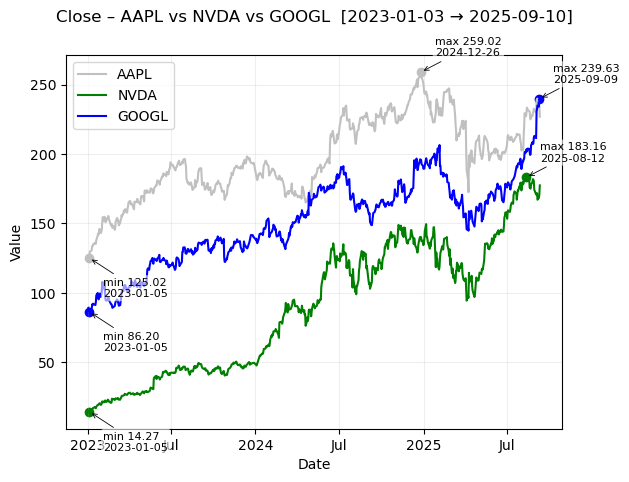

In [28]:
plot_metric_three(panel, metric="close")

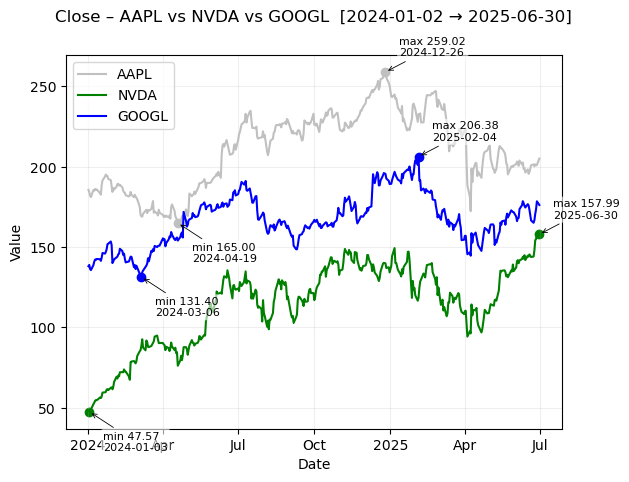

In [29]:
# limit time window
plot_metric_three(panel, metric="close", start="2024-01-01", end="2025-06-30")

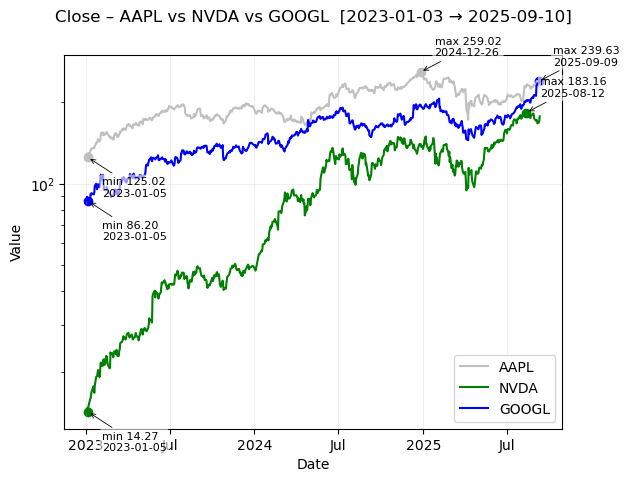

In [30]:
# log scale:
plot_metric_three(panel, metric="close", logy=True)

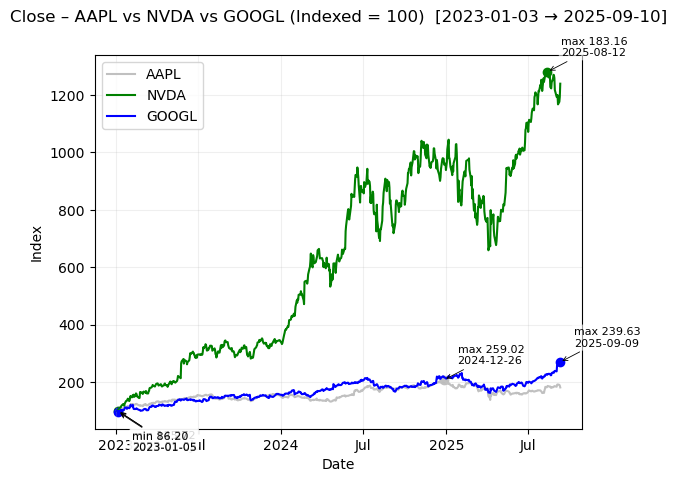

In [31]:
plot_metric_three(panel, metric="close", index_to_100=True)

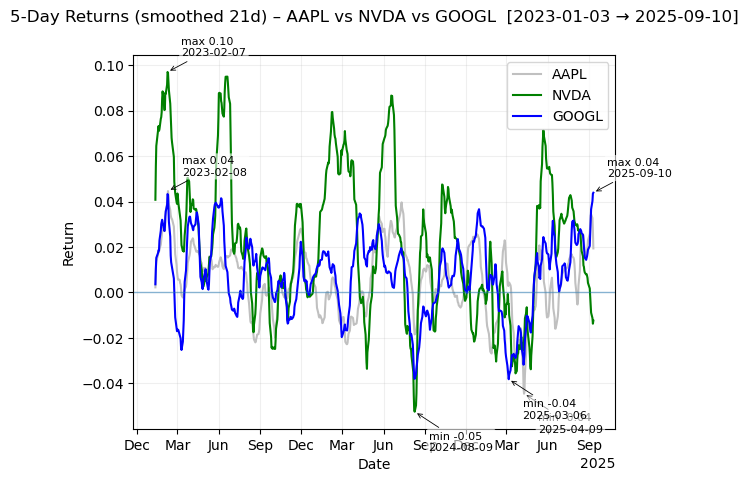

In [32]:
# Smoothed 5-day returns (clean)
plot_ret5d_smoothed(panel, window=21, x_ticks=3)  # tick every 3 months

In [33]:
panel

date  sp_ret_1d  sp_ret_5d   open_AAPL   high_AAPL    low_AAPL  \
0   2023-01-03  -0.004001  -0.005379  130.279999  130.899994  124.169998   
1   2023-01-04   0.007539   0.006194  126.889999  128.660004  125.080002   
2   2023-01-05  -0.011646   0.006576  127.129997  127.769997  124.760002   
3   2023-01-06   0.022841   0.011898  126.010002  130.289993  124.889999   
4   2023-01-09  -0.000768   0.013697  130.470001  133.410004  129.889999   
..         ...        ...        ...         ...         ...         ...   
669 2025-09-04   0.008346   0.003191  238.449997  239.899994  236.740005   
670 2025-09-05  -0.003165  -0.003131  240.000000  241.320007  238.490005   
671 2025-09-08   0.002106   0.005401  239.300003  240.149994  236.339996   
672 2025-09-09   0.002688   0.015130  237.000000  238.779999  233.360001   
673 2025-09-10   0.002983   0.012993  232.024994  232.339996  225.952194   

     close_AAPL  volume_AAPL   rsi_AAPL  macd_AAPL  ...  rsi_GOOGL  \
0    125.070000    112117500  32.289236  -0.918631  ...  43.522086   
1    126.360001     89113600  34.865899  -0.804463  ...  41.284568   
2    125.019997     80962700  33.442271  -0.740495  ...  37.528542   
3    129.619995     87754700  42.171463  -0.330580  ...  41.031929   
4    130.149994     70790800  43.097459   0.015696  ...  43.082347   
..          ...          ...        ...        ...  ...        ...   
669  239.779999     47549400  71.055962   0.403104  ...  83.472732   
670  239.690002     54870400  70.860190   0.512437  ...  84.504363   
671  237.880005     48999500  66.869775   0.392309  ...  82.531759   
672  234.350006     66313900  59.797196   0.023996  ...  84.762269   
673  226.789993     80814115  48.070856  -0.737808  ...  83.813836   

     macd_GOOGL  daily_pct_change_GOOGL  ret_1d_GOOGL  ret_5d_GOOGL  \
0     -0.186979                1.008726      0.010087     -0.001233   
1     -0.108571               -1.166967     -0.011670      0.007896   
2     -0.155985               -2.134429     -0.021344      0.002093   
3     -0.086693                1.322505      0.013225     -0.012549   
4      0.022958                0.778567      0.007786     -0.002380   
..          ...                     ...           ...           ...   
669    2.122803                0.711003      0.007110      0.119626   
670    2.558590                1.162289      0.011623      0.110376   
671    2.574690               -0.408513     -0.003194      0.100227   
672    2.739033                2.388486      0.023885      0.134821   
673    2.595336               -0.191965     -0.001920      0.037821   

     perf_vs_sp_ret_5d_GOOGL  return_volatility_5day_GOOGL  \
0                   0.004146                      0.019855   
1                   0.001701                      0.017843   
2                  -0.004484                      0.019340   
3                  -0.024448                      0.014533   
4                  -0.016077                      0.015234   
..                       ...                           ...   
669                 0.116435                      0.039188   
670                 0.113508                      0.039549   
671                 0.094826                      0.040663   
672                 0.119690                      0.037725   
673                 0.024829                      0.011053   

     bollinger_upper_GOOGL  bollinger_lower_GOOGL  bollinger_position_GOOGL  
0                98.001857              83.378150                  0.350895  
1                96.483606              83.764209                  0.291873  
2                95.543296              83.633902                  0.165889  
3                94.860297              83.562106                  0.281428  
4                94.325138              83.532162                  0.359948  
..                     ...                    ...                       ...  
669             225.730300             188.227460                  1.169644  
670             230.697530        

# *Finding similarly behaving companies*

In [34]:
# Build wide panel for all Nasdaq-100 stocks
nasdaq_100 = [
    "AAPL", "ABNB", "ADBE", "ADI", "ADP", "ADSK", "AEP", "AMAT", "AMD", "AMGN",
    "AMZN", "APP", "ARM", "ASML", "AVGO", "AXON", "AZN", "BIIB", "BKNG", "BKR",
    "CCEP", "CDNS", "CDW", "CEG", "CHTR", "CMCSA", "COST", "CPRT", "CRWD", "CSCO",
    "CSGP", "CSX", "CTAS", "CTSH", "DASH", "DDOG", "DXCM", "EA", "EXC", "FANG",
    "FAST", "FTNT", "GEHC", "GFS", "GILD", "GOOG", "GOOGL", "HON", "IDXX", "INTC",
    "INTU", "ISRG", "KDP", "KHC", "KLAC", "LIN", "LRCX", "LULU", "MAR", "MCHP",
    "MDLZ", "MELI", "META", "MNST", "MRVL", "MSFT", "MSTR", "MU", "NFLX", "NVDA",
    "NXPI", "ODFL", "ON", "ORLY", "PANW", "PAYX", "PCAR", "PDD", "PEP", "PLTR",
    "PYPL", "QCOM", "REGN", "ROP", "ROST", "SBUX", "SHOP", "SNPS", "TEAM", "TMUS",
    "TRI", "TSLA", "TTD", "TTWO", "TXN", "VRSK", "VRTX", "WBD", "WDAY", "XEL", "ZS"
]
nasdaq_100_df = build_wide_panel(
    nasdaq_100,
    start="2023-01-01",
    end=None,
    sp_ticker="^GSPC",
    ticker_tag_position="suffix",   # or "prefix"
    include_volatility=True         # set False if you don’t need Bollinger/vol
)
nasdaq_100_df.head()

date  sp_ret_1d  sp_ret_5d   open_AAPL   high_AAPL    low_AAPL  \
0 2023-01-03  -0.004001  -0.005379  130.279999  130.899994  124.169998   
1 2023-01-04   0.007539   0.006194  126.889999  128.660004  125.080002   
2 2023-01-05  -0.011646   0.006576  127.129997  127.769997  124.760002   
3 2023-01-06   0.022841   0.011898  126.010002  130.289993  124.889999   
4 2023-01-09  -0.000768   0.013697  130.470001  133.410004  129.889999   

   close_AAPL  volume_AAPL   rsi_AAPL  macd_AAPL  ...     rsi_ZS   macd_ZS  \
0  125.070000    112117500  32.289236  -0.918631  ...  38.155723  0.428207   
1  126.360001     89113600  34.865899  -0.804463  ...  40.362448  0.642316   
2  125.019997     80962700  33.442271  -0.740495  ...  33.702104  0.341703   
3  129.619995     87754700  42.171463  -0.330580  ...  33.348178  0.165496   
4  130.149994     70790800  43.097459   0.015696  ...  34.704865  0.153983   

   daily_pct_change_ZS  ret_1d_ZS  ret_5d_ZS  perf_vs_sp_ret_5d_ZS  \
0            -1.528149  -0.015281   0.012962              0.018341   
1             1.270527   0.012705   0.037371              0.031177   
2            -6.452189  -0.064522  -0.032171             -0.038748   
3            -0.411917  -0.004119  -0.070707             -0.082605   
4             0.759909   0.007599  -0.063896             -0.077593   

   return_volatility_5day_ZS  bollinger_upper_ZS  bollinger_lower_ZS  \
0                   0.020670          124.713665          104.623334   
1                   0.019379          123.910077          104.506923   
2                   0.037962          124.229083          103.029916   
3                   0.029868          124.554221          101.676778   
4                   0.030916          123.978895          100.774104   

   bollinger_position_ZS  
0               0.277082  
1               0.365048  
2               0.064157  
3               0.099802  
4               0.171339  

[5 rows x 1518 columns]

## Neighboring Companies Selection: Metrics Overview by Familty

### Momentum (Position & Trend) metrics
Momentum is one of the most studied effects in finance. These features describe both where price sits inside its short-term band (position: e.g., RSI, Bollinger position) and how much directional progress has accumulated over recent windows (trend: e.g., 20/63-day momentum, 20-day Sharpe, MACD). Together they help distinguish steady compounders with persistent, orderly advances (Apple-like) from bursty, momentum-driven names that surge or stall in waves (Nvidia-like), while also indicating when price is stretched or extended relative to its recent range.

#### **Metric**: `ret_1d` (1-day return)
**Calculation:** $\mathrm{ret_1d}(t)=\dfrac{\mathrm{close}t}{\mathrm{close}{t-1}}-1$
df['ret_1d'] = df['close'].pct_change()
> **Definition: The single-day price change, a micro-momentum signal.** Large positive or negative values typically mark event days (earnings, guidance, macro headlines). It is the atomic input for many rolling features; on its own it is noisy, but in aggregation it helps characterize trend bursts and shocks.

#### **Metric**: `ret_5d` (5-day return)
**Calculation:** $\mathrm{ret_5d}(t)=\dfrac{\mathrm{close}t}{\mathrm{close}{t-5}}-1$
df['ret_5d'] = df['close'].pct_change(5)
> **Definition: The cumulative move over ~one trading week, capturing very short-term trend.** Elevated positive values indicate recent follow-through; large negatives indicate recent pressure. 

#### **Metric**: `mom_20d` (20-day momentum)   
**Calculation**:  $\mathrm{MOM}{20}(t)=\sum{i=0}^{19} r_{t-i}$· `df['mom_20d']=df['ret_1d'].rolling(20).sum()`
> **Definition: Sum of the last \~20 trading-day returns**. Captures the **short-term trend**—specifically, whether there has been a **sustained** move *(many days in the past month with returns consistently above or below zero, not a single spike)*. It’s widely used for **screening** *(fast filter for recent strength/weakness)*, **timing** *(enter/exit when the sign turns and holds)*, and **regime tagging** *(label a name as uptrend / sideways / downtrend for downstream models)*. **Higher/positive** (often roughly +0.05 to +0.25 ≈ +5–25%) means the stock has been **rising over the month**; **lower/negative** (≈ −5–25%) means it has been **falling**. **Extremes** often cluster around **earnings surprises, guidance changes, and major news**. As a rule of thumb, a one-day flip is not considered actionable; assessment typically waits for 5–10 days of persistence. **Readings at or below −10% that continue to worsen**—especially alongside rising downside volatility or deepening drawdown—are commonly regarded as a **red-flag** condition.
                                                                                             
#### **Metric**: `mom_63d` (63-day momentum)        
**Calculation**: $\mathrm{MOM}{63}(t)=\sum{i=0}^{62} r_{t-i}$ · `df['mom_63d']=df['ret_1d'].rolling(63).sum()`
> **Definition: Sum of the last ~63 trading-day returns** (about three months). Captures **the medium-term trend**—that is, whether there has been a **sustained** move *(many weeks in which returns are predominantly above or below zero, not a one-week pop)*. It’s popular in professional screening and portfolio construction because three-month momentum is more stable than very short windows, lines up with the **quarterly earnings cadence**, and helps tag regimes (multi-week uptrend vs. downtrend) for downstream models or risk overlays. **Higher/positive** values (typically ~+10% to +40%) indicate a **multi-week advance**; **lower/negative** values (roughly −10% to −40%) indicate a **multi-week decline**. **Large magnitudes** often reflect **repeated earnings beats/misses**, upgrades/downgrades that accumulate over weeks, **product cycle** narratives, or **macro tailwinds/headwinds** affecting the sector. Rather than acting on a single reversal day, decisions are typically deferred until the sign of `mom_63d` has held for ~10–15 trading days. **Readings at or below −15% that continue to deteriorate**—especially alongside rising downside volatility or deepening drawdown—are commonly treated as a **red-flag** condition.  
                                                                                            
#### **Metric**:`sharpe_20d` (20-day “quality of trend”) 
**Calculation**: $\mathrm{Sharpe}{20}(t)=\dfrac{\mu{20}(r_{1d})}{\sigma_{20}(r_{1d})+\varepsilon}$ · `df['sharpe_20d']=df['ret_1d'].rolling(20).mean()/ (df['ret_1d'].rolling(20).std()+1e-12)` 
> **Definition: Average daily return over the last ~20 trading days divided by the daily return volatility over the same window**—a short-horizon Sharpe ratio *(i.e., return per unit of volatility over ~1 month; the risk-free adjustment is typically negligible at daily horizons and is omitted)*. It captures the **quality of the recent trend** by asking how much return you’re getting **per unit of noise**: smooth, orderly advances score higher than jittery ones with the same net gain. This metric is common in screening and portfolio sizing because it helps prioritize exposures that are **both** productive and stable. **Higher/positive values** (often ~0.2–1.0 in calm uptrends, occasionally >1.5 during exceptional runs) indicate a **steady, well-behaved advance**; **near zero or negative** means the period is **choppy or losing**, even if some days were strong. Around **earnings/news weeks**, volatility typically jumps; that can **pull `sharpe_20d` down** even when price ends higher. Rather than reacting to a single print, interpretation should wait for `sharpe_20d` to recover and remain positive for several days.                                                                                        

#### **Metric:** `bollinger_position` (normalized location within 20-day Bollinger bands)  
**Calculation:** \( \text{pos}=\dfrac{\text{close}-\text{LB}}{\text{UB}-\text{LB}} \), where \( \text{UB}=MA_{20}+2\sigma_{20} \) and \( \text{LB}=MA_{20}-2\sigma_{20} \)  ·  
`ma20=df['close'].rolling(20).mean(); sd20=df['close'].rolling(20).std(); ub=ma20+2*sd20; lb=ma20-2*sd20; df['bollinger_position']=(df['close']-lb)/(ub-lb)`  
> **Definition: A scale-free reading of where today’s close sits inside its recent 20-day price envelope**. Using the 20-day average with bands at ±2 standard deviations, the metric reports how far today’s close has progressed toward the upper band across the full width from the lower band to the upper band: it equals (today’s close − lower band) divided by (upper band − lower band), yielding a 0–1 “closeness-to-upper-band” scale. Values **near 1.0** indicate price hugging the **upper band** (extended strength), **near 0.0** indicate closeness to the **lower band** (pressure/weakness), and **~0.5** is mid-range/neutral. Bands **widen** when volatility rises and **narrow** during quiet periods; persistent readings near the extremes across several sessions point to **sustained trend** rather than a one-off spike. Around earnings or major news, a durable shift from **low** to **high** positioning (or the reverse) often accompanies a regime change in the name’s short-term behavior. 

#### **Metric:** `rsi` (14-day Relative Strength Index, 0–100)  
**Calculation:** \( \text{RSI}=100-\dfrac{100}{1+\text{RS}} \), with \( \text{RS}=\dfrac{\text{avg gain}_{14}}{\text{avg loss}_{14}} \)  ·  
from ta.momentum import RSIIndicator
df['rsi'] = RSIIndicator(close=df['close'], window=14).rsi(); or
chg = df['close'].diff(); up = chg.clip(lower=0); dn = (-chg.clip(upper=0))
avg_up = up.ewm(alpha=1/14, adjust=False, min_periods=14).mean()
avg_dn = dn.ewm(alpha=1/14, adjust=False, min_periods=14).mean()
rs = avg_up/(avg_dn + 1e-12); df['rsi'] = 100 - 100/(1 + rs)
NOTE: The 14-day average gain/loss is computed using Wilder’s smoothing (exponentially weighted with 𝛼=1/14). 
> **Definition:** A short-horizon momentum oscillator that summarizes whether **up days** or **down days** have dominated over ~14 sessions. It maps Relative Strength (smoothed 14-day average gain ÷ smoothed 14-day average loss) to a 0–100 index via RSI = 100 − 100/(1 + RS). **RSI≳70** reflects an unusually strong run (**“overbought”** = stretched to the upside, not a guaranteed reversal), **RSI≲30** reflects an unusually weak run (**“oversold”**). For trend context, **sustained >60** is often associated with healthy uptrends and **sustained <40** with downtrends. Post-earnings or headline weeks can push RSI to extremes; the key signal is whether it **stays** elevated/depressed for several days (trend) or quickly snaps back (noise). 

#### **Metric:** `macd` (12/26-day EMA spread) 
**Calculation:** \( \text{MACD}=\text{EMA}_{12}(\text{close})-\text{EMA}_{26}(\text{close}) \)  
from ta.trend import MACD
macd_line = MACD(close=close).macd(); or:
`ema12=df['close'].ewm(span=12, adjust=False).mean(); ema26=df['close'].ewm(span=26, adjust=False).mean(); df['macd']=ema12-ema26`  
> **Definition: The difference between a *fast* and a *slow* moving average of price**. Computed as the 12-day EMA minus the 26-day EMA, where each EMA is updated recursively as EMAₜ = α·closeₜ + (1−α)·EMAₜ₋₁ with α = 2 / (span+1) (so α₁₂ = 2/13, α₂₆ = 2/27). **positive and rising** values indicate the fast trend is above—and pulling away from—the slow trend (building upside momentum), while **negative and falling** values indicate the opposite (building downside momentum). Crossings around **zero** often mark potential shifts in the dominant swing, and multi-day persistence carries more weight than a single print. Earnings and major news can flip MACD abruptly; evidence of follow-through in subsequent sessions typically distinguishes **trend change** from **headline whipsaw**. 

### Volatility / Risk metrics
These metrics quantify the size and shape of price fluctuations (short- and month-level realized volatility, downside-only volatility), the distance from recent peaks (drawdown), and how returns split into market-driven versus stock-specific components (beta vs. idiosyncratic volatility). In combination they separate calm, resilient profiles from turbulent, market-amplifying profiles, and indicate whether risk is symmetric or tilted toward losses—signals that map naturally onto Apple-like stability, Nvidia-like aggressiveness, and Google-like middle-ground behavior.
                         
#### **Metric**: `rv_5d` (5-day realized volatility)  <br> **Calculation**: $\sigma_{5}(r_{1d})$ · `df['rv_5d']=df['ret_1d'].rolling(5).std()`                                                           
> **Definition: Standard deviation of daily returns over \~1 week**. Provides a quick read on **very recent turbulence**. It is useful for short-horizon risk sizing and for flagging event weeks. **Higher readings (≈ ≥ 3% per day)** indicate a jumpy week; **lower readings (≈ 1–2% per day)** indicate a calm week. Spikes commonly appear around **earnings releases, guidance updates, regulatory headlines, or macro prints**; interpretation typically emphasizes **persistence over several sessions** rather than reacting to an isolated day.  

#### **Metric**: `rv_20d` (20-day realized volatility)  <br> **Calculation**: $\sigma_{20}(r_{1d})$ · `df['rv_20d']=df['ret_1d'].rolling(20).std()`                                                       
> **Definition: Month-level volatility**. A widely used **baseline risk gauge** *(a standard, go-to measure of typical price variability over a recent window)* for position sizing *(choosing how big the investment should be—how many shares or how many dollars—to keep potential losses within agreed limits)* and Value-at-Risk *(a statistical estimate of the maximum expected loss over a chosen horizon at a specified confidence level, e.g., 95% one-day VaR)*. **Higher levels (≈ 2–6% per day)** signal larger routine swings; **lower levels** signal steadier trading. Elevation often coincides with **earnings seasons, prolonged news cycles, sector rotations, or macro uncertainty**. In practice, trend context matters: the same volatility is viewed differently in a steady up-trend versus a disorderly tape. 

#### **Metric**: `semivol_20d` (20-day downside volatility)  <br> **Calculation**: $\sigma_{20}(\min(r_{1d},0))$ · `neg=df['ret_1d'].clip(upper=0); df['semivol_20d']=neg.rolling(20).std()`        
> **Definition: Volatility of loss days only**, focusing on **downside risk** rather than overall choppiness. **Higher values** indicate that **down moves are large when they occur**; when `semivol_20d` sits close to `rv_20d`, most variability is coming from losses. Elevation is frequently associated with **negative earnings surprises, guidance cuts, downgrades, or adverse regulatory news**. Persistent elevation over several weeks is generally treated as a sign of deteriorating risk quality. 

#### **Metric**: `beta_sp_60d` (60-day beta vs S\&P)  <br> **Calculation**: $\displaystyle \beta_{60}=\frac{\operatorname{Cov}_{60}(r_i,r_m)}{\operatorname{Var}_{60}(r_m)+\varepsilon}$ · <br> 
win = 60; eps = 1e-12; r = df['ret_1d'] # stock daily returns; m = df['sp_ret_1d'] # S&P daily returns (aligned); cov_rm = r.rolling(win, min_periods=win).cov(m); var_m  = m.rolling(win, min_periods=win).var(); df['beta_sp_60d'] = cov_rm / (var_m + eps)      
> **Definition: quantifies sensitivity to the market**—how much the stock typically moves when the index moves—estimated over \~60 days. It is central to hedging *(using offsetting positions—e.g., futures - standardized contracts to buy/sell later at a set price, options - rights—not obligations—to buy/sell at a set price by a date, or shorts - selling borrowed shares to profit if the price falls —to reduce or neutralize losses from adverse price moves)*; and portfolio construction (choosing assets and weights - the % of total capital allocated to each holding - to reach a target return/risk profile, subject to constraints such as diversification [spreading exposure to avoid concentration risk], sector limits [caps on how much can be invested in any one industry], and turnover [how frequently positions are changed, which drives trading costs]). **Values > 1.2** behave **aggressively** with the market; **\~1.0** is **market-like**; **< 0.8** is **defensive** *(tends to move less than the market)*. Beta can **drift with regime changes** (rates, policy, business mix) and tends to shift across quarters rather than single event days; earnings seasons can alter beta as new information changes how a name comoves with the index.  

#### **Metric**: `idio_vol_20d` (20-day idiosyncratic volatility)  <br> **Calculation**: residual $e_t=r_i-\beta_{60}\,r_m$, then $\sigma_{20}(e_t)$ · <br>                                        
e = df['ret_1d'] - df['beta_sp_60d'] * df['sp_ret_1d']; df['idio_vol_20d'] = e.rolling(20, min_periods=20).std()
> **Definition: the volatility that remains after removing market moves**- highlighting **company-specific** risk and news flow. **Higher readings** (≈ 1–4% per day on residuals, sometimes higher in event names) indicate that the stock is **jumpy on its own**; **lower** readings indicate motion is mostly **market-driven**. Elevation is commonly linked to **earnings cycles, product/clinical readouts, management changes, M\&A headlines, or litigation**; persistent idiosyncratic volatility often signals an ongoing catalyst path.

#### **Metric**: `dd_60d` (60-day drawdown)  <br> **Calculation**: $\text{DD}_{60}=\frac{\text{close}}{\max_{j\le 60} \text{close}_{t-j}}-1$ · `mx=df['close'].rolling(60).max(); df['dd_60d']=df['close']/mx - 1` 
> **Definition: measures how far price sits *below* its highest close in the last 60 days**, summarizing the **depth of a recent slump**. **Near 0** indicates price is at/near highs; **−10% to −20%** marks a **notable correction**; **< −30%** reflects a **deep slump**. Large drawdowns often follow **negative earnings/guidance cycles**, **sector de-rating**, or **macro headwinds**; ongoing deterioration together with elevated downside volatility generally signals a risk regime that warrants closer monitoring.                                  

#### **Metric:** `range_pct` (intraday range as % of close)  
**Calculation:** $ \mathrm{range\_pct} = \frac{\mathrm{high}-\mathrm{low}}{\mathrm{close}} $
`df['range_pct']=(df['high']-df['low'])/df['close']`  
> **Definition: A same-day turbulence metric capturing how far price moved intraday**. Measures the intraday distance between the day’s high and low, divided by the closing price.**Higher readings** (large fraction of price, e.g., 3–10% in big names; more in smaller caps) indicate **busy, headline-driven or breakout** days *(“breakout” = a strong move beyond recent highs/lows)*; **lower readings** (<1–2% in large caps) suggest a contained session. Because it is normalized by price, it compares across tickers and through time. Surges commonly cluster around **earnings releases, guidance changes, regulatory/macro prints**, and **news-led squeezes**; repeated high values over several sessions can indicate **ongoing repricing** rather than noise.

#### **Metric:** `gap_ret` (overnight gap return)  
**Calculation:** $ \text{gap\_ret}=\frac{\text{open}}{\text{close}_{t-1}}-1 $ 
`prev=df['close'].shift(1); df['gap_ret']=df['open']/prev - 1`  
> **Definition: The after-hours/overnight move from yesterday’s close to today’s open**. Gaps isolate **information arriving outside regular hours** (earnings, M&A, guidance, macro headlines). **Large positive gaps** (>+2–5% in large caps) often reflect **surprises to the upside**; **large negative gaps** reflect disappointments. Some names **continue** in the gap direction (trend days), others **mean-revert** *(price drifts back toward the prior close)*—this varies by sector and catalyst. Repeated gaps in one direction within a quarter can indicate a **changing fundamental narrative** or **positioning/flow dynamics**. 


### Liquidity / Participation Metrics
This category captures the unusualness of trading activity relative to the stock’s own history—primarily via a volume z-score that summarizes participation intensity (how many and how actively participants are trading). Elevated participation often coincides with event-driven conditions (earnings, guidance, major news) and helps explain whether a price move likely reflects broad conviction or thin, low-attention tape. As an input to classification, participation distinguishes steady, routine trading from attention spikes, sharpening the context provided by price-based momentum and volatility signals.

#### **Metric:** `volume` (raw shares traded)
**Calculation**: Exchange-reported daily shares traded (or contracts for ADRs), e.g. df['volume'].
> **Definition: A scale-dependent measure of trading activity and capacity to transact.** Raw volume is useful within a ticker through time (e.g., rising or falling participation); for cross-ticker comparison, a normalized measure such as vol_z_60d is preferred. when mixing volume with other features, a per-ticker z-score or a log transform (np.log1p(volume)) avoids size effects from dominating.

#### **Metric:** `vol_z_60d` (volume z-score)  
**Calculation:** $z_{60} = \frac{\mathrm{volume} - \mu_{60}(\mathrm{volume})}{\sigma_{60}(\mathrm{volume}) + \varepsilon}$ 
`ma=df['volume'].rolling(60).mean(); sd=df['volume'].rolling(60).std(); df['vol_z_60d']=(df['volume']-ma)/(sd+1e-12)`  
> **Definition:** **A z-score of today’s trading volume relative to the past ~60 days**: it tells how many **standard deviations** today is above or below the recent average *(z≈0 = typical day; z=+2 means today’s volume is ~2 SDs above normal; z=−2 is ~2 SDs below)*. **Unusual volume** often indicates a change in **market participation** *(the number and mix of active buyers/sellers)* and **liquidity** *(the capacity to trade size quickly with minimal price change)*. **High positive values** (≈ +2 and above) flag **attention spikes**—often around **earnings, guidance, product/news drops, index rebalances, or options events**; **deep negatives** (≈ −2 or below) indicate unusually quiet sessions. Persistent elevation over several days can signal **sustained interest/flow**, whereas one-day spikes often fade. In practice, vol_z_60d is used to screen for **attention spikes** (systematically surface names with abnormal interest); **flag event windows** (days around earnings, guidance, regulatory or macro releases, index rebalances, or options expiries when trading conditions differ from normal); **validate price moves** *(advances/declines accompanied by high volume are more likely to reflect broad conviction than moves on light volume—useful for confirming “breakouts” or “selloffs”)*; prioritize monitoring when managing a large universe *(dozens to hundreds of tickers)*; and set liquidity-aware execution plans.   Note: holiday weeks and structural changes (e.g., splits) can shift baselines and should be considered when interpreting z.

---

**Implementation notes**
- Computed **per ticker** on **date-sorted** rows to avoid mixing histories.  
- Used a tiny epsilon (e.g., `1e-12`) in denominators for numerical stability.  
- Considered **winsorize (1–99%)** and **z-score** features before K-means so no single scale dominates.

In [35]:
# Build df_long (one row per date–ticker) from your wide table

# Start from the wide table
df_nas = nasdaq_100_df.copy()
df_nas["date"] = pd.to_datetime(df_nas["date"])

# Extract tickers actually present in the columns (safeguard)
present = {c.split("_")[-1] for c in df_nas.columns if "_" in c and c.split("_")[-1].isupper()}
tickers = sorted(set(nasdaq_100).intersection(present))

# pull columns that already exist in the wide table
# (computed features come later)
features_from_wide = [
    "ret_1d", "ret_5d", "rsi", "macd", "return_volatility_5day",
    "bollinger_position", "volume", "open", "high", "low", "close"
]

# Build long format: one row per (date, ticker)
long_rows = []
for t in tickers:
    rows = pd.DataFrame({
        "date": df_nas["date"].values,
        "ticker": t
    })
    # copy over market return once (needed for beta/idiosyncratic vol later)
    if "sp_ret_1d" in df_nas.columns:
        rows["sp_ret_1d"] = df_nas["sp_ret_1d"].values

    # attach each feature for this ticker if it exists
    for feat in features_from_wide:
        col = f"{feat}_{t}"
        if col in df_nas.columns:
            rows[feat] = df_nas[col].values

    long_rows.append(rows)

df_long = pd.concat(long_rows, ignore_index=True)
df_long = df_long.sort_values(["ticker", "date"]).reset_index(drop=True)


In [36]:
df_long

date ticker  sp_ret_1d    ret_1d    ret_5d        rsi      macd  \
0     2023-01-03   AAPL  -0.004001 -0.037405 -0.051494  32.289236 -0.918631   
1     2023-01-04   AAPL   0.007539  0.010314 -0.028224  34.865899 -0.804463   
2     2023-01-05   AAPL  -0.011646 -0.010605 -0.008093  33.442271 -0.740495   
3     2023-01-06   AAPL   0.022841  0.036794  0.000077  42.171463 -0.330580   
4     2023-01-09   AAPL  -0.000768  0.004089  0.001693  43.097459  0.015696   
...          ...    ...        ...       ...       ...        ...       ...   
68069 2025-09-04     ZS   0.008346 -0.008611 -0.017651  41.018601  0.359618   
68070 2025-09-05     ZS  -0.003165  0.022181 -0.022181  47.615878  0.546507   
68071 2025-09-08     ZS   0.002106  0.026988  0.016423  54.441159  1.139450   
68072 2025-09-09     ZS   0.002688  0.002450  0.028117  55.029531  1.525003   
68073 2025-09-10     ZS   0.002983 -0.012399  0.030342  51.403166  1.489485   

       return_volatility_5day  bollinger_position     volume        open  \
0                    0.026542            0.088865  112117500  130.279999   
1                    0.027883            0.167715   89113600  126.889999   
2                    0.024580            0.156712   80962700  127.129997   
3                    0.027283            0.345061   87754700  126.010002   
4                    0.027324            0.383183   70790800  130.470001   
...                       ...                 ...        ...         ...   
68069                0.017141            0.142407    2091400  269.869995   
68070                0.015047            0.572803    1621100  269.619995   
68071                0.019541            1.015185    1839700  275.000000   
68072                0.018368            0.975084    1634400  281.350006   
68073                0.017796            0.748756    1823474  284.299988   

             high         low       close  
0      130.899994  124.169998  125.070000  
1      128.660004  125.080002  126.360001  
2      127.769997  124.760002  125.019997  
3      130.289993  124.889999  129.619995  
4      133.410004  129.889999  130.149994  
...           ...         ...         ...  
68069  270.000000  262.899994  268.250000  
68070  274.200012  267.000000  274.200012  
68071  281.760010  273.734009  281.600006  
68072  284.339996  279.000000  282.290009  
68073  288.890015  276.309998  278.790009  

[68074 rows x 14 columns]

In [38]:
# Compute rolling features per ticker 
# Ensure sorted for rolling windows
df_long = df_long.sort_values(["ticker", "date"])

# Helper to compute per-ticker rolling features
def add_features(g):
    # --- momentum & Sharpe ---
    g["mom_20d"] = g["ret_1d"].rolling(20).sum()
    g["mom_63d"] = g["ret_1d"].rolling(63).sum()
    g["rv_5d"]   = g["ret_1d"].rolling(5).std()
    g["rv_20d"]  = g["ret_1d"].rolling(20).std()
    g["sharpe_20d"] = g["ret_1d"].rolling(20).mean() / (g["ret_1d"].rolling(20).std() + 1e-12)

    # --- downside semivol ---
    neg = g["ret_1d"].where(g["ret_1d"] < 0, 0.0)
    g["semivol_20d"] = neg.rolling(20).std()

    # --- drawdown (60d) ---
    g["rolling_max_60"] = g["close"].rolling(60).max()
    g["dd_60d"] = (g["close"] / g["rolling_max_60"]) - 1.0
    g.drop(columns=["rolling_max_60"], inplace=True)

    # --- volume z-score (60d) ---
    vol_ma = g["volume"].rolling(60).mean()
    vol_sd = g["volume"].rolling(60).std()
    g["vol_z_60d"] = (g["volume"] - vol_ma) / (vol_sd + 1e-12)

    # --- intraday range & gaps ---
    g["range_pct"] = (g["high"] - g["low"]) / g["close"]
    g["prev_close"] = g["close"].shift(1)
    g["gap_ret"] = (g["open"] / g["prev_close"]) - 1.0
    g.drop(columns=["prev_close"], inplace=True)

    # --- MACD line (12/26 EMA spread; NOT the histogram) ---
    # Use min_periods so values start only after enough data is available
    ema12 = g["close"].ewm(span=12, adjust=False, min_periods=12).mean()
    ema26 = g["close"].ewm(span=26, adjust=False, min_periods=26).mean()
    g["macd_new"] = ema12 - ema26  # this is the MACD line

    # --- rolling beta & idiosyncratic vol vs S&P (60d) ---
    if "sp_ret_1d" in g.columns:
        r = g["ret_1d"]
        m = g["sp_ret_1d"]
        r_mean60 = r.rolling(60).mean()
        m_mean60 = m.rolling(60).mean()
        cov = (r * m).rolling(60).mean() - r_mean60 * m_mean60
        var_m = (m * m).rolling(60).mean() - m_mean60**2
        g["beta_sp_60d"] = cov / (var_m + 1e-12)

        # idiosyncratic volatility (20d std of CAPM residuals)
        g["idio_resid"] = r - g["beta_sp_60d"] * m
        g["idio_vol_20d"] = g["idio_resid"].rolling(20).std()
        g.drop(columns=["idio_resid"], inplace=True)
    else:
        g["beta_sp_60d"] = np.nan
        g["idio_vol_20d"] = np.nan

    return g

# keep the key during concat, then reset it into a column
df_long = (
    df_long.sort_values(["ticker", "date"])
           .groupby("ticker", group_keys=True)
           .apply(add_features, include_groups=False)
           .reset_index(level=0)          # bring 'ticker' out of the index
           .reset_index(drop=True)
)

assert "ticker" in df_long.columns
assert "macd_new" in df_long.columns

In [39]:
df_long.tail()

ticker       date  sp_ret_1d    ret_1d    ret_5d        rsi      macd  \
68069     ZS 2025-09-04   0.008346 -0.008611 -0.017651  41.018601  0.359618   
68070     ZS 2025-09-05  -0.003165  0.022181 -0.022181  47.615878  0.546507   
68071     ZS 2025-09-08   0.002106  0.026988  0.016423  54.441159  1.139450   
68072     ZS 2025-09-09   0.002688  0.002450  0.028117  55.029531  1.525003   
68073     ZS 2025-09-10   0.002983 -0.012399  0.030342  51.403166  1.489485   

       return_volatility_5day  bollinger_position   volume  ...    rv_20d  \
68069                0.017141            0.142407  2091400  ...  0.018557   
68070                0.015047            0.572803  1621100  ...  0.014348   
68071                0.019541            1.015185  1839700  ...  0.015277   
68072                0.018368            0.975084  1634400  ...  0.015258   
68073                0.017796            0.748756  1823474  ...  0.015237   

       sharpe_20d  semivol_20d    dd_60d  vol_z_60d  range_pct   gap_ret  \
68069   -0.194398     0.013349 -0.152449   0.174404   0.026468 -0.002624   
68070    0.028470     0.006797 -0.133649  -0.272972   0.026258  0.005107   
68071    0.148761     0.006848 -0.110269  -0.062258   0.028501  0.002918   
68072    0.138930     0.006848 -0.108088  -0.254473   0.018917 -0.000888   
68073    0.047007     0.006882 -0.119147  -0.070759   0.045124  0.007120   

       macd_new  beta_sp_60d  idio_vol_20d  
68069 -3.309231     0.818996      0.017913  
68070 -2.985714     0.780553      0.014165  
68071 -2.107909     0.810214      0.014761  
68072 -1.341105     0.806915      0.014700  
68073 -1.004252     0.877488      0.015070  

[5 rows x 27 columns]

In [40]:
# trim to avoid NAs and keep recent 2Y data
import pandas as pd

# Replace `df_ready` with your actual dataframe variable (e.g., df_long or df_ready)
df_trim = df_long.copy()  # keep original intact

# Ensure datetime dtype (and drop any time-of-day if present)
df_trim["date"] = pd.to_datetime(df_trim["date"]).dt.floor("D")

start = pd.Timestamp("2023-08-01")
end   = pd.Timestamp("2025-07-31")

df_trim = df_trim.loc[(df_trim["date"] >= start) & (df_trim["date"] <= end)].reset_index(drop=True)

# Quick sanity checks (optional)
print(df_trim["date"].min(), "→", df_trim["date"].max(), f"({len(df_trim):,} rows)")
print(df_trim.groupby("ticker").size().describe())  # distribution of rows per ticker

2023-08-01 00:00:00 → 2025-07-31 00:00:00 (50,702 rows)
count    101.0
mean     502.0
std        0.0
min      502.0
25%      502.0
50%      502.0
75%      502.0
max      502.0
dtype: float64


In [41]:
# ---- Choose features (keep only those present) ----
features_for_clustering = [
    "ret_1d", "ret_5d", "rsi", "macd_new",
    "bollinger_position", "volume",
    "mom_20d", "mom_63d", "sharpe_20d",
    "rv_5d", "rv_20d", "semivol_20d",
    "beta_sp_60d", "idio_vol_20d",
    "vol_z_60d", "range_pct", "gap_ret",
]
features_for_clustering = [c for c in features_for_clustering if c in df_trim.columns]
if not features_for_clustering:
    raise ValueError("No requested features found in df_trim. Check column names.")

# ---- Final clean & typing (cast → winsorize → dropna) ----
work = df_trim.copy()

# 2a) Cast all selected features to float (avoids Int64 vs float issues)
work[features_for_clustering] = (
    work[features_for_clustering]
    .apply(pd.to_numeric, errors="coerce")
    .astype("float64")
)

# Vectorized winsorization (1st–99th pct) per column
lo = work[features_for_clustering].quantile(0.01, axis=0)  # Series indexed by columns
hi = work[features_for_clustering].quantile(0.99, axis=0)
work[features_for_clustering] = work[features_for_clustering].clip(lower=lo, upper=hi, axis=1)

# 2c) Drop any rows that still have NaNs in the features
work = work.dropna(subset=features_for_clustering).copy()

# ---- 3) Scale ----
scaler = StandardScaler()
X = scaler.fit_transform(work[features_for_clustering])

  File "C:\Users\shara\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\shara\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\shara\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\shara\anaconda3\Lib\subprocess.

Elbow k: 4
Silhouette-by-k: {2: 0.198347224397253, 3: 0.18615541028306423, 4: 0.17345015580201015, 5: 0.1719458774976958, 6: 0.13126716699416868, 7: 0.13153362611407887, 8: 0.11507812551554414, 9: 0.13585142574304612, 10: 0.10923195534440396, 11: 0.1048640359368632, 12: 0.1031552721438845} → best_k: 2


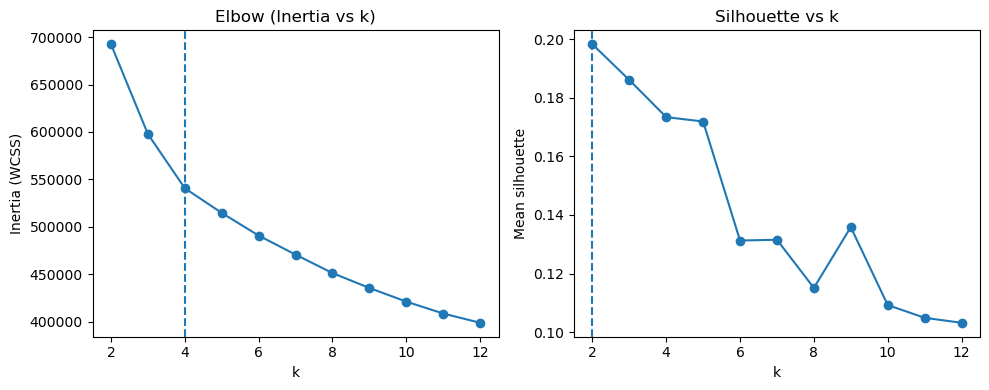

In [42]:
# ---- Scan k, plot elbow & silhouette, and pick suggested k ---- (takes a bit time)
def scan_k(X, k_min=2, k_max=12, n_init=50, random_state=42):
    ks, inertias, sils = [], [], []
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        labels = km.fit_predict(X)
        ks.append(k)
        inertias.append(km.inertia_)
        sils.append(silhouette_score(X, labels))
    ks = np.array(ks); inertias = np.array(inertias, dtype=float); sils = np.array(sils, dtype=float)
    return ks, inertias, sils

def elbow_k(ks, inertias):
    # “Max distance to chord” heuristic
    x = ks.astype(float)
    y = (inertias - inertias.min()) / (inertias.max() - inertias.min() + 1e-12)
    p1 = np.array([x[0], y[0]])
    p2 = np.array([x[-1], y[-1]])
    # perpendicular distance from each (x,y) to the line p1->p2
    v = p2 - p1
    v /= np.linalg.norm(v)
    diffs = np.vstack([x, y]).T - p1
    proj = diffs @ v
    closest = np.outer(proj, v) + p1
    dists = np.linalg.norm(diffs - (closest - p1), axis=1)
    return int(ks[np.argmax(dists)])

# ---- run scan and plot
ks, inertias, sils = scan_k(X, k_min=2, k_max=12, n_init=50, random_state=42)
k_elbow = elbow_k(ks, inertias)
k_sil = int(ks[np.argmax(sils)])

print("Elbow k:", k_elbow)
print("Silhouette-by-k:", {int(k): float(s) for k, s in zip(ks, sils)}, "→ best_k:", k_sil)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Elbow
ax[0].plot(ks, inertias, marker='o')
ax[0].axvline(k_elbow, ls='--')
ax[0].set_title("Elbow (Inertia vs k)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia (WCSS)")

# Silhouette
ax[1].plot(ks, sils, marker='o')
ax[1].axvline(k_sil, ls='--')
ax[1].set_title("Silhouette vs k")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Mean silhouette")

plt.tight_layout()
plt.show()


In [44]:
# view clustering by features
def describe_k(X, work_df, k, random_state=42):
    km = KMeans(n_clusters=k, n_init=100, random_state=random_state)
    labels = km.fit_predict(X)
    work_df = work_df.copy()
    work_df[f'cluster_k{k}'] = labels
    prof = work_df.groupby(f'cluster_k{k}')[features_for_clustering].median().round(4)
    sizes = work_df[f'cluster_k{k}'].value_counts().sort_index()
    return prof, sizes, work_df

for k in (2, 3, 4):
    prof, sizes, work_k = describe_k(X, work, k)
    print(f"\n=== k={k} ===")
    print("Cluster sizes:", sizes.to_dict())
    print("Medians:\n", prof)



=== k=2 ===
Cluster sizes: {0: 27342, 1: 23250}
Medians:
             ret_1d  ret_5d      rsi  macd_new  bollinger_position     volume  \
cluster_k2                                                                     
0           0.0040  0.0190  60.5705    2.1169              0.7842  3329350.0   
1          -0.0038 -0.0184  42.6323   -1.1557              0.2605  4042450.0   

            mom_20d  mom_63d  sharpe_20d   rv_5d  rv_20d  semivol_20d  \
cluster_k2                                                              
0            0.0608   0.1087      0.1908  0.0134   0.016       0.0076   
1           -0.0413  -0.0196     -0.1167  0.0166   0.019       0.0125   

            beta_sp_60d  idio_vol_20d  vol_z_60d  range_pct  gap_ret  
cluster_k2                                                            
0                1.0437        0.0134    -0.3102     0.0195   0.0011  
1                1.1225        0.0154    -0.1644     0.0234  -0.0002  

=== k=3 ===
Cluster sizes: {0: 6928, 1: 22

In [45]:
# ---- Final K-means ----
kmeans = KMeans(n_clusters=3, random_state=42, n_init=100)
work["cluster"] = kmeans.fit_predict(X)

# ---- Cluster profiles (medians) ----
profiles = work.groupby("cluster")[features_for_clustering].median().sort_index()
print("\nCluster profiles (feature medians):\n", profiles)

# ---- Company concentration in clusters ----
counts = work.groupby(["ticker", "cluster"]).size().unstack(fill_value=0)
perc = counts.div(counts.sum(axis=1), axis=0).sort_index()
print("\n% of days per cluster for each ticker (head):\n", perc.head())


Cluster profiles (feature medians):
            ret_1d    ret_5d        rsi  macd_new  bollinger_position  \
cluster                                                                
0       -0.002153 -0.013318  46.767332 -0.751730            0.397991   
1        0.004336  0.021048  61.907795  2.474296            0.809776   
2       -0.002810 -0.013650  43.919668 -0.754207            0.289238   

             volume   mom_20d   mom_63d  sharpe_20d     rv_5d    rv_20d  \
cluster                                                                   
0        11101900.0 -0.028879  0.018742   -0.037964  0.035734  0.038551   
1         3093900.0  0.065998  0.114272    0.214130  0.013224  0.015950   
2         3186900.0 -0.030084 -0.007952   -0.099241  0.013495  0.015699   

         semivol_20d  beta_sp_60d  idio_vol_20d  vol_z_60d  range_pct  \
cluster                                                                 
0           0.023211     2.059632      0.029162   0.044803   0.042208   
1     

### Feature Reduction:
##### To improve classification, a feature reduction method followed, by evaluating:
* **Separation power**: how much a feature explains between-cluster variance (relative to total).
* **Redundancy**: drop near-duplicates via correlation threshold, keeping the stronger separator.
* **Multicollinearity**: cap VIF to keep geometry well-conditioned.
* **Clustering quality**: ablation effect on silhouette with k=3 (your narrative choice).
* **Stability**: set performance across time splits / bootstrap subsamples.

In [46]:
# --------- Candidate pool (broad) ----------
feat_pool = [c for c in [
    "ret_1d","ret_5d","rsi","macd_new","bollinger_position",
    "mom_20d","mom_63d","sharpe_20d",
    "rv_5d","rv_20d","semivol_20d","dd_60d",
    "beta_sp_60d","idio_vol_20d",
    "vol_z_60d","range_pct","gap_ret","volume"
] if c in work.columns]

# (A) Separation score: between / total variance on a provisional k=3 fit
def separation_score(df, cols, label="cluster", k=3, n_init=50):
    X = StandardScaler().fit_transform(df[cols].astype("float32"))
    labels = KMeans(n_clusters=k, random_state=42, n_init=n_init, algorithm="elkan").fit_predict(X)
    tmp = df.copy()
    tmp[label] = labels
    sizes = tmp.groupby(label).size()
    centroids = tmp.groupby(label)[cols].mean()
    gmean = tmp[cols].mean()
    between = ((centroids - gmean)**2).mul(sizes, axis=0).sum(axis=0) / len(tmp)
    total = tmp[cols].var()
    return (between/total).fillna(0).sort_values(ascending=False)

sep = separation_score(work, feat_pool)
sep.name = "sep_ratio"
sep

rsi                   0.626656
bollinger_position    0.569688
semivol_20d           0.561187
sharpe_20d            0.549972
dd_60d                0.507403
rv_20d                0.446212
mom_20d               0.412664
idio_vol_20d          0.331767
rv_5d                 0.331233
range_pct             0.283626
macd_new              0.230988
ret_5d                0.200385
beta_sp_60d           0.198379
mom_63d               0.190473
volume                0.089018
ret_1d                0.060699
vol_z_60d             0.026981
gap_ret               0.016757
Name: sep_ratio, dtype: float64

In [47]:
# Correlation pruning (|ρ| ≥ 0.85) — keep the stronger separator in each pair
def correlation_prune(df, cols, corr_thresh=0.85, preference=None):
    corr = df[cols].corr().abs()
    order = list(preference.index) if isinstance(preference, pd.Series) else cols
    keep, banned = [], set()
    for f in order:
        if f in banned: 
            continue
        keep.append(f)
        banned.update(corr.index[(corr[f] >= corr_thresh) & (corr.index != f)])
    return keep, corr

keep_after_corr, corr_mat = correlation_prune(work, feat_pool, 0.85, sep)
keep_after_corr

['rsi',
 'semivol_20d',
 'dd_60d',
 'rv_20d',
 'mom_20d',
 'rv_5d',
 'range_pct',
 'macd_new',
 'ret_5d',
 'beta_sp_60d',
 'mom_63d',
 'volume',
 'ret_1d',
 'vol_z_60d',
 'gap_ret']

**dropped:** bollinger_position, sharpe_20d, idio_vol_20d

In [48]:
# VIF (no statsmodels): drop features with VIF > 10, weakest separator goes first
from sklearn.linear_model import LinearRegression
def vif_series(df, cols):
    X = StandardScaler().fit_transform(df[cols].astype("float32"))
    out = {}
    for i, c in enumerate(cols):
        y = X[:, i]
        Xo = np.delete(X, i, axis=1)
        r2 = LinearRegression().fit(Xo, y).score(Xo, y)
        out[c] = 1.0 / max(1.0 - r2, 1e-12)
    return pd.Series(out).sort_values(ascending=False)

cur = keep_after_corr[:]
while True:
    v = vif_series(work, cur)
    if v.max() <= 10:
        break
    high = v[v > 10].index
    dropf = sep.loc[high].idxmin()
    cur.remove(dropf)

vif_final = vif_series(work, cur)
vif_final

rv_20d         8.806281
semivol_20d    8.236844
rsi            5.157664
mom_20d        4.958715
dd_60d         4.536354
mom_63d        2.405170
rv_5d          2.340778
range_pct      2.299754
ret_5d         1.972659
macd_new       1.769302
beta_sp_60d    1.765861
ret_1d         1.672320
gap_ret        1.417582
vol_z_60d      1.400351
volume         1.181269
dtype: float64

**No features with excessive collinearity (VIF > 10) were found.** The output set has all VIFs below the threshold, meaning no variable can be explained too strongly by the others. The remaining mild correlations (VIF ~5–9) reflect natural overlap between volatility and momentum measures but are not problematic. 

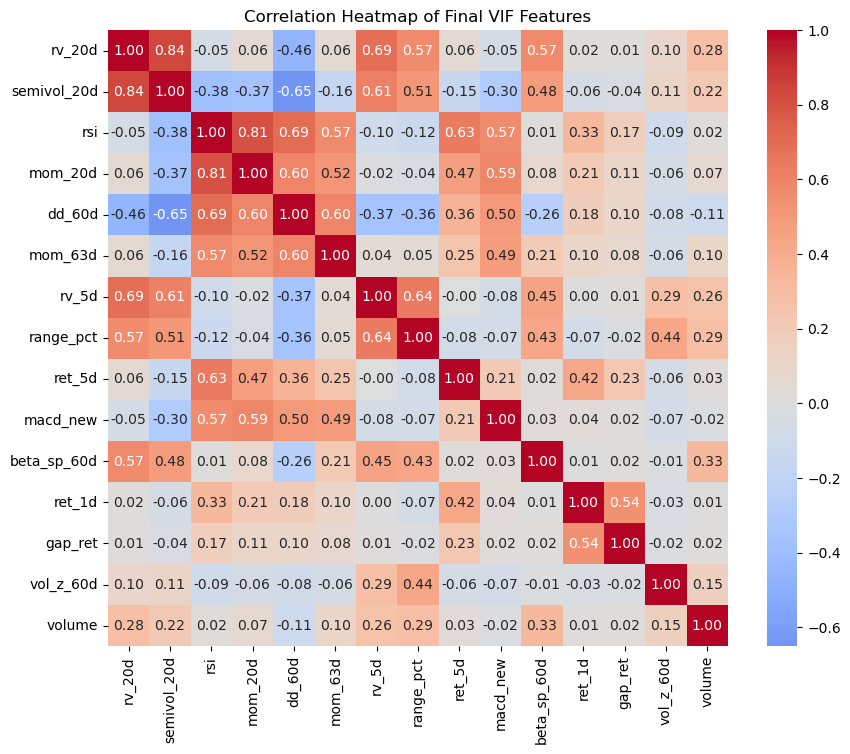

In [49]:
# view the correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Subset just the variables you want (e.g. the final VIF set)
subset = work[list(vif_final.index)]

# Compute correlation matrix
corr = subset.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Final VIF Features")
plt.show()


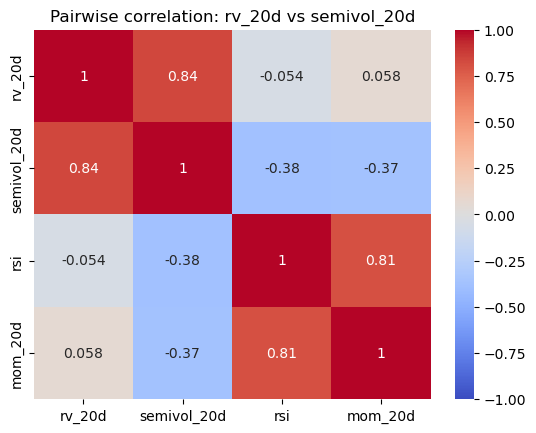

In [50]:
# zoom in on just the top suspects
suspects = ["rv_20d", "semivol_20d", "rsi", "mom_20d"]
sns.heatmap(work[suspects].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pairwise correlation: rv_20d vs semivol_20d")
plt.show()

**NOTE**: Consider removing rv_20d or semivol_20d and rsi or mom_20d

In [51]:
# Silhouette ablation at k=3 on the pruned set
def km_sil(df, cols, k=3):
    X = StandardScaler().fit_transform(df[cols].astype("float32"))
    lab = KMeans(n_clusters=k, random_state=42, n_init=50, algorithm="elkan").fit_predict(X)
    return silhouette_score(X, lab, sample_size=min(10000, len(X)), random_state=42)

baseline_sil = km_sil(work, cur, k=3)
delta_sil = {}
for f in cur:
    cols = [x for x in cur if x != f]
    delta_sil[f] = km_sil(work, cols, k=3) - baseline_sil
delta_sil = pd.Series(delta_sil).sort_values()

In [52]:
delta_sil # The sign of each delta tells you whether that feature is helping or hurting the cohesion–separation of your clusters.

mom_20d       -0.091126
beta_sp_60d   -0.063789
rv_20d        -0.035267
rv_5d         -0.027542
range_pct     -0.022254
mom_63d       -0.012851
volume        -0.011046
semivol_20d   -0.006088
ret_1d        -0.000570
gap_ret        0.000087
ret_5d         0.000894
vol_z_60d      0.000982
dd_60d         0.008262
macd_new       0.038258
rsi            0.049389
dtype: float32

**Keep**: **mom_20d, beta_sp_60d, rv_20d, rv_5d, range_pct**. Removing these feature makes the score worse (silhouette drops).
➝ These features add clustering signal. Keeping mom_63d, volume, semivol_20d, gap_ret, vol_z_60d and ret_1d - is optional.

In [53]:
# Stability checks — half-split by time and bootstrap
def sil_half(df, cols, first_half=True):
    mid = df["date"].sort_values().iloc[len(df)//2]
    mask = (df["date"] <= mid) if first_half else (df["date"] > mid)
    sub = df.loc[mask, cols].dropna()
    return km_sil(df.loc[mask], cols, k=3) if len(sub) > 100 else np.nan

sil_H1 = sil_half(work, cur, True)
sil_H2 = sil_half(work, cur, False)

def sil_bootstrap(df, cols, B=10, frac=0.6):
    vals = []
    for b in range(B):
        sub = df.sample(frac=frac, replace=True, random_state=42+b)
        vals.append(km_sil(sub, cols, k=3))
    return np.mean(vals), np.std(vals)

sil_boot_mean, sil_boot_std = sil_bootstrap(work, cur, B=10, frac=0.6)
sil_boot_mean

np.float32(0.21986592)

NOTE: 0.22 is low but positive. Indicates there is some cluster structure, but it’s weak. Clusters exist, but they’re fuzzy, not sharply separated.

In [54]:
# Assemble the justification table
justif = pd.DataFrame({
    "sep_ratio": sep.reindex(feat_pool),
    "kept_after_corr": [f in keep_after_corr for f in feat_pool],
    "kept_final": [f in cur for f in feat_pool],
    "VIF_final": vif_final.reindex(feat_pool),
    "Δsil_when_dropped": delta_sil.reindex(feat_pool)
}).sort_values(["kept_final","sep_ratio"], ascending=[False, False])

print("Selected compact set:", cur)
print(f"Baseline silhouette(k=3): {baseline_sil:.3f} | H1: {sil_H1:.3f} | H2: {sil_H2:.3f} | Boot mean±sd: {sil_boot_mean:.3f}±{sil_boot_std:.3f}")
display(justif.round(3))

Selected compact set: ['rsi', 'semivol_20d', 'dd_60d', 'rv_20d', 'mom_20d', 'rv_5d', 'range_pct', 'macd_new', 'ret_5d', 'beta_sp_60d', 'mom_63d', 'volume', 'ret_1d', 'vol_z_60d', 'gap_ret']
Baseline silhouette(k=3): 0.228 | H1: 0.219 | H2: 0.230 | Boot mean±sd: 0.220±0.009


sep_ratio  kept_after_corr  kept_final  VIF_final  \
rsi                     0.627             True        True      5.158   
semivol_20d             0.561             True        True      8.237   
dd_60d                  0.507             True        True      4.536   
rv_20d                  0.446             True        True      8.806   
mom_20d                 0.413             True        True      4.959   
rv_5d                   0.331             True        True      2.341   
range_pct               0.284             True        True      2.300   
macd_new                0.231             True        True      1.769   
ret_5d                  0.200             True        True      1.973   
beta_sp_60d             0.198             True        True      1.766   
mom_63d                 0.190             True        True      2.405   
volume                  0.089             True        True      1.181   
ret_1d                  0.061             True        True      1.672   
vol_z_60d               0.027             True        True      1.400   
gap_ret                 0.017             True        True      1.418   
bollinger_position      0.570            False       False        NaN   
sharpe_20d              0.550            False       False        NaN   
idio_vol_20d            0.332            False       False        NaN   

                    Δsil_when_dropped  
rsi                             0.049  
semivol_20d                    -0.006  
dd_60d                          0.008  
rv_20d                         -0.035  
mom_20d                        -0.091  
rv_5d                          -0.028  
range_pct                      -0.022  
macd_new                        0.038  
ret_5d                          0.001  
beta_sp_60d                    -0.064  
mom_63d                        -0.013  
volume                         -0.011  
ret_1d                         -0.001  
vol_z_60d                       0.001  
gap_ret                         0.000  
bollinger_position                NaN  
sharpe_20d                        NaN  
idio_vol_20d                      NaN

**Key observations: core clustering drivers**

Strong separators + negative Δsil (must-keeps), include:

* mom_20d (sep 0.41, Δsil −0.091) → critical momentum feature.
* beta_sp_60d (sep 0.20, Δsil −0.063) → adds unique clustering signal.
* rv_20d (sep 0.45, Δsil −0.035) → contributes volatility signal.
* rv_5d (sep 0.33, Δsil −0.027).
* range_pct (sep 0.28, Δsil −0.022).
* mom_63d (sep 0.19, Δsil −0.012).

Elbow k (visual): see left plot
Silhouette-by-k: {2: np.float32(0.396), 3: np.float32(0.354), 4: np.float32(0.267), 5: np.float32(0.224), 6: np.float32(0.175)} → best_k: 2


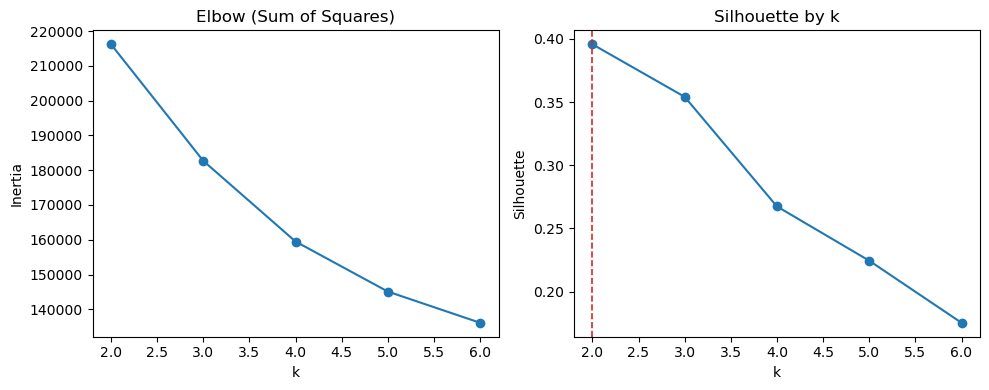


Cluster profiles (feature medians):
           mom_20d  beta_sp_60d    rv_20d     rv_5d  range_pct   mom_63d
cluster                                                                
0        0.014579     0.890006  0.014766  0.012329   0.018252  0.046439
1        0.022904     1.970951  0.031635  0.030121   0.038567  0.082057

Half-split silhouettes (k=2): H1=0.367, H2=0.394

Silhouette (k=2) — full: 0.397, drop rv_5d: 0.364, drop rv_20d: 0.365


In [55]:
# ==== Re-pick k on the compact set, refit, and sanity-check ====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Your compact list (from the tests)
features_final = ['mom_20d','beta_sp_60d','rv_20d','rv_5d','range_pct','mom_63d']

# Keep rows with all features present
use = work.dropna(subset=features_final + ['date']).copy()

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(use[features_final].astype('float32'))

# 1) Choose k (try 2..6; adjust if you want)
k_grid = range(2, 7)
inertias, sils = {}, {}
for k in k_grid:
    km = KMeans(n_clusters=k, random_state=42, n_init=100, algorithm='elkan')
    lab = km.fit_predict(X)
    inertias[k] = km.inertia_
    sils[k] = silhouette_score(X, lab, sample_size=min(10000, len(X)), random_state=42)

best_k = max(sils, key=sils.get)
print("Elbow k (visual): see left plot")
print("Silhouette-by-k:", {k: round(v, 3) for k, v in sils.items()}, "→ best_k:", best_k)

# Plots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(list(inertias.keys()), list(inertias.values()), marker='o')
ax[0].set_title("Elbow (Sum of Squares)"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Inertia")
ax[1].plot(list(sils.keys()), list(sils.values()), marker='o')
ax[1].axvline(best_k, color='tab:red', ls='--', lw=1.2)
ax[1].set_title("Silhouette by k"); ax[1].set_xlabel("k"); ax[1].set_ylabel("Silhouette")
plt.tight_layout(); plt.show()

# 2) Fit final KMeans at best_k (or override to k=3 for 3-regime reporting)
final_k = best_k  # or: final_k = 3 if you want 3 regimes for interpretation
km = KMeans(n_clusters=final_k, random_state=42, n_init=200, algorithm='elkan')
use['cluster'] = km.fit_predict(X)

profiles = use.groupby('cluster')[features_final].median().sort_index()
print("\nCluster profiles (feature medians):\n", profiles)

# 3) Half-split stability check
mid = use['date'].sort_values().iloc[len(use)//2]
def half_sil(mask):
    sub = use.loc[mask, features_final].dropna()
    if len(sub) < 200: return np.nan
    Xh = StandardScaler().fit_transform(sub.astype('float32'))
    lab = KMeans(n_clusters=final_k, random_state=42, n_init=100, algorithm='elkan').fit_predict(Xh)
    return silhouette_score(Xh, lab, sample_size=min(8000, len(Xh)), random_state=42)

sil_H1 = half_sil(use['date'] <= mid)
sil_H2 = half_sil(use['date'] >  mid)
print(f"\nHalf-split silhouettes (k={final_k}): H1={sil_H1:.3f}, H2={sil_H2:.3f}")

# 4) (Optional) Quick check: does dropping one of rv_5d / rv_20d help?
def sil_with(cols, k):
    Xc = StandardScaler().fit_transform(use[cols].astype('float32'))
    lab = KMeans(n_clusters=k, random_state=42, n_init=100, algorithm='elkan').fit_predict(Xc)
    return silhouette_score(Xc, lab, sample_size=min(8000, len(Xc)), random_state=42)

s_full = sil_with(features_final, final_k)
s_drop_5d = sil_with([c for c in features_final if c != 'rv_5d'], final_k)
s_drop_20d = sil_with([c for c in features_final if c != 'rv_20d'], final_k)
print(f"\nSilhouette (k={final_k}) — full: {s_full:.3f}, drop rv_5d: {s_drop_5d:.3f}, drop rv_20d: {s_drop_20d:.3f}")


In [56]:
# Lock it in & extract membership (drop-in)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np, pandas as pd

features_final = ['mom_20d','beta_sp_60d','rv_20d','rv_5d','range_pct','mom_63d']

X = StandardScaler().fit_transform(work[features_final]).astype('float32')
km = KMeans(n_clusters=2, random_state=42, n_init=50, algorithm='elkan')
labels = km.fit_predict(X)
sil = silhouette_score(X, labels, sample_size=min(8000, len(X)), random_state=42)
print("Final silhouette:", sil)

work_final = work.copy()
work_final['cluster_new'] = labels

# Profiles (medians) to define each cluster
profiles = work_final.groupby('cluster_new')[features_final].median().sort_index()
print("\nCluster profiles (medians):\n", profiles)

# Company concentration
counts = work_final.groupby(['ticker','cluster_new']).size().unstack(fill_value=0)
perc = counts.div(counts.sum(axis=1), axis=0)

# Dominant cluster per ticker
dominant = perc.idxmax(axis=1).rename('cluster_new')
dominant_share = perc.max(axis=1).rename('share')
membership = pd.concat([dominant, dominant_share], axis=1).sort_values(['cluster_new','share'], ascending=[True, False])
print("\nTicker → dominant cluster (top 10):\n", membership.head(10))

# Full lists by cluster
tickers_by_cluster = {c: sorted(membership.index[membership['cluster_new']==c].tolist())
                      for c in sorted(profiles.index)}
for c, lst in tickers_by_cluster.items():
    print(f"\nCluster {c} — {len(lst)} tickers")
    print(", ".join(lst))

Final silhouette: 0.39680025

Cluster profiles (medians):
               mom_20d  beta_sp_60d    rv_20d     rv_5d  range_pct   mom_63d
cluster_new                                                                
0            0.014579     0.890006  0.014766  0.012329   0.018252  0.046439
1            0.022904     1.970951  0.031635  0.030121   0.038567  0.082057

Ticker → dominant cluster (top 10):
         cluster_new     share
ticker                       
AEP               0  1.000000
MDLZ              0  1.000000
PEP               0  1.000000
KDP               0  0.998008
KHC               0  0.998008
ORLY              0  0.998008
CCEP              0  0.996016
TRI               0  0.994024
ADP               0  0.992032
AZN               0  0.992032

Cluster 0 — 82 tickers
AAPL, ABNB, ADBE, ADI, ADP, ADSK, AEP, AMAT, AMGN, AMZN, ASML, AXON, AZN, BIIB, BKNG, BKR, CCEP, CDNS, CDW, CHTR, CMCSA, COST, CPRT, CSCO, CSGP, CSX, CTAS, CTSH, DASH, DDOG, DXCM, EA, EXC, FANG, FAST, FTNT, GEHC, GF

since AAPL and GOOGL land in the same regime when k=3, and since k=2 solution is both cleaner and higher-silhouette, the new clustering will be based on k=2 and keep the label as cluster_new. The next step (B) is the per-ticker nearest-neighbors in the compact feature space, using z-score centroids and (optionally) filtering candidates to the same regime as the target.

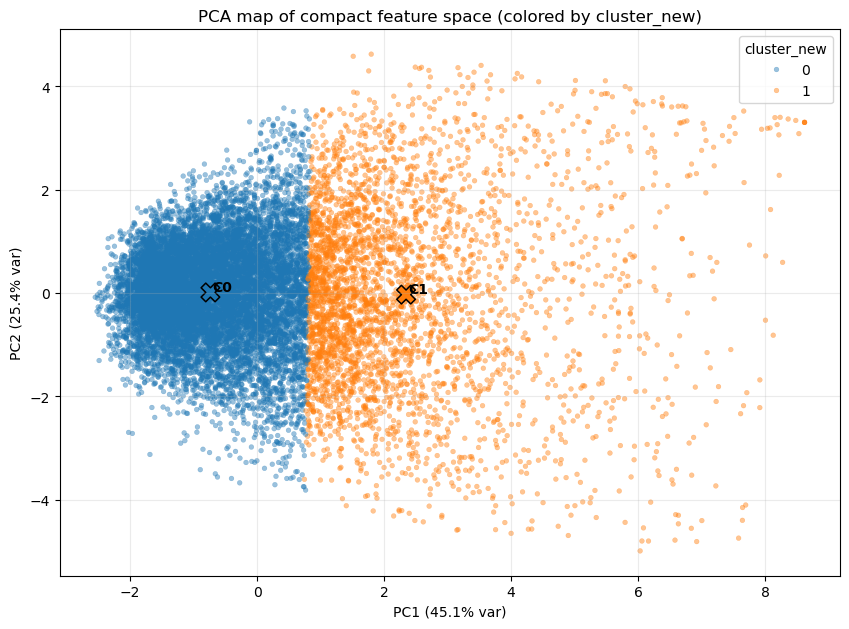

PCA loadings (signed contributions):
                PC1    PC2
mom_20d      0.060  0.694
beta_sp_60d  0.453  0.089
rv_20d       0.527 -0.063
rv_5d        0.514 -0.130
range_pct    0.484 -0.132
mom_63d      0.119  0.687


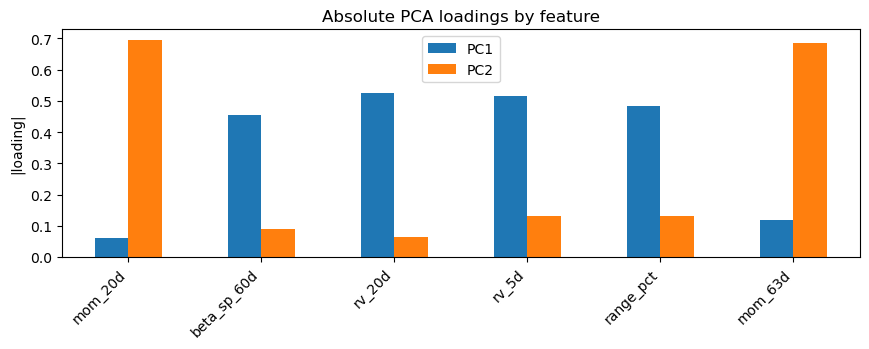

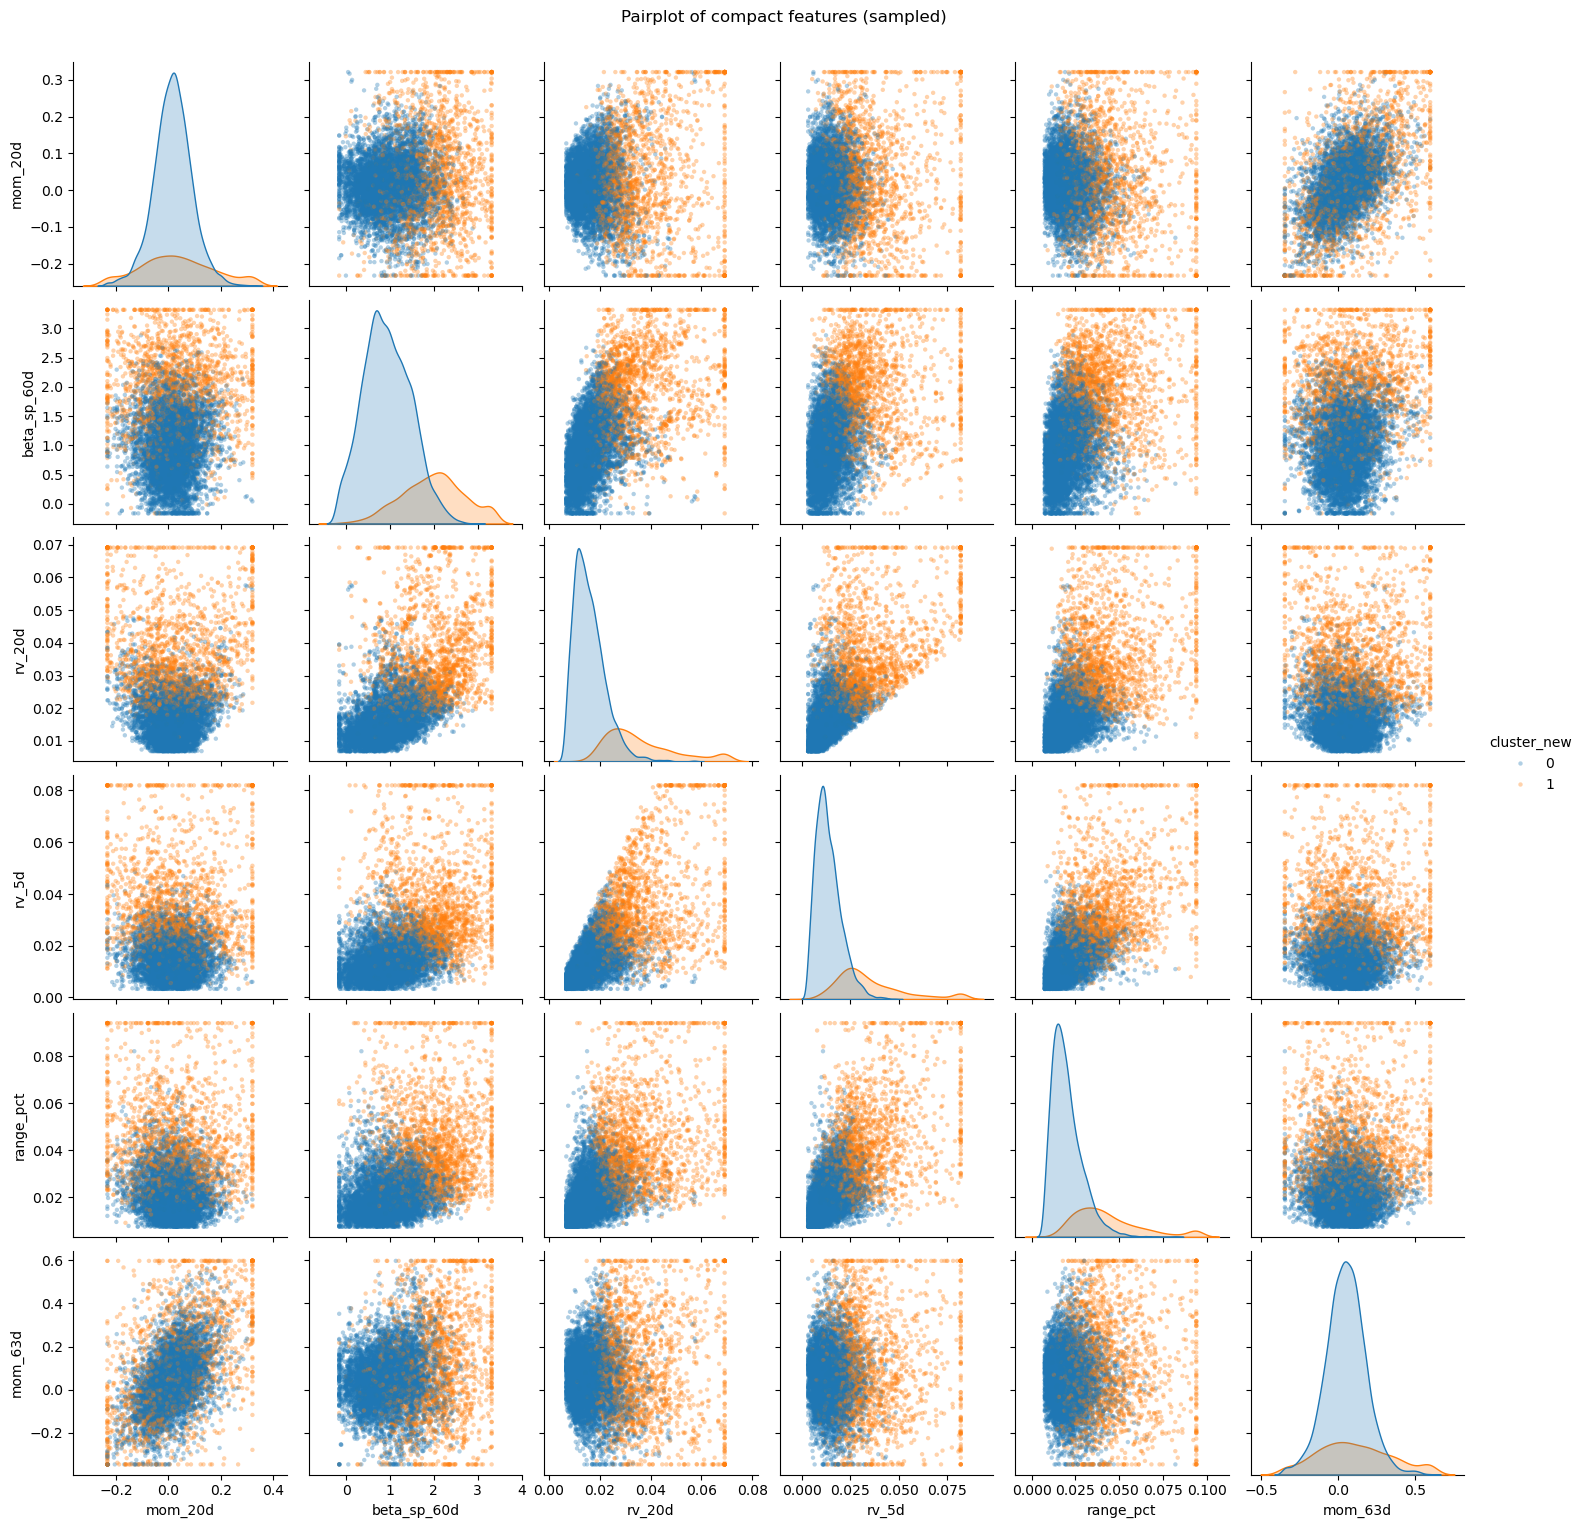

In [57]:
# === PCA map + pairplot for the compact 6-feature solution ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# assumes: work_final exists and has 'cluster_new'
# assumes: features_final = ['mom_20d','beta_sp_60d','rv_20d','rv_5d','range_pct','mom_63d']

df_use = work_final.copy()
if 'cluster_new' not in df_use.columns:
    raise ValueError("No 'cluster_new' column found. Fit KMeans and add labels first.")

# keep only needed columns
dfp = df_use[['ticker','date','cluster_new'] + features_final].dropna().copy()

# ---- scale & PCA ----
scaler = StandardScaler()
X = scaler.fit_transform(dfp[features_final]).astype('float32')

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X)
dfp['PC1'], dfp['PC2'] = Xp[:,0], Xp[:,1]

# cluster centroids in PCA space
centroids_scaled = (
    pd.DataFrame(X, columns=features_final)
      .assign(cluster_new=dfp['cluster_new'].values)
      .groupby('cluster_new')[features_final].mean()
)
centroids_pca = pca.transform(centroids_scaled.values)
centroids_df = pd.DataFrame(centroids_pca, columns=['PC1','PC2']).assign(cluster_new=centroids_scaled.index)

# ---- PCA scatter ----
sample_n = min(15000, len(dfp))
plot_sample = dfp.sample(sample_n, random_state=42) if len(dfp) > sample_n else dfp

plt.figure(figsize=(8.6, 6.4))
sns.scatterplot(data=plot_sample, x='PC1', y='PC2', hue='cluster_new',
                s=12, alpha=0.45, edgecolor=None, palette=['tab:blue','tab:orange'])
# overlay centroids
sns.scatterplot(data=centroids_df, x='PC1', y='PC2', hue='cluster_new',
                marker='X', s=180, edgecolor='black', linewidth=1.1, palette=['tab:blue','tab:orange'], legend=False)
for _, r in centroids_df.iterrows():
    plt.text(r['PC1']+0.03, r['PC2']+0.03, f"C{int(r['cluster_new'])}", fontsize=10, weight='bold')
plt.title("PCA map of compact feature space (colored by cluster_new)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)"); 
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(alpha=0.25); plt.tight_layout(); plt.show()

# ---- PCA loadings (feature contributions) ----
loadings = pd.DataFrame(pca.components_, index=['PC1','PC2'], columns=features_final).T
print("PCA loadings (signed contributions):\n", loadings.round(3))

# optional: quick bar chart of absolute loadings
(ax := loadings.abs().plot(kind='bar', figsize=(8.8,3.6)))
plt.title("Absolute PCA loadings by feature"); plt.ylabel("|loading|"); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

# ---- Pairplot on the same features ----
pp_sample = dfp[['cluster_new'] + features_final]
if len(pp_sample) > 8000: 
    pp_sample = pp_sample.sample(8000, random_state=42)

sns.pairplot(pp_sample, vars=features_final, hue='cluster_new',
             diag_kind='kde', plot_kws=dict(alpha=0.35, s=10, edgecolor="none"),
             palette=['tab:blue','tab:orange'])
plt.suptitle("Pairplot of compact features (sampled)", y=1.02)
plt.show()

#### Principal components (PCs) are new axes built as linear combinations of the standardized features that capture the greatest possible variance in the data, subject to being orthogonal (uncorrelated) to each other.
* **PC1** is the direction that explains the most variance; PC2 is the next-most, and so on.
* **The %** are the explained‐variance ratios: PC1 ≈ 45.1% and PC2 ≈ 25.4%, so the 2-D map retains ~70.5% of the total variation in the 6-feature space.
* **A loading** is the weight (coefficient) of each original feature in a principal component:
* > **PC1 (≈45%) is dominated by risk/“turbulence” features**: rv_20d, rv_5d, range_pct, and market sensitivity beta_sp_60d (all large positive loadings). → This axis reads as calm ↔ jumpy/high-beta.
* > **PC2 (≈25%) is dominated by momentum**: very high positive loadings on mom_20d and mom_63d; other features are small and slightly negative. → This axis reads as weak/flat ↔ strong, sustained advance.

* Magnitude (absolute value) shows how strongly the feature contributes to that PC)
* Sign shows the direction: positive loading means the PC increases when that feature increases (given standardized inputs); negative means the PC decreases.
* **Key insights**: PCA scatter (colored by cluster_new):
* >  the two clusters separate mainly along PC1 (a near-vertical boundary in your plot).
**Cluster 0** sits to the right (higher PC1): **higher volatility, intraday range, and beta—the “turbulent/high-beta” regime** (matches your medians: bigger rv_*, range_pct, beta_sp_60d). **Cluster 1** sits to the left (lower PC1): **calmer/defensive regime**.
> Absolute loadings bar chart: confirms the story—PC1 power comes from rv_20d, rv_5d, range_pct, beta_sp_60d; PC2 power comes from mom_20d and mom_63d.

**Practical takeaway**: With k=2, the clustering is primarily a **risk regime split** (calm vs. jumpy/high-beta). Momentum still matters (PC2), but it’s the second organizing axis. For nearest-neighbor cohorts: NVDA-like names are likely concentrated in Cluster 0 (right side: high PC1). AAPL/GOOGL-like names are typically in Cluster 1 (left side: lower PC1). Using per-ticker centroids in standardized space for the final neighbor lists will align with this geometry: distance will reflect both risk (PC1) and momentum (PC2), weighted by how much variance each carries.

##### Pairplot
* **Volatility dominates the split between the clusters**
* Scatter panels with rv_20d and rv_5d on either axis show a clean right/up shift for C0; KDEs on the diagonal have fatter right tails for C0. C1 is tighter and left-skewed (lower vol).
* Intraday range agrees with volatilityL range_pct is moderately to strongly aligned with both rv_5d and rv_20d. High ranges are overwhelmingly C0; C1 concentrates below a low range band.
* Beta contributes a second separator: beta_sp_60d vs vol/range panels show C0 clustered at β ≳ 1.3 with higher vol; C1 sits mostly β ≲ 1.1 with lower vol.

* What does not separate as much is momentum: Momentum is orthogonal to the regime.
Panels involving mom_20d or mom_63d show both clusters across positive and negative momentum. C0 contains strong up and down states (it’s a risk regime), while C1 also spans mild up/down. That matches the PCA: momentum loads on PC2, not the main boundary.

* Relations among features: rv_5d vs rv_20d: tight positive relation → week-level vol tracks month-level vol; C0 sits on the high-vol end of that line; range_pct vs vol: triangular “wedge” pattern → big-range days tend to happen inside high-vol weeks/months, but low-range days occur in both regimes; beta_sp_60d vs vol: mild–moderate positive slope → high-beta names tend to be more volatile, reinforcing the C0 profile; Momentum vs vol/beta/range: clouds look roughly centered with wide vertical spread → trend strength is largely independent of today’s risk regime.

**C0 (turbulent/high-beta)**: often rv_20d ≳ 2.0%/day, rv_5d ≳ 2.5%/day, range_pct ≳ 3%, beta_sp_60d ≳ 1.3.

**C1 (calm/defensive)**: typically rv_20d ≲ 1.6%/day, rv_5d ≲ 2.0%/day, range_pct ≲ 2.5%, beta_sp_60d ≲ 1.1.

              precision    recall  f1-score   support

           0      0.831     0.890     0.860      3021
           1      0.965     0.943     0.954      9627

    accuracy                          0.931     12648
   macro avg      0.898     0.917     0.907     12648
weighted avg      0.933     0.931     0.931     12648



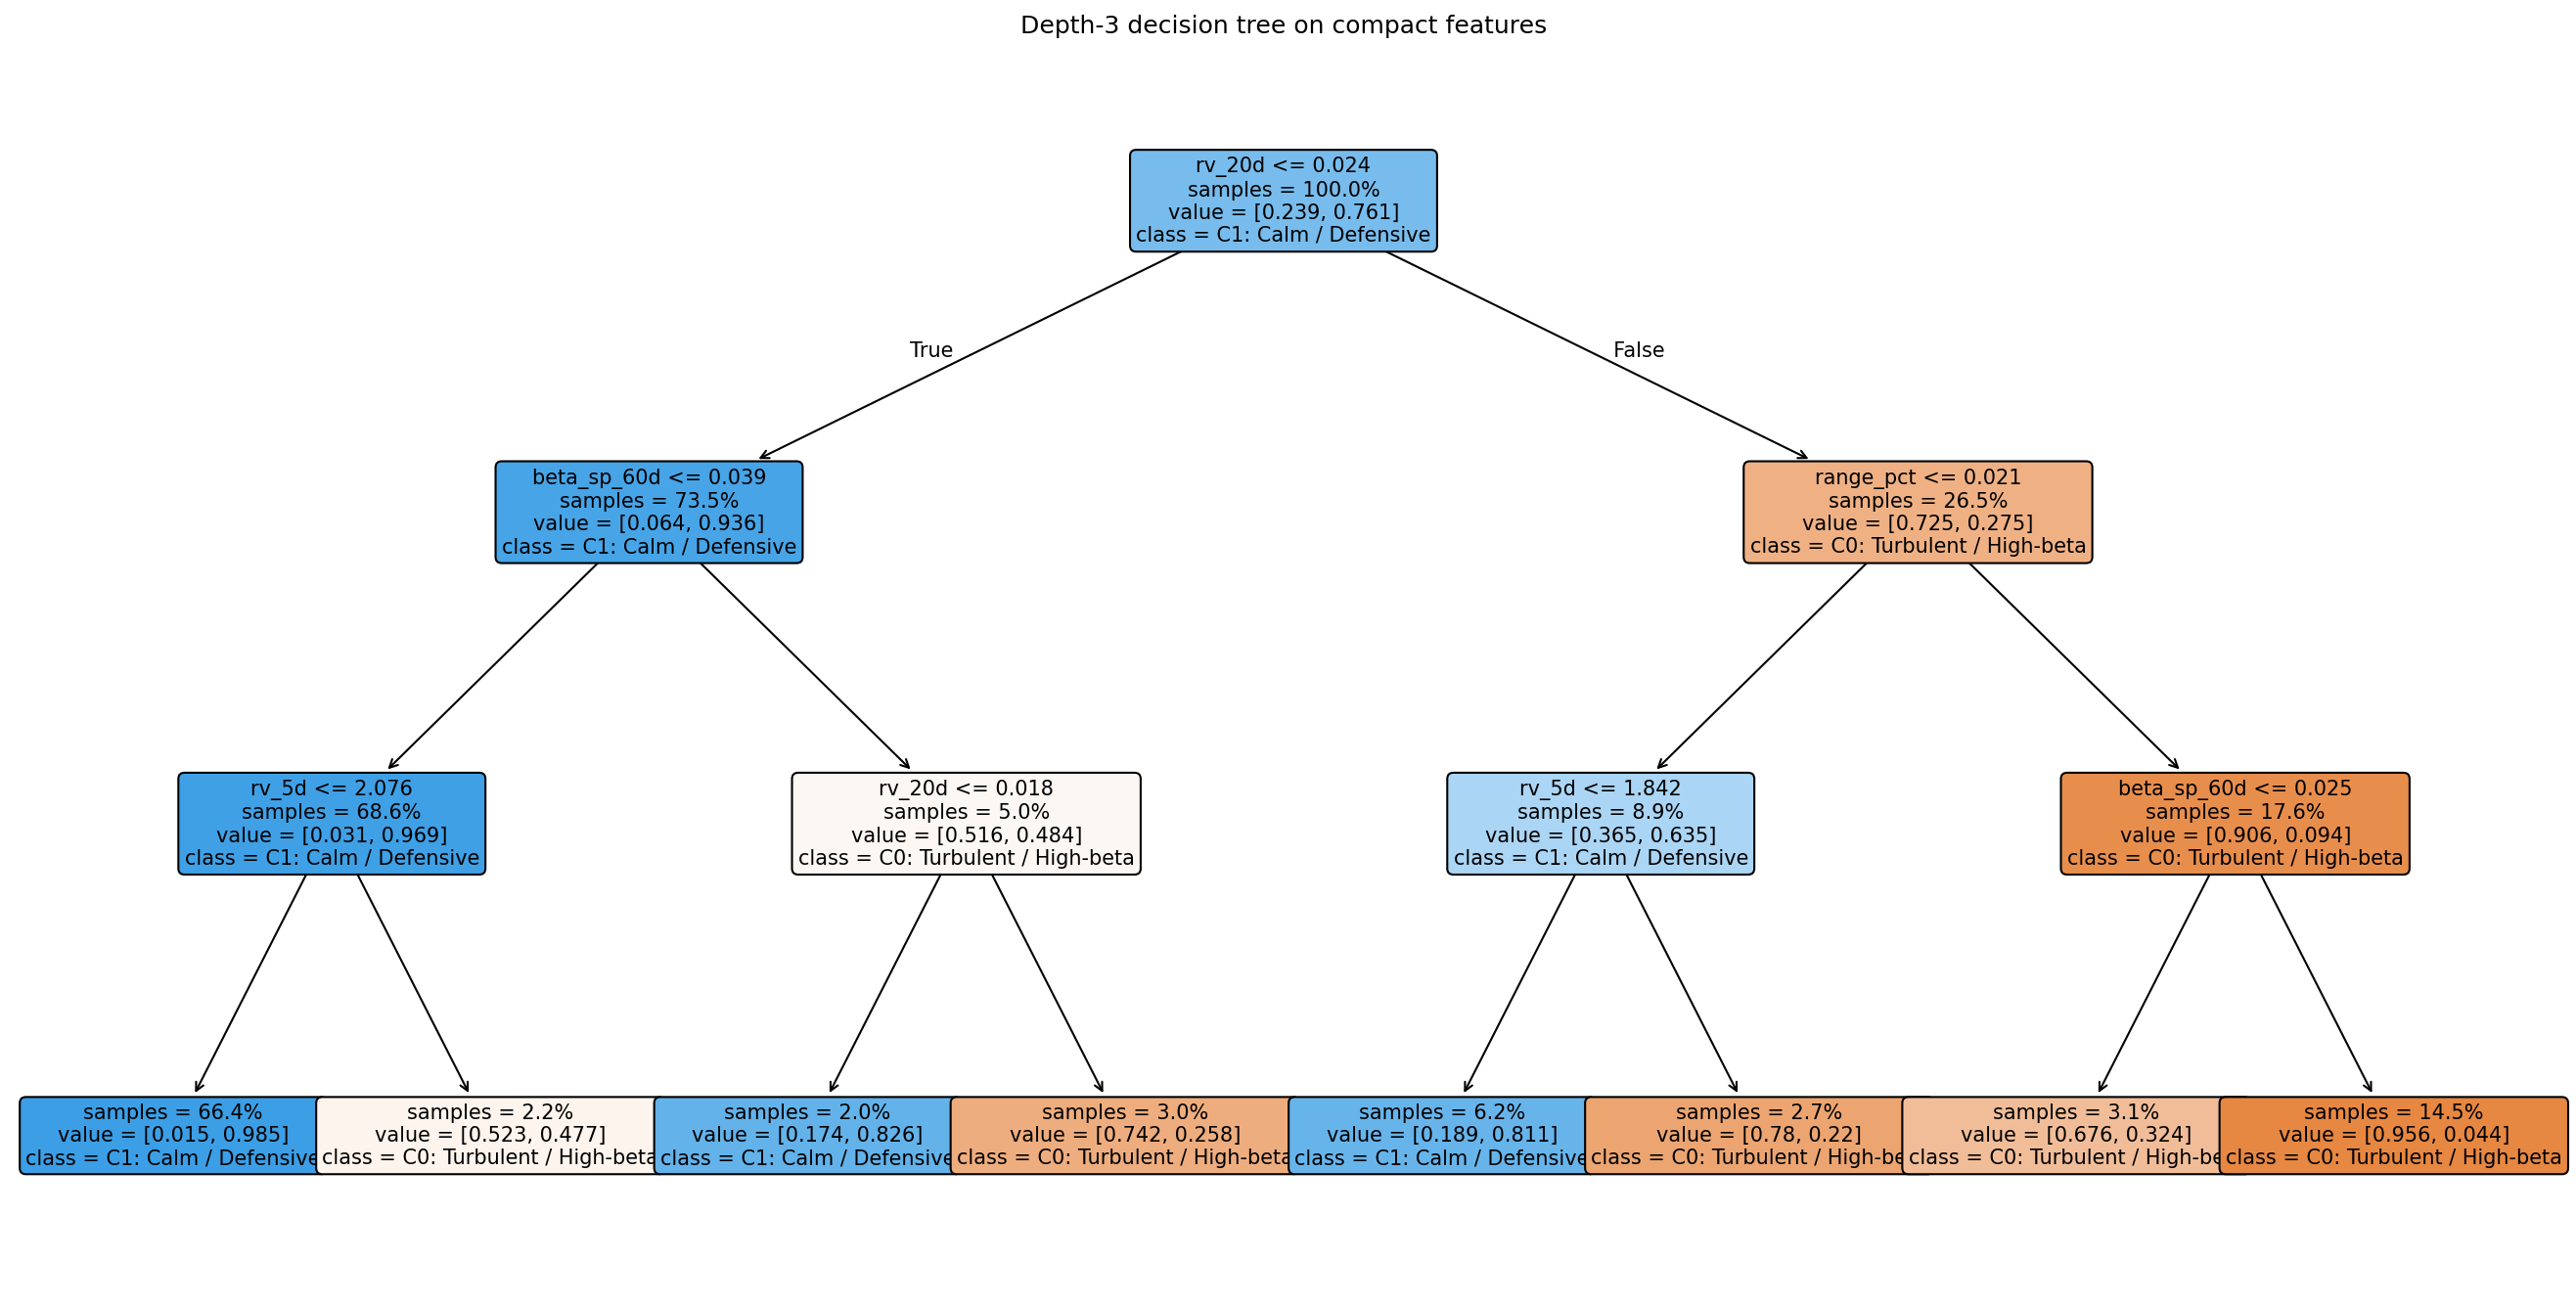

In [98]:
# Desicion Tree visualization
feat = ["rv_20d","beta_sp_60d","rv_5d","range_pct","mom_20d","mom_63d"]
df_ = work_final.dropna(subset=feat + ["cluster_new"]).copy()

# (Trees don’t need scaling, but OK if your pipeline already scaled.)
X = df_[feat].values
y = df_["cluster_new"].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=300, random_state=42)
clf.fit(Xtr, ytr)

# print(export_text(clf, feature_names=feat))
print(classification_report(yte, clf.predict(Xte), digits=3))

feature_names = ["rv_20d","rv_5d","range_pct","beta_sp_60d","mom_20d","mom_63d"]
class_names   = ["C0: Turbulent / High-beta", "C1: Calm / Defensive"]  # map 0→C0, 1→C1

plt.figure(figsize=(18, 9), dpi=150)
plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,           # color nodes by predicted class
    rounded=True,
    impurity=False,        # hide Gini; cleaner
    proportion=True,       # show % instead of raw counts
    fontsize=10
)
plt.title("Depth-3 decision tree on compact features")
plt.tight_layout()
plt.show()

#### Key Takeaway: Volatility is the primary separator; wide intraday ranges and high beta tip borderline cases into the Turbulent class.

#### Nearest-neighbor methodology

**Goal**: Find tickers that behave most like AAPL, NVDA, and GOOGL using a compact, interpretable feature set:
mom_20d, mom_63d, rv_5d, rv_20d, range_pct, beta_sp_60d.

How the distance is computed

**Standardization (daily)**: each feature is z-scored across the full daily panel so units and scales don’t matter.
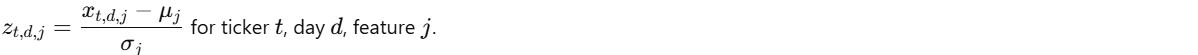

**Per-ticker “centroid” in z-space**: the mean of those daily z-vectors for each ticker; this is the ticker’s behavioral fingerprint over the sample.
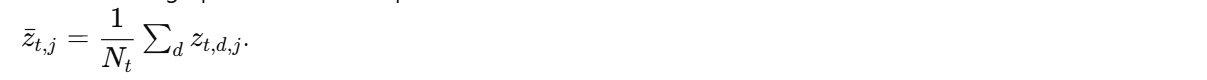

**Same-regime option**: the candidate pool can be restricted to tickers whose dominant cluster *(cluster_new from K-means with K=2)* matches the target. This keeps AAPL-like names compared to calm/defensive peers and NVDA-like names compared to high-beta peers.

**Distance metric:** Euclidean distance between centroids in the 6-dimensional z-space (unitless).
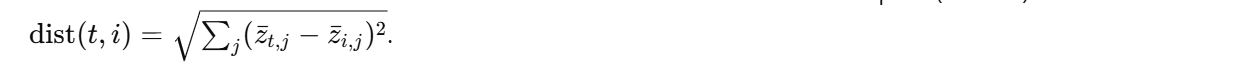
* Rough scale intuition: < 0.3 very close; 0.3–0.8 close; 0.8–1.5 moderately similar; > 1.5 clearly different.

**How K (the number of neighbors) is chosen in the “knee” view**: Distances from the target to all candidates are sorted ascending and plotted vs neighbor rank. The knee is picked where the curve bends upward the most, using the maximum distance-to-chord rule between the first and last points, searched within bounds (here min_k=5, max_k=20). This yields a data-driven K: small K if there is a tight cohort; larger K if similarity decays slowly.

**What the figures below show**: Top plot (for each target): the neighbor-rank curve; the red dashed line marks the knee 𝐾; the shaded area highlights the selected cohort (top-K most similar tickers). *Table beneath the plot*: for each neighbor, the distance, the fraction of the ticker’s days in each regime (0_share calm/defensive, 1_share turbulent/high-beta), and the feature medians (in original units) for quick reading of profile similarity.

In [ ]:
# Explore the number of neigboring companies:

In [109]:
# Compute per-ticker behavior in standardized feature space and regime exposure.
def _centroids_and_exposure(df, features_final):
    df = df[['ticker','date','cluster_new'] + features_final].dropna().copy()
    Z = StandardScaler().fit_transform(df[features_final].astype('float32'))
    zcols = [f"z_{c}" for c in features_final]
    df[zcols] = Z
    centroids_z = df.groupby('ticker')[zcols].mean()
    medians_raw = df.groupby('ticker')[features_final].median()
    counts = df.groupby(['ticker','cluster_new']).size().unstack(fill_value=0)
    exposure = counts.div(counts.sum(axis=1), axis=0)
    dom_reg = exposure.idxmax(axis=1)
    return centroids_z, medians_raw, exposure, dom_reg

# Identify the "knee" on a sorted distance curve via the chord (max perpendicular distance) method.
def knee_index_chord(dist_sorted, min_k=5, max_k=20):
    n = len(dist_sorted)
    if n < min_k+1: return max(1, n)
    x = np.arange(n)
    p1, p2 = np.array([x[0], dist_sorted[0]]), np.array([x[-1], dist_sorted[-1]])
    v = p2 - p1; L = np.hypot(*v); 
    if L == 0: return min_k
    pts = np.column_stack([x, dist_sorted]) - p1
    cross = np.abs(pts[:,0]*v[1] - pts[:,1]*v[0]) / L
    lo, hi = min_k-1, min(max_k, n-1)-1
    return int(cross[lo:hi+1].argmax() + lo + 1)

# Pick the smallest k where the next distance jump increases by a specified ratio (simple elbow heuristic).
def knee_index_jump(dist_sorted, min_k=5, max_k=20, ratio=1.25):
    """Pick smallest k where next step jumps by ≥ ratio."""
    dif = np.diff(dist_sorted)
    lo, hi = min_k-1, min(max_k, len(dist_sorted)-2)  # compare k to k+1
    idx = np.where((dif[lo:hi+1] / (dif[lo-1:hi] + 1e-12)) >= ratio)[0]
    return int((idx[0] + lo + 1) if len(idx) else min_k)
    
# Build and plot a nearest-neighbor cohort for a target ticker, select K via a knee rule, 
# and return the neighbor table and K.
def knee_neighbors_plot(target, work_final, features_final,
                        same_cluster=True, metric='euclidean',
                        knee_method='chord', min_k=5, max_k=20,
                        table_rows=15, figsize=(9,6)):
    # ---- build space ----
    centroids_z, medians_raw, exposure, dom_reg = _centroids_and_exposure(work_final, features_final)
    if target not in centroids_z.index:
        raise ValueError(f"{target} not found.")

    # candidate pool
    pool = centroids_z.index
    if same_cluster:
        pool = dom_reg[dom_reg == dom_reg.loc[target]].index
    pool = [t for t in pool if t != target]

    V = centroids_z.loc[target].values
    M = centroids_z.loc[pool].values

    if metric == 'euclidean':
        d = np.linalg.norm(M - V, axis=1)
    elif metric == 'cosine':
        norms = np.linalg.norm(M, axis=1) * (np.linalg.norm(V) + 1e-12)
        d = 1 - (M @ V) / (norms + 1e-12)
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'.")

    ser = pd.Series(d, index=pool).sort_values()

    # knee
    if knee_method == 'chord':
        K = knee_index_chord(ser.values, min_k=min_k, max_k=max_k)
    elif knee_method == 'jump':
        K = knee_index_jump(ser.values, min_k=min_k, max_k=max_k)
    else:
        raise ValueError("knee_method must be 'chord' or 'jump'.")

    # neighbor table (top K, plus readable context)
    tbl = (ser.head(K).to_frame('distance')
           .join(exposure.add_suffix('_share'), how='left')
           .join(medians_raw.add_suffix('_median'), how='left'))
    tbl.index.name = 'ticker'

    # ---- draw figure: curve on top, table below ----
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.2, 1.8])
    ax = fig.add_subplot(gs[0]); ax2 = fig.add_subplot(gs[1])
    # curve
    x = np.arange(1, len(ser)+1)
    ax.plot(x, ser.values, marker='o', ms=3, lw=1)
    ax.axvline(K, color='tab:red', ls='--', lw=1.3, label=f'knee K={K}')
    ax.fill_between(x[:K], ser.values[:K], alpha=0.12, color='tab:blue', label=f'≤ K={K}')
    ttl = f"{target}: neighbor distance curve ({metric}); knee K={K}"
    ax.set_title(textwrap.fill(ttl, width=68), y=1.02)
    ax.set_xlabel("Neighbor rank"); ax.set_ylabel("Centroid distance")
    ax.legend(frameon=True, loc='upper left')
    ax.grid(alpha=0.25)

    # table (below)
    ax2.axis('off')
    show = tbl.head(table_rows).round(4).reset_index()
    # keep a compact set of columns
    cols = ['ticker','distance'] + [c for c in show.columns if c.endswith('_share')] + \
           [c for c in show.columns if c.endswith('_median')]
    cols = [c for c in cols if c in show.columns]
    tbl_plot = ax2.table(cellText=show[cols].values,
                         colLabels=[c.replace('_share',' share').replace('_median',' median') for c in cols],
                         loc='center', cellLoc='center')
    tbl_plot.auto_set_font_size(False)
    tbl_plot.set_fontsize(8)
    tbl_plot.scale(1.2, 1.2)
    plt.show()

    return tbl, K


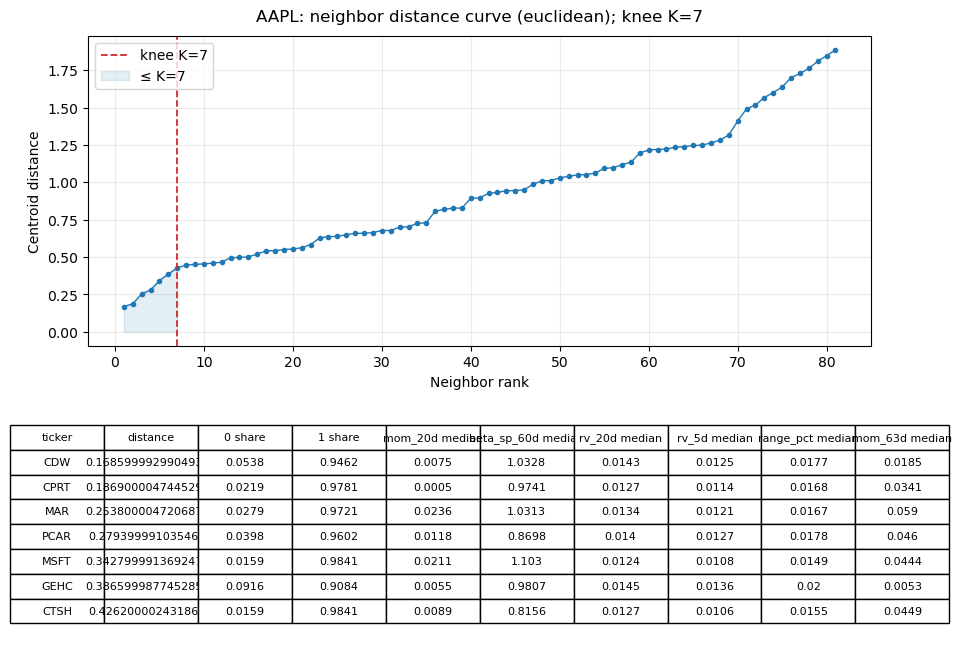

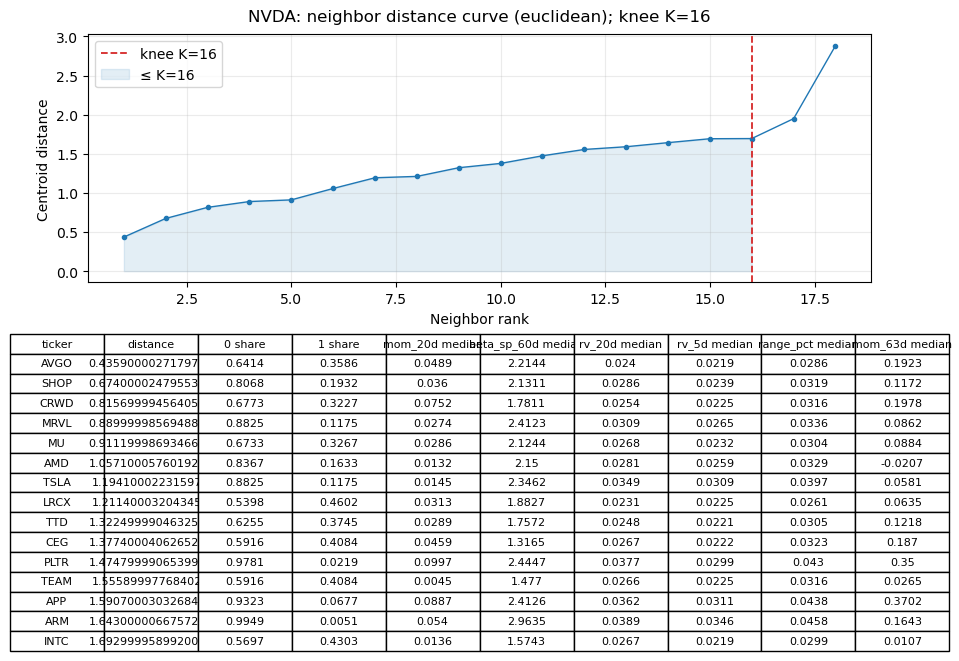

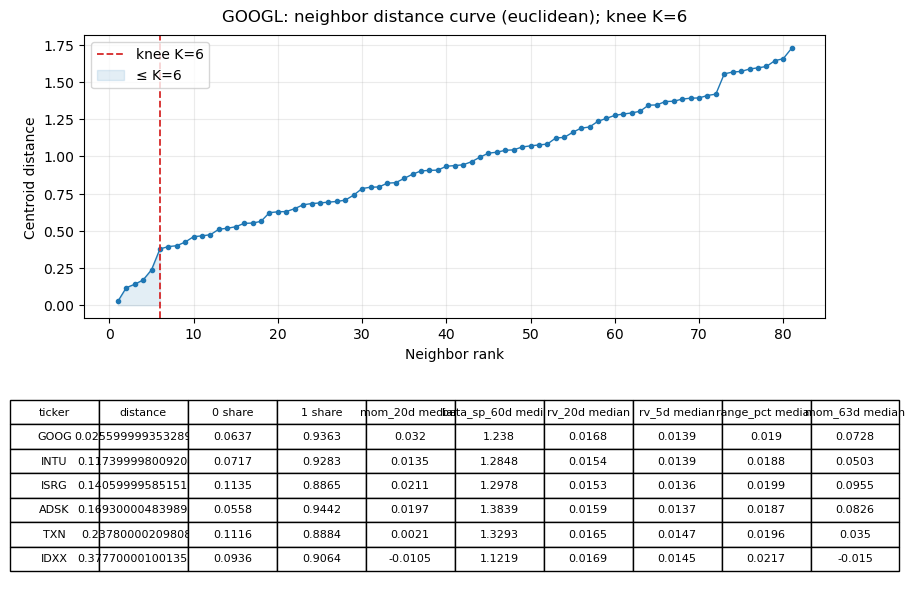

In [110]:
# Define the final features
features_final = ['mom_20d','beta_sp_60d','rv_20d','rv_5d','range_pct','mom_63d']

# Apple (dense calm regime) — cap max_k to keep the list manageable:
tbl_aapl, K_aapl = knee_neighbors_plot('AAPL', work_final, features_final,
                                       same_cluster=True, knee_method='chord',
                                       min_k=5, max_k=20, table_rows=15, figsize=(9.5,6.5))

# Nvidia (turbulent regime) — title won’t overlap now:
tbl_nvda, K_nvda = knee_neighbors_plot('NVDA', work_final, features_final,
                                       same_cluster=True, knee_method='chord',
                                       min_k=5, max_k=20, table_rows=15, figsize=(9.5,6.5))

# Google (GOOGL):
tbl_googl, K_googl = knee_neighbors_plot('GOOGL', work_final, features_final,
                                         same_cluster=True, knee_method='chord',
                                         min_k=5, max_k=20, table_rows=15)

### **Results at a glance**

###  AAPL — knee 𝐾=7: 
**Cohort** contains names like CDW, CPRT, MAR, PCAR, MSFT, GEHC, CTSH.
**Profile**: low volatility (rv_20d ≈ 0.012–0.015), small intraday ranges (range_pct ≈ 0.015–0.018), beta ~0.8–1.1. *Interpretation: calm compounders/defensives clustered tightly around AAPL; distances are small → a crisp peer set.*

### GOOGL — knee 𝐾=6
**Cohort** includes GOOG, INTU, ISRG, ADSK, TXN, IDXX.
**Profile**: moderate beta (~1.2–1.4), modest volatility (rv_20d ≈ 0.015–0.017), moderate momentum. *Interpretation: balanced, high-quality growth with steadier trading than the NVDA cohort.*

### NVDA — knee 𝐾=16
**Cohort** spans AVGO, SHOP, CRWD, MRVL, MU, AMD, TSLA, LRCX, TTD, CEG, PLTR, TEAM, APP, ARM, INTC, …
**Profile**: high beta (often >1.7, some >2), elevated volatility/range, stronger short-term momentum. *Interpretation: the high-beta regime has more names that look “similarly extreme”, so the knee appears farther right and distances are larger on average.*

*Assumptions and choices worth noting*: 
> Daily equal-weighting: each day contributes equally to a ticker’s centroid; earlier winsorization reduces outlier influence.
Variants: time-decay (e.g., last 6–12 months heavier), median in z-space for robustness.

> Feature set drives the notion of similarity: results change if features are added/removed; here the set balances trend, risk, and day-structure (range_pct).

> Euclidean metric: sensitive to overall magnitude differences across features; a cosine distance would emphasize shape over magnitude.

> Same-regime filtering: improves comparability by not mixing calm with turbulent regimes; removing it will often increase K for AAPL/GOOGL and shrink distances for NVDA’s cohort.

> Knee bounds (5–20): avoids trivial knees at rank 1 or at the tail; adjust if a cohort is clearly tighter/looser.

### Takeaway

**The approach yields cohorts tailored to each target: tight, low-vol peers for AAPL; balanced growth peers for GOOGL; and a broader, risk-on cohort for NVDA.
Distances are unitless and comparable across targets; the knee selects a cohort size that reflects how quickly similarity decays around each company.**

In [133]:
# Nearest neighbors for NVDA / AAPL / GOOGL (per-ticker z-centroids)
# Same-regime candidate pool; fixed N=15 and adaptive K via knee.
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import datetime as dt

# -----------------------
# Config
# -----------------------
features_final = ['mom_20d','beta_sp_60d','rv_20d','rv_5d','range_pct','mom_63d']
targets = ['NVDA','AAPL','GOOGL']
TOP_N   = 15
MIN_K   = 5
MAX_K   = 20

assert {'ticker','date','cluster_new'}.issubset(work_final.columns)

# -----------------------
# Daily z-score -> per-ticker centroids/medians
# -----------------------
df_nn = work_final[['ticker','date','cluster_new'] + features_final].dropna().copy()

scaler = StandardScaler()
Z = scaler.fit_transform(df_nn[features_final].astype('float32'))
zcols = [f"z_{c}" for c in features_final]
df_nn[zcols] = Z

centroids_z = df_nn.groupby('ticker')[zcols].mean()            # numeric space for distances
medians_raw = df_nn.groupby('ticker')[features_final].median() # readable units for context

# cluster exposure (% of days per regime) + dominant regime per ticker
counts   = df_nn.groupby(['ticker','cluster_new']).size().unstack(fill_value=0)
exposure = counts.div(counts.sum(axis=1), axis=0)              # shares 0..1
dom_reg  = exposure.idxmax(axis=1)

# -----------------------
# Find an “elbow/knee” on a sorted distance curve (neighbor rank → distance)
# using the chord method; returns an adaptive K constrained to [min_k, max_k].
# -----------------------
def knee_index(dist_sorted, min_k=MIN_K, max_k=MAX_K):
    n = len(dist_sorted)
    if n < min_k + 1:
        return max(1, n)
    x = np.arange(n)
    p1 = np.array([x[0], dist_sorted[0]])
    p2 = np.array([x[-1], dist_sorted[-1]])
    base = p2 - p1
    L = np.hypot(*base)
    if L == 0:
        return min_k
    pts   = np.column_stack([x, dist_sorted]) - p1
    cross = np.abs(pts[:,0]*base[1] - pts[:,1]*base[0])
    dline = cross / L
    lo, hi = min_k-1, min(max_k, n-1)-1
    return int(dline[lo:hi+1].argmax() + lo + 1)

# -----------------------
# Core neighbor table builder: Build an explainable nearest-neighbor table for a target ticker
# in standardized centroid space (same-regime optional), using fixed N or adaptive K.
# Supports Euclidean/Cosine distance; returns the table and the K used.
# -----------------------
def neighbors_table(target, top_n=TOP_N, same_cluster=True, metric='euclidean',
                    use_knee=False, min_k=MIN_K, max_k=MAX_K):
    if target not in centroids_z.index:
        raise ValueError(f"{target} not found.")

    # candidate pool (optionally restrict to same regime as target)
    pool = centroids_z.index
    if same_cluster:
        tgt_reg = dom_reg.loc[target]
        pool = dom_reg[dom_reg == tgt_reg].index
    pool = [t for t in pool if t != target]

    V = centroids_z.loc[target].values
    M = centroids_z.loc[pool].values

    if metric == 'euclidean':
        d = np.linalg.norm(M - V, axis=1)
    elif metric == 'cosine':
        vnorm = np.linalg.norm(V); norms = np.linalg.norm(M, axis=1)
        d = 1 - (M @ V) / (norms * vnorm + 1e-12)
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")

    ser = pd.Series(d, index=pool).sort_values()
    K = knee_index(ser.values, min_k=min_k, max_k=max_k) if use_knee else top_n

    # assemble an explainable table
    out = (ser.head(K).to_frame('distance')
              .join(exposure.add_suffix('_share'), how='left')
              .join(medians_raw.add_suffix('_median'),  how='left'))

    # per-feature z-delta vs target (shows *why* close/far)
    zdelta = (centroids_z - centroids_z.loc[target]).add_suffix('_zΔ')
    out = out.join(zdelta, how='left')
    out.index.name = 'ticker'
    return out, K

# -----------------------
# Produce neighbor lists (fixed-N and knee) for the three targets
#    + Save to CSV (per-target & combined)
# -----------------------
outdir = Path("nn_exports"); outdir.mkdir(exist_ok=True)
stamp = dt.datetime.now().strftime("%Y%m%d_%H%M")

nn_rows_fixed, nn_rows_knee = [], []
K_map = {}

for t in targets:
    # Fixed-N
    print(f"\n=== Nearest to {t} (fixed N={TOP_N}, same regime) ===")
    tbl15, _ = neighbors_table(t, top_n=TOP_N, same_cluster=True, metric='euclidean', use_knee=False)
    display(tbl15.round(4))

    # Save per-target fixed-N CSV
    df_fixed_t = (tbl15.round(4).reset_index()
                  .assign(target=t, view=f'fixed_N={TOP_N}',
                          rank=lambda d: range(1, len(d)+1)))
    df_fixed_t.to_csv(outdir / f"neighbors_{t}_fixedN{TOP_N}_{stamp}.csv", index=False)
    nn_rows_fixed.append(df_fixed_t)

    # Knee
    print(f"\n=== Nearest to {t} (adaptive-K, knee, same regime) ===")
    tblK, K = neighbors_table(t, same_cluster=True, metric='euclidean', use_knee=True,
                              min_k=MIN_K, max_k=MAX_K)
    print(f"K chosen by knee: {K}")
    display(tblK.round(4))

    # Save per-target knee CSV
    df_knee_t = (tblK.round(4).reset_index()
                 .assign(target=t, view=f'knee_K={K}',
                         rank=lambda d: range(1, len(d)+1)))
    df_knee_t.to_csv(outdir / f"neighbors_{t}_kneeK{K}_{stamp}.csv", index=False)
    nn_rows_knee.append(df_knee_t)
    K_map[t] = int(K)

# Combined CSVs
pd.concat(nn_rows_fixed, ignore_index=True).to_csv(outdir / f"neighbors_fixed_all_{stamp}.csv", index=False)
pd.concat(nn_rows_knee,  ignore_index=True).to_csv(outdir / f"neighbors_knee_all_{stamp}.csv",  index=False)

# Save K by target
pd.DataFrame({'target': list(K_map.keys()), 'knee_K': list(K_map.values())}) \
  .to_csv(outdir / f"knee_K_by_target_{stamp}.csv", index=False)

print("\nSaved files to:", outdir.resolve())
print("K by target:", K_map)



=== Nearest to NVDA (fixed N=15, same regime) ===


distance  0_share  1_share  mom_20d_median  beta_sp_60d_median  \
ticker                                                                   
AVGO      0.4359   0.6414   0.3586          0.0489              2.2144   
SHOP      0.6740   0.8068   0.1932          0.0360              2.1311   
CRWD      0.8157   0.6773   0.3227          0.0752              1.7811   
MRVL      0.8900   0.8825   0.1175          0.0274              2.4123   
MU        0.9112   0.6733   0.3267          0.0286              2.1244   
AMD       1.0571   0.8367   0.1633          0.0132              2.1500   
TSLA      1.1941   0.8825   0.1175          0.0145              2.3462   
LRCX      1.2114   0.5398   0.4602          0.0313              1.8827   
TTD       1.3225   0.6255   0.3745          0.0289              1.7572   
CEG       1.3774   0.5916   0.4084          0.0459              1.3165   
PLTR      1.4748   0.9781   0.0219          0.0997              2.4447   
TEAM      1.5559   0.5916   0.4084          0.0045              1.4770   
APP       1.5907   0.9323   0.0677          0.0887              2.4126   
ARM       1.6430   0.9949   0.0051          0.0540              2.9635   
INTC      1.6930   0.5697   0.4303          0.0136              1.5743   

        rv_20d_median  rv_5d_median  range_pct_median  mom_63d_median  \
ticker                                                                  
AVGO           0.0240        0.0219            0.0286          0.1923   
SHOP           0.0286        0.0239            0.0319          0.1172   
CRWD           0.0254        0.0225            0.0316          0.1978   
MRVL           0.0309        0.0265            0.0336          0.0862   
MU             0.0268        0.0232            0.0304          0.0884   
AMD            0.0281        0.0259            0.0329         -0.0207   
TSLA           0.0349        0.0309            0.0397          0.0581   
LRCX           0.0231        0.0225            0.0261          0.0635   
TTD            0.0248        0.0221            0.0305          0.1218   
CEG            0.0267        0.0222            0.0323          0.1870   
PLTR           0.0377        0.0299            0.0430          0.3500   
TEAM           0.0266        0.0225            0.0316          0.0265   
APP            0.0362        0.0311            0.0438          0.3702   
ARM            0.0389        0.0346            0.0458          0.1643   
INTC           0.0267        0.0219            0.0299          0.0107   

        z_mom_20d_zΔ  z_beta_sp_60d_zΔ  z_rv_20d_zΔ  z_rv_5d_zΔ  \
ticker                                                            
AVGO         -0.0828           -0.2680      -0.0952     -0.1740   
SHOP         -0.3083           -0.1639       0.1975      0.0367   
CRWD         -0.0169           -0.7404      -0.2210     -0.1962   
MRVL         -0.3897            0.1357       0.3548      0.2341   
MU           -0.2786           -0.5718      -0.0302     -0.0491   
AMD          -0.4317           -0.2795      -0.0539     -0.0390   
TSLA         -0.4463           -0.0605       0.6254      0.4762   
LRCX         -0.3920           -0.5383      -0.3932     -0.3007   
TTD          -0.4788           -0.9398       0.0061     -0.1364   
CEG          -0.0384           -1.3739       0.0358     -0.0718   
PLTR          0.3288            0.2617       0.8704      0.5261   
TEAM         -0.4975           -1.1874      -0.0434     -0.1124   
APP           0.3870           -0.0281       0.9027      0.5933   
ARM          -0.1458            0.6451       1.0097      0.7388   
INTC         -0.6371           -0.8663       0.0009     -0.1068   

        z_range_pct_zΔ  z_mom_63d_zΔ  
ticker                                
AVGO           -0.2438       -0.1120  
SHOP           -0.0138       -0.5401  
CRWD           -0.0660       -0.1585  
MRVL            0.1167       -0.6539  
MU             -0.1913       -0.6212  
AMD            -0.0026       -0.9212  
TSLA            0.4377       -0.6431  
LRCX           -


=== Nearest to NVDA (adaptive-K, knee, same regime) ===
K chosen by knee: 16


distance  0_share  1_share  mom_20d_median  beta_sp_60d_median  \
ticker                                                                   
AVGO      0.4359   0.6414   0.3586          0.0489              2.2144   
SHOP      0.6740   0.8068   0.1932          0.0360              2.1311   
CRWD      0.8157   0.6773   0.3227          0.0752              1.7811   
MRVL      0.8900   0.8825   0.1175          0.0274              2.4123   
MU        0.9112   0.6733   0.3267          0.0286              2.1244   
AMD       1.0571   0.8367   0.1633          0.0132              2.1500   
TSLA      1.1941   0.8825   0.1175          0.0145              2.3462   
LRCX      1.2114   0.5398   0.4602          0.0313              1.8827   
TTD       1.3225   0.6255   0.3745          0.0289              1.7572   
CEG       1.3774   0.5916   0.4084          0.0459              1.3165   
PLTR      1.4748   0.9781   0.0219          0.0997              2.4447   
TEAM      1.5559   0.5916   0.4084          0.0045              1.4770   
APP       1.5907   0.9323   0.0677          0.0887              2.4126   
ARM       1.6430   0.9949   0.0051          0.0540              2.9635   
INTC      1.6930   0.5697   0.4303          0.0136              1.5743   
ON        1.6951   0.7291   0.2709         -0.0146              2.0205   

        rv_20d_median  rv_5d_median  range_pct_median  mom_63d_median  \
ticker                                                                  
AVGO           0.0240        0.0219            0.0286          0.1923   
SHOP           0.0286        0.0239            0.0319          0.1172   
CRWD           0.0254        0.0225            0.0316          0.1978   
MRVL           0.0309        0.0265            0.0336          0.0862   
MU             0.0268        0.0232            0.0304          0.0884   
AMD            0.0281        0.0259            0.0329         -0.0207   
TSLA           0.0349        0.0309            0.0397          0.0581   
LRCX           0.0231        0.0225            0.0261          0.0635   
TTD            0.0248        0.0221            0.0305          0.1218   
CEG            0.0267        0.0222            0.0323          0.1870   
PLTR           0.0377        0.0299            0.0430          0.3500   
TEAM           0.0266        0.0225            0.0316          0.0265   
APP            0.0362        0.0311            0.0438          0.3702   
ARM            0.0389        0.0346            0.0458          0.1643   
INTC           0.0267        0.0219            0.0299          0.0107   
ON             0.0276        0.0251            0.0328         -0.0442   

        z_mom_20d_zΔ  z_beta_sp_60d_zΔ  z_rv_20d_zΔ  z_rv_5d_zΔ  \
ticker                                                            
AVGO         -0.0828           -0.2680      -0.0952     -0.1740   
SHOP         -0.3083           -0.1639       0.1975      0.0367   
CRWD         -0.0169           -0.7404      -0.2210     -0.1962   
MRVL         -0.3897            0.1357       0.3548      0.2341   
MU           -0.2786           -0.5718      -0.0302     -0.0491   
AMD          -0.4317           -0.2795      -0.0539     -0.0390   
TSLA         -0.4463           -0.0605       0.6254      0.4762   
LRCX         -0.3920           -0.5383      -0.3932     -0.3007   
TTD          -0.4788           -0.9398       0.0061     -0.1364   
CEG          -0.0384           -1.3739       0.0358     -0.0718   
PLTR          0.3288            0.2617       0.8704      0.5261   
TEAM         -0.4975           -1.1874      -0.0434     -0.1124   
APP           0.3870           -0.0281       0.9027      0.5933   
ARM          -0.1458            0.6451       1.0097      0.7388   
INTC         -0.6371           -0.8663       0.0009     -0.1068   
ON           -0.7671           -0.5287       0.0404      0.0355   

        z_range_pct_zΔ  z_mom_63d_zΔ  
ticker                                
AVGO           -0.2438       -0.1120  
SHOP           -0.0138       -0.5401


=== Nearest to AAPL (fixed N=15, same regime) ===


distance  0_share  1_share  mom_20d_median  beta_sp_60d_median  \
ticker                                                                   
CDW       0.1686   0.0538   0.9462          0.0075              1.0328   
CPRT      0.1869   0.0219   0.9781          0.0005              0.9741   
MAR       0.2538   0.0279   0.9721          0.0236              1.0313   
PCAR      0.2794   0.0398   0.9602          0.0118              0.8698   
MSFT      0.3428   0.0159   0.9841          0.0211              1.1030   
GEHC      0.3866   0.0916   0.9084          0.0055              0.9807   
CTSH      0.4262   0.0159   0.9841          0.0089              0.8156   
IDXX      0.4466   0.0936   0.9064         -0.0105              1.1219   
GOOG      0.4502   0.0637   0.9363          0.0320              1.2380   
ROST      0.4547   0.0199   0.9801          0.0149              0.7461   
ADSK      0.4589   0.0558   0.9442          0.0197              1.3839   
GOOGL     0.4656   0.0637   0.9363          0.0327              1.2467   
SBUX      0.4962   0.1076   0.8924         -0.0038              0.7750   
INTU      0.4971   0.0717   0.9283          0.0135              1.2848   
CSGP      0.5013   0.0896   0.9104          0.0067              0.9584   

        rv_20d_median  rv_5d_median  range_pct_median  mom_63d_median  \
ticker                                                                  
CDW            0.0143        0.0125            0.0177          0.0185   
CPRT           0.0127        0.0114            0.0168          0.0341   
MAR            0.0134        0.0121            0.0167          0.0590   
PCAR           0.0140        0.0127            0.0178          0.0460   
MSFT           0.0124        0.0108            0.0149          0.0444   
GEHC           0.0145        0.0136            0.0200          0.0053   
CTSH           0.0127        0.0106            0.0155          0.0449   
IDXX           0.0169        0.0145            0.0217         -0.0150   
GOOG           0.0168        0.0139            0.0190          0.0728   
ROST           0.0128        0.0111            0.0160          0.0401   
ADSK           0.0159        0.0137            0.0187          0.0826   
GOOGL          0.0170        0.0141            0.0194          0.0748   
SBUX           0.0143        0.0124            0.0183         -0.0155   
INTU           0.0154        0.0139            0.0188          0.0503   
CSGP           0.0174        0.0149            0.0211          0.0276   

        z_mom_20d_zΔ  z_beta_sp_60d_zΔ  z_rv_20d_zΔ  z_rv_5d_zΔ  \
ticker                                                            
CDW          -0.0516           -0.1055       0.0531      0.0548   
CPRT         -0.0353           -0.1120      -0.1172     -0.0799   
MAR           0.1135           -0.0555      -0.0714      0.0028   
PCAR          0.0446           -0.2308       0.0028      0.0534   
MSFT          0.1210            0.1191      -0.1690     -0.0938   
GEHC         -0.0481           -0.0019       0.2107      0.1813   
CTSH          0.0153           -0.3576      -0.1654     -0.0990   
IDXX         -0.0318            0.0923       0.2134      0.1937   
GOOG          0.1390            0.2373       0.2010      0.1806   
ROST          0.0323           -0.4145      -0.1308     -0.0789   
ADSK          0.1075            0.3467       0.1095      0.1215   
GOOGL         0.1392            0.2378       0.2131      0.1908   
SBUX         -0.0346           -0.3400       0.2665      0.1711   
INTU          0.1652            0.2534       0.1665      0.1544   
CSGP         -0.0391           -0.1369       0.2393      0.2208   

        z_range_pct_zΔ  z_mom_63d_zΔ  
ticker                                
CDW             0.0610       -0.0713  
CPRT           -0.0269        0.0177  
MAR            -0.0070        0.2080  
PCAR            0.0854        0.1125  
MSFT           -0.1355        0.1815  
GEHC            0.2274       -0.1349  
CTSH           -0.1104        0.0651  
IDXX            


=== Nearest to AAPL (adaptive-K, knee, same regime) ===
K chosen by knee: 7


distance  0_share  1_share  mom_20d_median  beta_sp_60d_median  \
ticker                                                                   
CDW       0.1686   0.0538   0.9462          0.0075              1.0328   
CPRT      0.1869   0.0219   0.9781          0.0005              0.9741   
MAR       0.2538   0.0279   0.9721          0.0236              1.0313   
PCAR      0.2794   0.0398   0.9602          0.0118              0.8698   
MSFT      0.3428   0.0159   0.9841          0.0211              1.1030   
GEHC      0.3866   0.0916   0.9084          0.0055              0.9807   
CTSH      0.4262   0.0159   0.9841          0.0089              0.8156   

        rv_20d_median  rv_5d_median  range_pct_median  mom_63d_median  \
ticker                                                                  
CDW            0.0143        0.0125            0.0177          0.0185   
CPRT           0.0127        0.0114            0.0168          0.0341   
MAR            0.0134        0.0121            0.0167          0.0590   
PCAR           0.0140        0.0127            0.0178          0.0460   
MSFT           0.0124        0.0108            0.0149          0.0444   
GEHC           0.0145        0.0136            0.0200          0.0053   
CTSH           0.0127        0.0106            0.0155          0.0449   

        z_mom_20d_zΔ  z_beta_sp_60d_zΔ  z_rv_20d_zΔ  z_rv_5d_zΔ  \
ticker                                                            
CDW          -0.0516           -0.1055       0.0531      0.0548   
CPRT         -0.0353           -0.1120      -0.1172     -0.0799   
MAR           0.1135           -0.0555      -0.0714      0.0028   
PCAR          0.0446           -0.2308       0.0028      0.0534   
MSFT          0.1210            0.1191      -0.1690     -0.0938   
GEHC         -0.0481           -0.0019       0.2107      0.1813   
CTSH          0.0153           -0.3576      -0.1654     -0.0990   

        z_range_pct_zΔ  z_mom_63d_zΔ  
ticker                                
CDW             0.0610       -0.0713  
CPRT           -0.0269        0.0177  
MAR            -0.0070        0.2080  
PCAR            0.0854        0.1125  
MSFT           -0.1355        0.1815  
GEHC            0.2274       -0.1349  
CTSH           -0.1104        0.0651


=== Nearest to GOOGL (fixed N=15, same regime) ===


distance  0_share  1_share  mom_20d_median  beta_sp_60d_median  \
ticker                                                                   
GOOG      0.0256   0.0637   0.9363          0.0320              1.2380   
INTU      0.1174   0.0717   0.9283          0.0135              1.2848   
ISRG      0.1406   0.1135   0.8865          0.0211              1.2978   
ADSK      0.1693   0.0558   0.9442          0.0197              1.3839   
TXN       0.2378   0.1116   0.8884          0.0021              1.3293   
IDXX      0.3777   0.0936   0.9064         -0.0105              1.1219   
BKNG      0.3937   0.0598   0.9402          0.0398              1.1185   
AMZN      0.3995   0.1155   0.8845          0.0357              1.4956   
WDAY      0.4242   0.1016   0.8984          0.0054              1.0464   
GEHC      0.4604   0.0916   0.9084          0.0055              0.9807   
AAPL      0.4656   0.0538   0.9462          0.0072              1.0299   
MAR       0.4737   0.0279   0.9721          0.0236              1.0313   
ADI       0.5103   0.1773   0.8227          0.0068              1.5035   
ADBE      0.5168   0.1056   0.8944         -0.0097              1.2273   
CDW       0.5269   0.0538   0.9462          0.0075              1.0328   

        rv_20d_median  rv_5d_median  range_pct_median  mom_63d_median  \
ticker                                                                  
GOOG           0.0168        0.0139            0.0190          0.0728   
INTU           0.0154        0.0139            0.0188          0.0503   
ISRG           0.0153        0.0136            0.0199          0.0955   
ADSK           0.0159        0.0137            0.0187          0.0826   
TXN            0.0165        0.0147            0.0196          0.0350   
IDXX           0.0169        0.0145            0.0217         -0.0150   
BKNG           0.0142        0.0127            0.0187          0.0951   
AMZN           0.0174        0.0151            0.0202          0.0943   
WDAY           0.0178        0.0146            0.0208          0.0252   
GEHC           0.0145        0.0136            0.0200          0.0053   
AAPL           0.0141        0.0118            0.0166          0.0314   
MAR            0.0134        0.0121            0.0167          0.0590   
ADI            0.0177        0.0158            0.0208          0.0309   
ADBE           0.0181        0.0143            0.0212         -0.0361   
CDW            0.0143        0.0125            0.0177          0.0185   

        z_mom_20d_zΔ  z_beta_sp_60d_zΔ  z_rv_20d_zΔ  z_rv_5d_zΔ  \
ticker                                                            
GOOG         -0.0001           -0.0005      -0.0121     -0.0102   
INTU          0.0261            0.0156      -0.0466     -0.0364   
ISRG          0.0009            0.0099      -0.0052     -0.0007   
ADSK         -0.0317            0.1089      -0.1036     -0.0693   
TXN          -0.0885            0.1381       0.0554      0.0777   
IDXX         -0.1710           -0.1455       0.0003      0.0029   
BKNG          0.1160           -0.2086      -0.1436     -0.1088   
AMZN          0.0604            0.3503       0.0537      0.0609   
WDAY         -0.1500           -0.2839       0.1536      0.0850   
GEHC         -0.1872           -0.2397      -0.0024     -0.0096   
AAPL         -0.1392           -0.2378      -0.2131     -0.1908   
MAR          -0.0257           -0.2933      -0.2844     -0.1880   
ADI          -0.0603            0.4183       0.1850      0.1440   
ADBE         -0.3008            0.0691       0.1751      0.0907   
CDW          -0.1908           -0.3433      -0.1599     -0.1361   

        z_range_pct_zΔ  z_mom_63d_zΔ  
ticker                                
GOOG           -0.0202        0.0004  
INTU           -0.0096        0.0963  
ISRG            0.0976        0.1006  
ADSK           -0.0144       -0.0080  
TXN             0.0181       -0.1421  
IDXX            0.1851       -0.2408  
BKNG           -0.0314        0.2542  
AMZN            


=== Nearest to GOOGL (adaptive-K, knee, same regime) ===
K chosen by knee: 6


distance  0_share  1_share  mom_20d_median  beta_sp_60d_median  \
ticker                                                                   
GOOG      0.0256   0.0637   0.9363          0.0320              1.2380   
INTU      0.1174   0.0717   0.9283          0.0135              1.2848   
ISRG      0.1406   0.1135   0.8865          0.0211              1.2978   
ADSK      0.1693   0.0558   0.9442          0.0197              1.3839   
TXN       0.2378   0.1116   0.8884          0.0021              1.3293   
IDXX      0.3777   0.0936   0.9064         -0.0105              1.1219   

        rv_20d_median  rv_5d_median  range_pct_median  mom_63d_median  \
ticker                                                                  
GOOG           0.0168        0.0139            0.0190          0.0728   
INTU           0.0154        0.0139            0.0188          0.0503   
ISRG           0.0153        0.0136            0.0199          0.0955   
ADSK           0.0159        0.0137            0.0187          0.0826   
TXN            0.0165        0.0147            0.0196          0.0350   
IDXX           0.0169        0.0145            0.0217         -0.0150   

        z_mom_20d_zΔ  z_beta_sp_60d_zΔ  z_rv_20d_zΔ  z_rv_5d_zΔ  \
ticker                                                            
GOOG         -0.0001           -0.0005      -0.0121     -0.0102   
INTU          0.0261            0.0156      -0.0466     -0.0364   
ISRG          0.0009            0.0099      -0.0052     -0.0007   
ADSK         -0.0317            0.1089      -0.1036     -0.0693   
TXN          -0.0885            0.1381       0.0554      0.0777   
IDXX         -0.1710           -0.1455       0.0003      0.0029   

        z_range_pct_zΔ  z_mom_63d_zΔ  
ticker                                
GOOG           -0.0202        0.0004  
INTU           -0.0096        0.0963  
ISRG            0.0976        0.1006  
ADSK           -0.0144       -0.0080  
TXN             0.0181       -0.1421  
IDXX            0.1851       -0.2408


Saved files to: C:\Users\shara\nn_exports
K by target: {'NVDA': 16, 'AAPL': 7, 'GOOGL': 6}


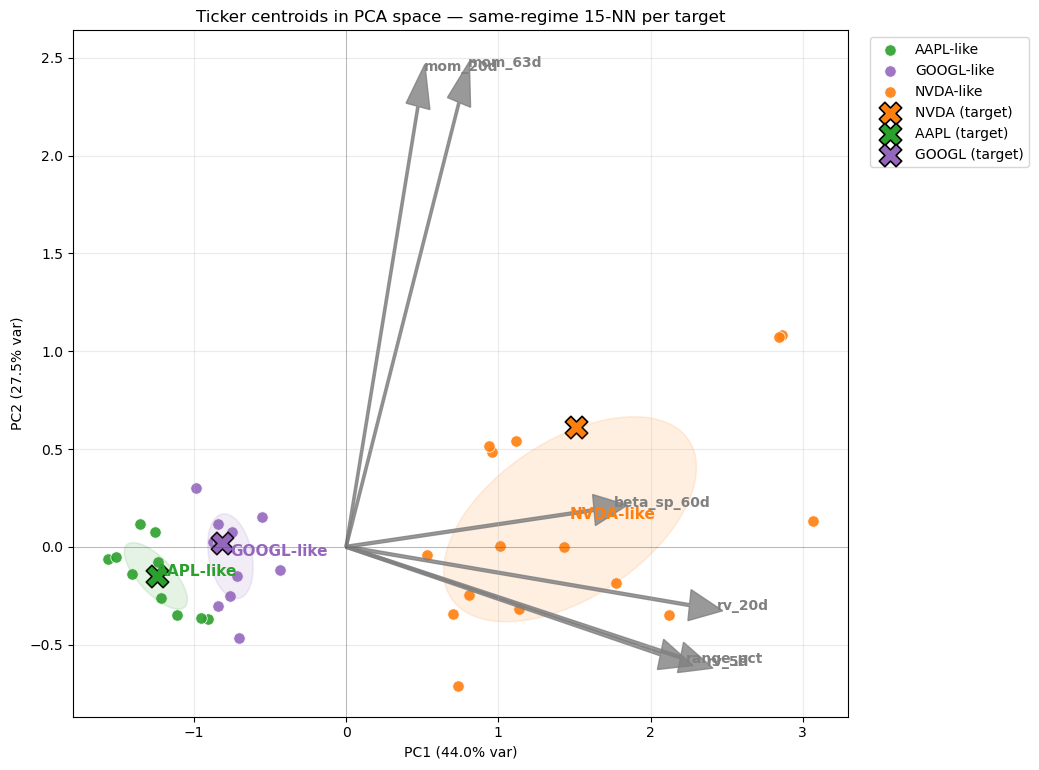

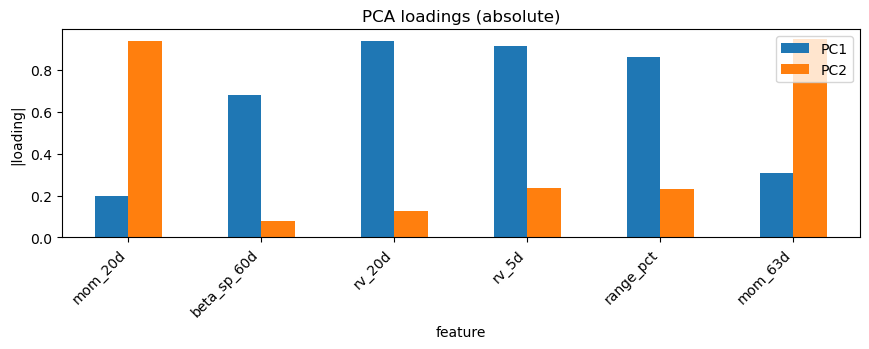

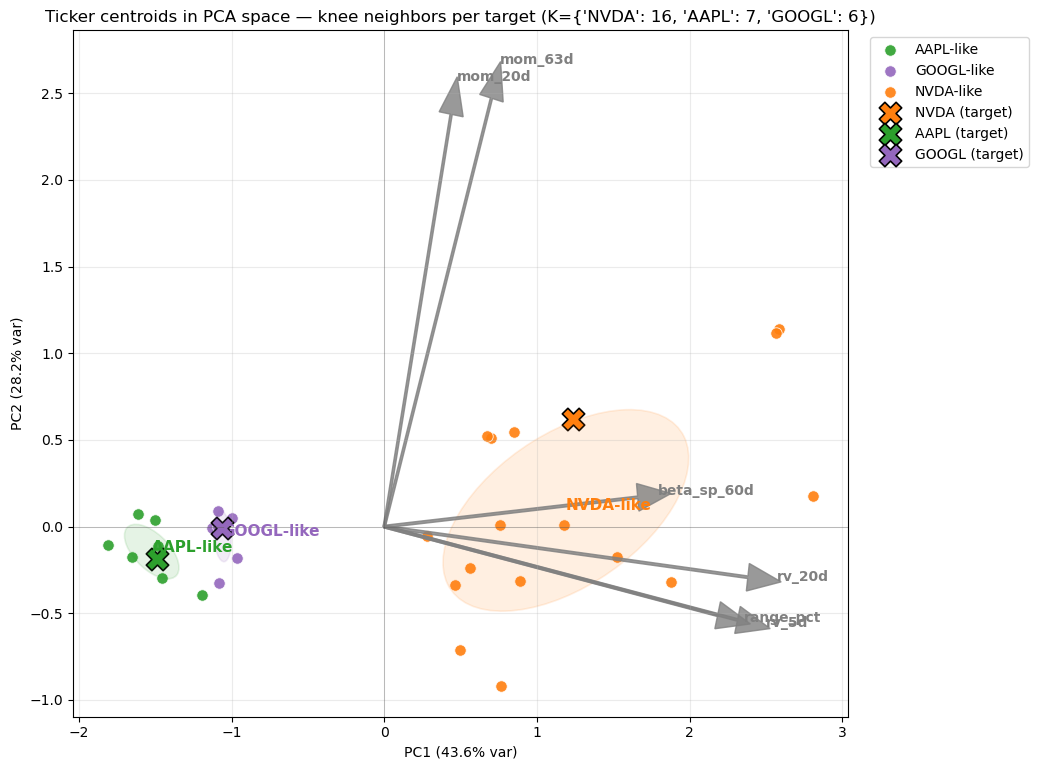

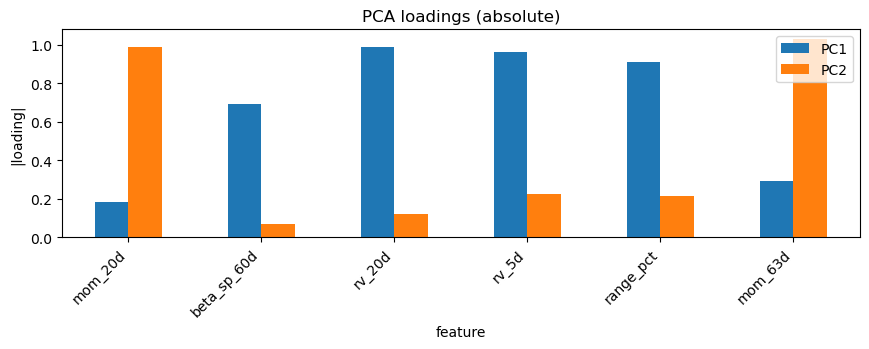

In [137]:
# === Look-alike biplots (fixed 15-NN and knee neighbors) — ALIGNED WITH ORIGINAL METHOD ===
# ---------------------------------------------------------------------
# Config (same features & anchors)
# ---------------------------------------------------------------------
features_final = ['mom_20d','beta_sp_60d','rv_20d','rv_5d','range_pct','mom_63d']
targets = ['NVDA','AAPL','GOOGL']
need = {'ticker','date','cluster_new', *features_final}
assert need.issubset(set(work_final.columns)), "Missing required columns in work_final."

# ---------------------------------------------------------------------
# Daily z-scoring across the FULL panel (your original standardization)
# ---------------------------------------------------------------------
df = work_final[['ticker','date','cluster_new'] + features_final].dropna().copy()
Z = StandardScaler().fit_transform(df[features_final].astype('float32'))
zcols = [f"z_{c}" for c in features_final]
for i, c in enumerate(features_final):
    df[zcols[i]] = Z[:, i]

# Per-ticker centroids in z-space (NOT per-regime) — this is your original fingerprint
centroids_z = df.groupby('ticker')[zcols].mean()

# Regime exposure & dominant regime per ticker (for candidate filtering only)
counts   = df.groupby(['ticker','cluster_new']).size().unstack(fill_value=0)
exposure = counts.div(counts.sum(axis=1), axis=0)
dom_reg  = exposure.idxmax(axis=1)

# ---------------------------------------------------------------------
# 2) Distance helpers (same as your original logic)
# ---------------------------------------------------------------------
def _dist_series(target, pool, metric='euclidean'):
    V = centroids_z.loc[target].values
    M = centroids_z.loc[pool].values
    if metric == 'euclidean':
        d = np.linalg.norm(M - V, axis=1)
    elif metric == 'cosine':
        vnorm = np.linalg.norm(V); norms = np.linalg.norm(M, axis=1)
        d = 1 - (M @ V) / (norms * vnorm + 1e-12)
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'")
    return pd.Series(d, index=pool).sort_values()

# Knee (max distance-to-chord) — reuse your earlier definition if present
try:
    knee_index_chord  # noqa
except NameError:
    def knee_index_chord(dist_sorted, min_k=5, max_k=20):
        n = len(dist_sorted)
        if n < min_k+1: return max(1, n)
        x = np.arange(n)
        p1, p2 = np.array([x[0], dist_sorted[0]]), np.array([x[-1], dist_sorted[-1]])
        v = p2 - p1; L = np.hypot(*v)
        if L == 0: return min_k
        pts = np.column_stack([x, dist_sorted]) - p1
        cross = np.abs(pts[:,0]*v[1] - pts[:,1]*v[0]) / L
        lo, hi = min_k-1, min(max_k, n-1)-1
        return int(cross[lo:hi+1].argmax() + lo + 1)

# ---------------------------------------------------------------------
# 3) Neighbor discovery — SAME-REGIME FILTER, PER-TICKER CENTROIDS
# ---------------------------------------------------------------------
def neighbors_fixed_same_regime(target, top_n=15, metric='euclidean'):
    assert target in centroids_z.index, f"{target} not found."
    tgt_reg = dom_reg.loc[target]
    pool = dom_reg[dom_reg == tgt_reg].index.tolist()
    pool = [t for t in pool if t != target]
    ser = _dist_series(target, pool, metric=metric)
    return ser.head(top_n)

def neighbors_knee_same_regime(target, min_k=5, max_k=20, metric='euclidean', K_override=None):
    assert target in centroids_z.index, f"{target} not found."
    tgt_reg = dom_reg.loc[target]
    pool = dom_reg[dom_reg == tgt_reg].index.tolist()
    pool = [t for t in pool if t != target]
    ser = _dist_series(target, pool, metric=metric)
    if K_override is None:
        K = knee_index_chord(ser.values, min_k=min_k, max_k=max_k)
    else:
        K = int(K_override)
    return ser.head(K), K

# Build neighbor sets
neighbors_fixed = {t: neighbors_fixed_same_regime(t, top_n=15) for t in targets}

# Reuse the *existing* K’s you computed earlier (AAPL/NVDA/GOOGL) when available
K_by_target = {}
neighbors_knee = {}
for t in targets:
    k_pre = None
    if t == 'AAPL'  and 'K_aapl'  in globals():  k_pre = K_aapl
    if t == 'NVDA'  and 'K_nvda'  in globals():  k_pre = K_nvda
    if t == 'GOOGL' and 'K_googl' in globals():  k_pre = K_googl
    serK, K = neighbors_knee_same_regime(t, min_k=5, max_k=20, K_override=k_pre)
    neighbors_knee[t] = serK
    K_by_target[t] = K

# ---------------------------------------------------------------------
# 4) PCA biplot — fit on DAILY z-rows of the selected names; plot PER-TICKER centroids
# ---------------------------------------------------------------------
def closest_target_label(tkr):
    """Assign to the nearest target in centroid space (same as your distance logic)."""
    best, bestd = None, np.inf
    for tgt in targets:
        d = np.linalg.norm(centroids_z.loc[tkr].values - centroids_z.loc[tgt].values)
        if d < bestd:
            best, bestd = tgt, d
    return best

def pca_biplot(neighbor_dict, title_suffix):
    # union of targets + selected neighbors
    selected = set(targets)
    for _, ser in neighbor_dict.items():
        selected.update(list(ser.index))
    selected = sorted(selected)

    # PCA on DAILY z-rows of the selected names (keeps axes comparable)
    X_daily = df[df['ticker'].isin(selected)][zcols].values
    pca = PCA(n_components=2, random_state=42).fit(X_daily)

    # Coordinates for plotting = per-ticker centroid projected to PC space
    PC = pca.transform(centroids_z.loc[selected].values)
    plot = pd.DataFrame({'ticker': selected, 'PC1': PC[:,0], 'PC2': PC[:,1]})
    plot['cohort'] = [closest_target_label(t) for t in plot['ticker']]

    # Draw
    plt.figure(figsize=(10.5, 7.8))
    ax = plt.gca()
    palette = {'NVDA':'tab:orange','AAPL':'tab:green','GOOGL':'tab:purple'}

    for grp, sub in plot.groupby('cohort'):
        ax.scatter(sub.PC1, sub.PC2, s=68, alpha=0.9,
                   c=palette.get(grp, 'tab:blue'), edgecolor='white', linewidth=0.6,
                   label=(f"{grp}-like" if grp in palette else "Unassigned"))

    # Mark targets
    for t in targets:
        r = plot.loc[plot['ticker']==t].iloc[0]
        ax.scatter(r.PC1, r.PC2, marker='X', s=260, c=palette[t],
                   edgecolor='black', linewidth=1.2, label=f"{t} (target)")

    # Cohort ellipses (visual grouping only)
    def cov_ellipse(ax, X, Y, label, color):
        if len(X) < 2: return
        P = np.column_stack([X,Y])
        C = np.cov(P.T); w,v = np.linalg.eigh(C); o = w.argsort()[::-1]; w,v = w[o], v[:,o]
        ang = np.degrees(np.arctan2(v[1,0], v[0,0]))
        ell = Ellipse((X.mean(), Y.mean()),
                      2*np.sqrt(max(w[0],1e-9)), 2*np.sqrt(max(w[1],1e-9)),
                      angle=ang, fc=color, ec=color, alpha=0.12, lw=1.2)
        ax.add_patch(ell); ax.text(X.mean(), Y.mean(), f"{label}-like", color=color, fontsize=11, weight='bold')

    for grp, sub in plot.groupby('cohort'):
        if grp in palette:
            cov_ellipse(ax, sub.PC1.values, sub.PC2.values, grp, palette[grp])

    # Loading arrows (original z-features)
    load = pca.components_.T * np.sqrt(pca.explained_variance_)
    scale = 2.4
    for i, f in enumerate(zcols):
        x, y = load[i,0]*scale, load[i,1]*scale
        ax.arrow(0,0,x,y, width=0.015, head_width=0.16, head_length=0.22,
                 fc='gray', ec='gray', alpha=0.8)
        ax.text(x*1.08, y*1.08, f.replace('z_',''), color='gray', fontsize=10, weight='bold')

    ax.axhline(0, color='k', lw=0.5, alpha=0.3); ax.axvline(0, color='k', lw=0.5, alpha=0.3)
    ax.set_title(f"Ticker centroids in PCA space — {title_suffix}")
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    ax.grid(alpha=0.25); ax.legend(bbox_to_anchor=(1.02,1), loc='upper left', frameon=True)
    plt.tight_layout(); plt.show()

    # Loadings bar chart (absolute values)
    L = pd.DataFrame(load, index=zcols, columns=['PC1','PC2']).rename(index=lambda s: s.replace('z_',''))
    plt.figure(figsize=(8.8, 3.6))
    (L.abs()).plot(kind='bar', ax=plt.gca())
    plt.title("PCA loadings (absolute)"); plt.ylabel("|loading|"); plt.xlabel("feature")
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------
# 5) Plot (fixed 15-NN and knee neighbors using your K’s)
# ---------------------------------------------------------------------
pca_biplot(neighbors_fixed, "same-regime 15-NN per target")
pca_biplot(neighbors_knee,  f"knee neighbors per target (K={K_by_target})")


### **Readings into the PCA figures**

**PC1 and PC2** are computed from the daily standardized feature matrix for the selected tickers and together explain ≈72% of its variance; points are per-ticker centroids projected into this PC space.
> **PC1** (horizontal) is composed of mainly “Risk/Range/Beta” features - large absolute loadings for rv_5d, rv_20d, range_pct, beta_sp_60d. → Right = higher volatility, wider intraday ranges, higher beta; Left = calmer, lower beta & ranges.
> **PC2** (vertical) represents “Momentum/Trend” indicators: large absolute loadings for mom_20d, mom_63d.→ Up = stronger recent momentum; Down = weaker/negative momentum.

**Arrows (loadings)**: *direction* = the way the component increases in feature space; length ≈ the feature’s contribution to that PC (longer = more influence). *Points* in the direction of an arrow have above-average values for that feature; points opposite the arrow are below-average. *Angles* between arrows express correlation on the selected set: small angle ≈ positive correlation; ~180° ≈ negative; ~90° ≈ weak.
Arrows (feature loadings) – quick rules

> In the plots the momentum arrows point mostly up, while risk/beta arrows are more horizontal → momentum is largely independent of risk in this projection.

**Points and ellipses**: Each point = a ticker centroid (mean of its daily z-scores). Distance on the chart ≈ similarity in the 2D projection (true ranking uses all 6D distances; the plot is an approximation).

> Near the origin ≈ close to “average” across features; farther out ≈ more extreme on whatever arrows point that way.

Panel 1: same-regime fixed 15-NN - a like-for-like comparison across targets with the same neighbor count.

Panel 2: same-regime knee-NN (adaptive K) - use a data-driven cohort size matching the knee of the distance curve.


**AAPL**: *Apple’s behavior is consistently low-beta/low-vol; only a handful of names match it this closely.*
* Location: bottom-left quadrant (negative PC1, near-zero PC2).
* Read: low risk/low range/near-market momentum → calm “compounder/defensive” profile.
* Cohort shape: tight cluster with small ellipse and short inter-point distances.
* Knee: K=7 supports a crisp peer set—after ~7, distances jump.

**GOOGL**: *Google’s peers share a balanced risk profile—a small, clean cohort emerges before similarity drops off.*
* Location: left of center, slightly above/below PC2 ≈ 0.
** Read: moderate risk and balanced momentum—steadier than NVDA, a bit looser than AAPL.
* Cohort shape: compact but a touch more dispersed than AAPL, reflecting a balanced growth profile.
* Knee: K=6, another tight cohort.

**NVDA**: *NVIDIA’s nearest neighbors are numerous and risk-heavy; the cohort is broader and more heterogeneous than AAPL/GOOGL.*
* Location: right side (positive PC1), moderate PC2, with points spreading to the right.
* Read: high beta, high volatility, wider ranges; momentum varies across peers.
* Cohort shape: widest ellipse and largest dispersion → many “risk-on” names resemble NVDA to a point, but divergence grows.
* Knee: K=16 → broader set of comparably “extreme” names before the curve bends.


**KEY TAKEAWAY**
The figures show clear separation between a low-risk stratum (AAPL/GOOGL cohorts on the left) and a high-risk stratum (NVDA cohort on the right), matching domain intuition.
**With regime-consistent nearest-neighbor cohorts identified, predictive models can be trained on each target’s peer set so the model learns patterns specific to the target’s behavioral profile rather than the market at large**

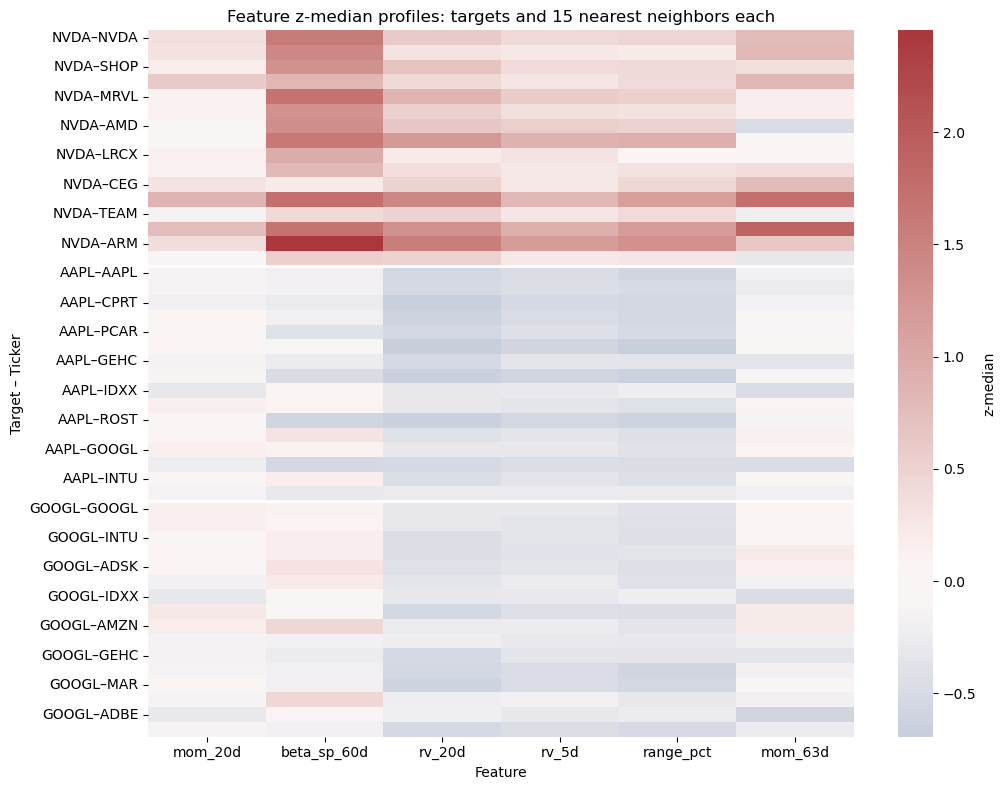

In [131]:
# last plot: heatmap
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# =========================
# Config (updated features)
# =========================
features_final = ['mom_20d','beta_sp_60d','rv_20d','rv_5d','range_pct','mom_63d']
targets = ['NVDA','AAPL','GOOGL']
N = 15                    # neighbors per target (fixed-N view)
use_knee = False          # set True to reuse K_aapl/K_nvda/K_googl if defined

# =========================
# Build daily z-features
# =========================
need = {'ticker','cluster_new', *features_final}
assert need.issubset(set(work_final.columns)), "Missing required columns in work_final."

df = work_final[['ticker','cluster_new'] + features_final].dropna().copy()

# z-score at DAILY level (full panel), columns keep original names (values are z)
Z = StandardScaler().fit_transform(df[features_final].astype('float32'))
zdf = pd.DataFrame(Z, columns=features_final)
zdf['ticker'] = df['ticker'].values
zdf['cluster_new'] = df['cluster_new'].values

# per-ticker z-median (for heatmap) and z-mean (for NN distances = centroids)
zmed = zdf.groupby('ticker')[features_final].median()
centroids_z = zdf.groupby('ticker')[features_final].mean()

# regime exposure & dominant regime per ticker (for same-regime candidate pool)
counts = zdf.groupby(['ticker','cluster_new']).size().unstack(fill_value=0)
exposure = counts.div(counts.sum(axis=1), axis=0)
dom_reg = exposure.idxmax(axis=1)

# helper: choose K from knee dict if requested and available
def knee_for(t):
    if not use_knee: 
        return N
    if (t == 'AAPL')  and ('K_aapl'  in globals()):  return int(K_aapl)
    if (t == 'NVDA')  and ('K_nvda'  in globals()):  return int(K_nvda)
    if (t == 'GOOGL') and ('K_googl' in globals()):  return int(K_googl)
    return N

# =========================
# Build blocks per target
# =========================
blocks, block_sizes = [], []
for t in targets:
    if t not in centroids_z.index: 
        continue

    # same-regime candidate pool (exclude the target itself)
    tgt_reg = dom_reg.loc[t]
    pool = dom_reg[dom_reg == tgt_reg].index.tolist()
    pool = [x for x in pool if x != t]

    # Euclidean distance in centroid z-space (aligned with methodology)
    v = centroids_z.loc[t].values
    M = centroids_z.loc[pool].values
    d = np.linalg.norm(M - v, axis=1)
    order = np.argsort(d)
    ranked = [pool[i] for i in order]

    k = min(knee_for(t), len(ranked))
    nn = ranked[:k]

    # assemble block: [target] + neighbors (z-median features)
    tickers_block = [t] + nn
    block = zmed.loc[tickers_block].copy()
    block.insert(0, 'group', t)
    blocks.append(block)
    block_sizes.append(len(tickers_block))

# concat and make nice row labels "TARGET–TICKER"
Zblocks = pd.concat(blocks, axis=0)
row_labels = [f"{g}–{idx}" for g, idx in zip(Zblocks['group'], Zblocks.index)]
Zblocks.index = row_labels
Zblocks = Zblocks.drop(columns='group')

# =========================
# Draw heatmap
# =========================
plt.figure(figsize=(10.5, 8))
ax = sns.heatmap(Zblocks, center=0, cmap="vlag", cbar_kws={'label':'z-median'})
title_suffix = "knee neighbors" if use_knee else f"{N} nearest neighbors each"
plt.title(f"Feature z-median profiles: targets and {title_suffix}")
plt.xlabel("Feature"); plt.ylabel("Target – Ticker")

# separators between target blocks
row_breaks = np.cumsum(block_sizes)[:-1]
for rb in row_breaks:
    ax.hlines(rb, *ax.get_xlim(), colors='white', lw=2)

plt.tight_layout(); plt.show()


What the z-scores are: **Daily standardization:** For each feature every daily observation was z-scored across the full panel:
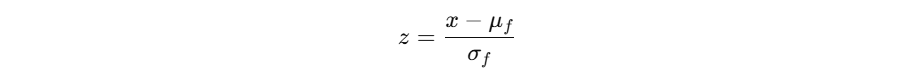
where 𝜇𝑓 and μf are the overall mean and standard deviation of feature 𝑓 across all tickers and days in the sample.

**Per-ticker profile**: For each ticker, the z-median is taken per feature (median of its daily z’s). Each cell in the heatmap = “how many standard deviations this ticker’s typical value sits above/below the panel mean” for that feature.

**Neighbor selection**: Neighbors are chosen in 6-D z-centroid space (mean of daily z’s), same-regime pool only, using Euclidean distance; the heatmap then shows per-ticker z-medians (robust, readable values).

How to read the colors:
* White (≈0): close to panel average.
* Red (>!0): above average in SD units; deeper red = more extreme.
* Blue (<!0): below average; deeper blue = more defensive/low relative level.

Columns align with features; rows are grouped by target with its 15 nearest neighbors underneath.

Key insights:
**NVDA block** (top)
> Beta (beta_sp_60d): consistent deep red → NVDA and its peers are high-beta.
> Volatility / range (rv_20d, rv_5d, range_pct): mostly light-to-medium red → above-average realized volatility and intraday ranges.
> Momentum: several names show strong mom_63d (and some mom_20d) in red (e.g., ARM, TEAM) → a risk-on cohort with sustained recent trend in many constituents.
**Takeaway: NVDA’s neighbors are coherently risk-heavy; momentum is frequently elevated, but not uniformly so across all peers** (heterogeneous momentum inside a uniformly high-beta/range group).

**AAPL block** (middle)
> Volatility / range: broad blue across rv_20d, rv_5d, range_pct → below-average realized volatility and tighter ranges.
> Beta: generally blue → low-beta tilt.
> Momentum: near-white to faint tones → near-market momentum, not a momentum-driven story.
**Takeaway: AAPL’s cohort is a tight, defensive profile—low beta, low vol, narrow ranges—with very consistent blues across the risk columns.**

**GOOGL block** (bottom)
> Volatility / range: mostly light blue → below-average risk, though less defensive than AAPL.
> Beta: light blue to near-white → moderately low to neutral beta.
> Momentum: mixed but often slightly positive (light red in mom_63d for some names) → balanced growth rather than pure defensives.
**Takeaway: GOOGL’s peers sit between AAPL and NVDA: calmer than the market on risk, with modest positive momentum in parts of the cohort.**

*Within-block coherence:*

* NVDA block = red risk signature (high beta/vol/range) → explains the larger knee 𝐾=16 seen in the PCA view: many names share this “risk-on” profile. *NVDA peers are uniformly risk-on (high beta/volatility), with several showing strong recent momentum.*

* AAPL block = blue risk signature (defensive, tight ranges) → compact cohort, aligns with small knee 𝐾=7. *AAPL peers are consistently defensive—low beta and tight ranges—hence a compact, high-fidelity cohort.*

* GOOGL block = light blue risk with mild momentum → small-to-moderate cohort 𝐾=6, balanced profile. *GOOGL peers are calmer-than-market with pockets of positive momentum, sitting between AAPL-defensives and NVDA-risk*

*Target alignment:* Each target row (NVDA–NVDA, AAPL–AAPL, GOOGL–GOOGL) is representative of its block’s color pattern—good validation that the nearest-neighbor logic is pulling genuinely similar names.

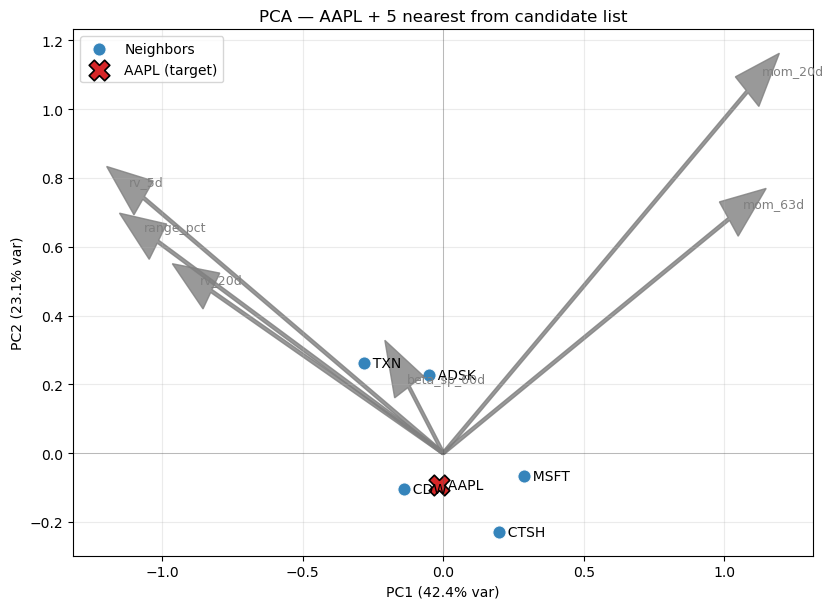

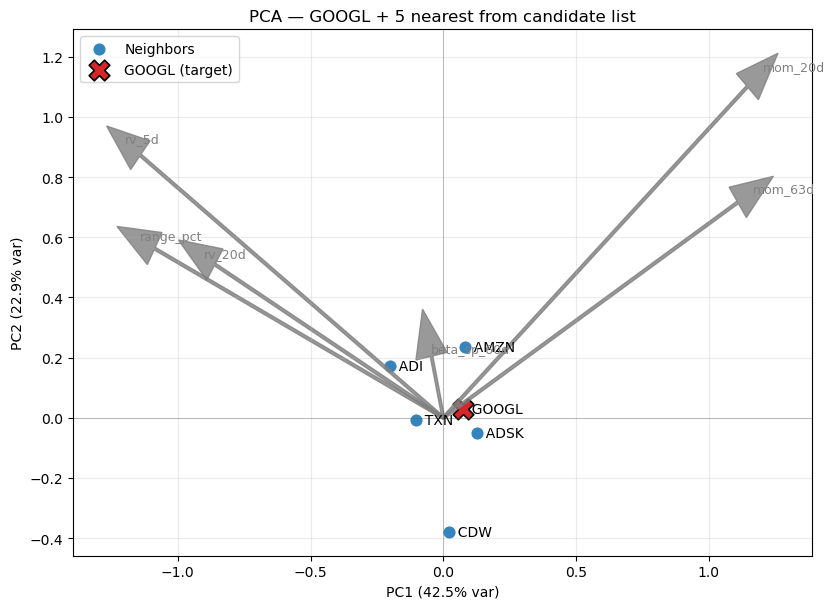

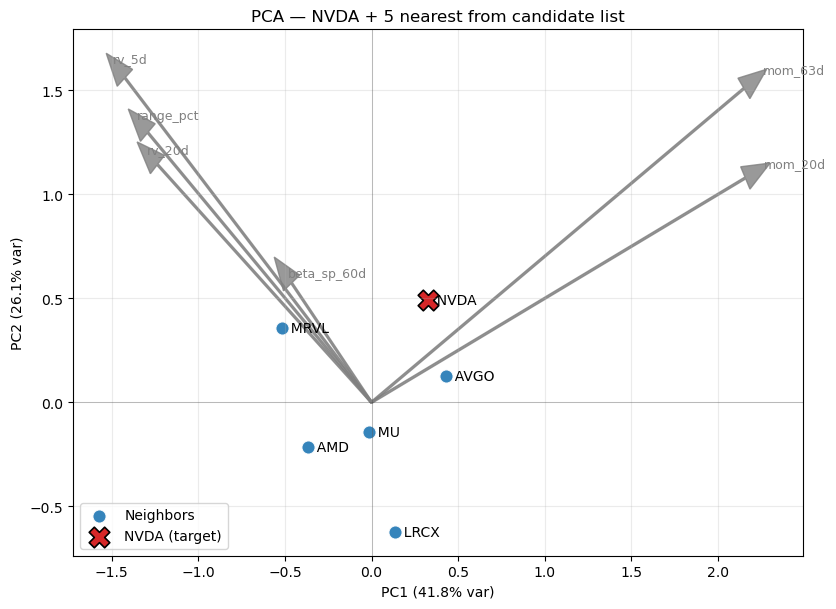

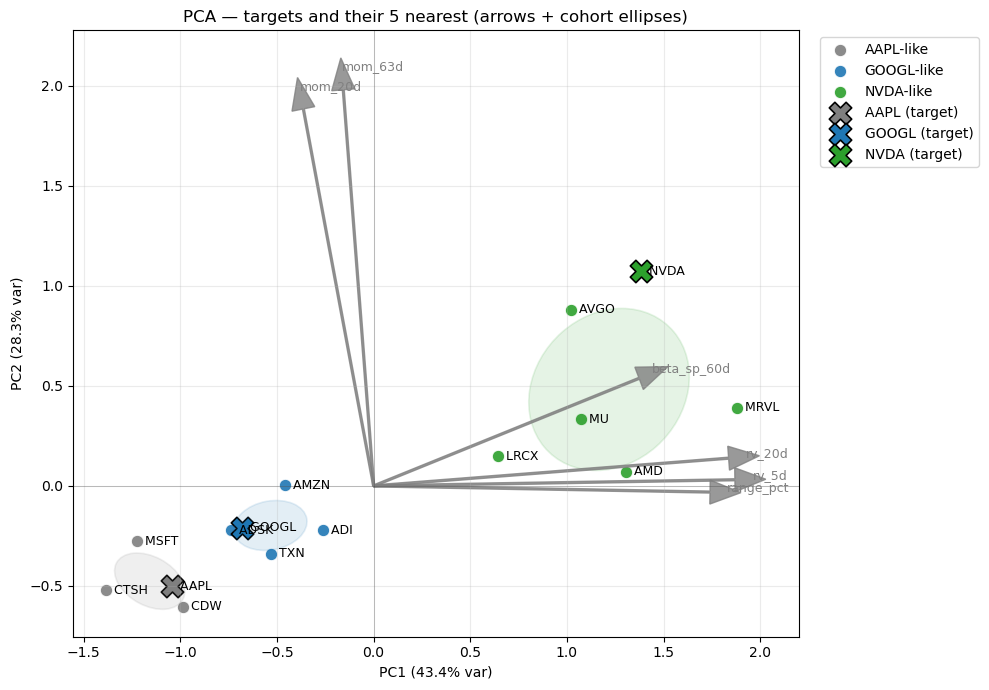

In [142]:
# Visualization of the 5 closest IT companies:
# === Nearest-5 PCA plots from a fixed candidate list ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -------------------------------------------------------
# 0) CONFIG
# -------------------------------------------------------
features_final = ['mom_20d','beta_sp_60d','rv_20d','rv_5d','range_pct','mom_63d']
targets = ['AAPL','GOOGL','NVDA']   # your three targets

# Your 15 “made it” tickers (candidates for neighbors)
keepers = [
    'CDW','MSFT','CTSH','ADSK','GOOGL','ADSK','TXN','AMZN','AAPL',
    'ADI','AVGO','MRVL','MU','AMD','LRCX'
]
keepers = [t for t in pd.unique(keepers) if t not in targets]  # dedupe & drop targets if present

# Basic checks
need = {'ticker','date', *features_final}
missing = need - set(work_final.columns)
assert not missing, f"Missing columns in work_final: {missing}"

# -------------------------------------------------------
# 1) Z-score across FULL panel (keeps distances comparable)
# -------------------------------------------------------
df = work_final[['ticker','date'] + features_final].dropna().copy()
Z = StandardScaler().fit_transform(df[features_final].astype('float32'))
zcols = [f"z_{c}" for c in features_final]
for i, c in enumerate(features_final):
    df[zcols[i]] = Z[:, i]

# Per-ticker centroid in z-space (behavioral “fingerprint”)
centroids_z = df.groupby('ticker')[zcols].mean()

# Utility: Euclidean distance from a target centroid to a pool
def _rank_neighbors_from_pool(target: str, pool: list[str], k: int = 5):
    assert target in centroids_z.index, f"{target} not found in centroids."
    pool = [p for p in pool if p in centroids_z.index and p != target]
    V = centroids_z.loc[target].values
    M = centroids_z.loc[pool].values
    d = np.linalg.norm(M - V, axis=1)
    ser = pd.Series(d, index=pool).sort_values()
    return ser.head(k)

# Build top-5 neighbor lists for EACH target, restricted to your 15-name pool
nn_by_target = {t: _rank_neighbors_from_pool(t, keepers, k=5) for t in targets}

# -------------------------------------------------------
# 2) PCA helper — fit on DAILY z-rows of only target+neighbors; plot CENTROIDS
# -------------------------------------------------------
def pca_plot_target_and_neighbors(target: str, nn_series: pd.Series):
    tickers_plot = [target] + list(nn_series.index)

    # Fit PCA on DAILY rows of just these tickers (axes tailored to the cohort)
    sub_daily = df[df['ticker'].isin(tickers_plot)][zcols].values
    pca = PCA(n_components=2, random_state=42).fit(sub_daily)

    # Project per-ticker centroids to PC space
    PC = pca.transform(centroids_z.loc[tickers_plot].values)
    plot = pd.DataFrame({'ticker': tickers_plot, 'PC1': PC[:,0], 'PC2': PC[:,1]})

    # Draw
    fig, ax = plt.subplots(figsize=(8.5, 6.2))
    # neighbors
    neigh = plot[plot['ticker'] != target]
    ax.scatter(neigh.PC1, neigh.PC2, s=90, alpha=0.9, c='tab:blue', edgecolor='white', linewidth=0.8, label='Neighbors')

    # target
    tgt = plot[plot['ticker'] == target].iloc[0]
    ax.scatter(tgt.PC1, tgt.PC2, marker='X', s=220, c='tab:red', edgecolor='black', linewidth=1.2, label=f'{target} (target)')

    # labels
    for _, r in plot.iterrows():
        ax.text(r.PC1, r.PC2, '  ' + r.ticker, va='center', fontsize=10)

    # loadings (arrows) for interpretability
    loads = pca.components_.T * np.sqrt(pca.explained_variance_)
    scale = 2.2
    for i, f in enumerate(zcols):
        x, y = loads[i,0]*scale, loads[i,1]*scale
        ax.arrow(0,0,x,y, width=0.01, head_width=0.12, head_length=0.16, fc='gray', ec='gray', alpha=0.8)
        ax.text(x*1.05, y*1.05, f.replace('z_',''), color='gray', fontsize=9)

    ax.axhline(0, color='k', lw=0.5, alpha=0.3); ax.axvline(0, color='k', lw=0.5, alpha=0.3)
    ax.grid(alpha=0.25)
    ax.set_title(f"PCA — {target} + 5 nearest from candidate list")
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    ax.legend(loc='best', frameon=True)
    plt.tight_layout()
    plt.show()

# One figure per target
for t in targets:
    # If a target is missing from the data or has <5 candidates available, this will still plot what’s available.
    pca_plot_target_and_neighbors(t, nn_by_target.get(t, pd.Series(dtype=float)))

# --- Combined plot with arrows + cohort ellipses ---
from matplotlib.patches import Ellipse

combined = set()
for t, s in nn_by_target.items():
    combined.add(t); combined.update(list(s.index))
combined = sorted(combined)

if combined:
    # Fit PCA on DAILY rows of the combined set
    sub_daily = df[df['ticker'].isin(combined)][zcols].values
    pca = PCA(n_components=2, random_state=42).fit(sub_daily)

    # Project centroids to PC space
    PC = pca.transform(centroids_z.loc[combined].values)
    plot = pd.DataFrame({'ticker': combined, 'PC1': PC[:,0], 'PC2': PC[:,1]})

    # Assign each name to the nearest target (in z-centroid space)
    def nearest_target(tkr):
        v = centroids_z.loc[tkr].values
        return min(targets, key=lambda t: np.linalg.norm(centroids_z.loc[t].values - v))
    plot['cohort'] = [t if t in targets else nearest_target(t) for t in plot['ticker']]

    colors = {'AAPL':'tab:grey','GOOGL':'tab:blue','NVDA':'tab:green'}

    fig, ax = plt.subplots(figsize=(10, 7))
    # scatter by cohort
    for coh, sub in plot.groupby('cohort'):
        ax.scatter(sub.PC1, sub.PC2, s=80, alpha=0.9,
                   c=colors[coh], edgecolor='white', linewidth=0.8,
                   label=f'{coh}-like')

    # highlight targets
    for t in targets:
        if t in plot['ticker'].values:
            r = plot.loc[plot['ticker']==t].iloc[0]
            ax.scatter(r.PC1, r.PC2, marker='X', s=260, c=colors[t],
                       edgecolor='black', linewidth=1.2, label=f'{t} (target)')

    # labels
    for _, r in plot.iterrows():
        ax.text(r.PC1, r.PC2, '  ' + r.ticker, va='center', fontsize=9)

    # cohort covariance ellipses
    def cov_ellipse(ax, X, Y, color, label):
        if len(X) < 2: return
        P = np.column_stack([X, Y])
        C = np.cov(P.T)
        w, v = np.linalg.eigh(C); o = w.argsort()[::-1]
        w, v = w[o], v[:, o]
        ang = np.degrees(np.arctan2(v[1,0], v[0,0]))
        ell = Ellipse((X.mean(), Y.mean()),
                      2*np.sqrt(max(w[0],1e-9)), 2*np.sqrt(max(w[1],1e-9)),
                      angle=ang, fc=color, ec=color, alpha=0.12, lw=1.2)
        ax.add_patch(ell)

    for coh, sub in plot.groupby('cohort'):
        cov_ellipse(ax, sub.PC1.values, sub.PC2.values, colors[coh], coh)

    # loadings arrows (feature directions)
    loads = pca.components_.T * np.sqrt(pca.explained_variance_)
    scale = 2.2
    for i, f in enumerate(zcols):
        x, y = loads[i,0]*scale, loads[i,1]*scale
        ax.arrow(0, 0, x, y, width=0.01, head_width=0.12, head_length=0.16,
                 fc='gray', ec='gray', alpha=0.8)
        ax.text(x*1.05, y*1.05, f.replace('z_',''), color='gray', fontsize=9)

    ax.axhline(0, color='k', lw=0.5, alpha=0.3); ax.axvline(0, color='k', lw=0.5, alpha=0.3)
    ax.grid(alpha=0.25)
    ax.set_title("PCA — targets and their 5 nearest (arrows + cohort ellipses)")
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    ax.legend(bbox_to_anchor=(1.02,1), loc='upper left', frameon=True)
    plt.tight_layout(); plt.show()


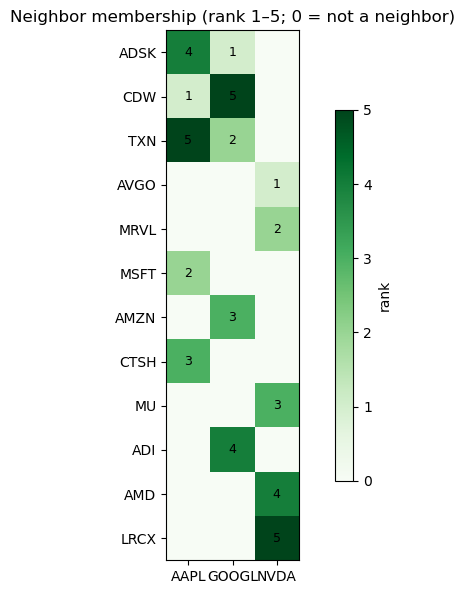

In [143]:
# dict: target -> Series (index=ticker, values=distance) of top-5 neighbors
nn = {t: list(nn_by_target[t].index) for t in targets}
all_names = sorted(set().union(*nn.values()))
rank_mat = np.zeros((len(all_names), len(targets)), dtype=int)

for j, t in enumerate(targets):
    for r, tk in enumerate(nn[t], start=1):
        i = all_names.index(tk)
        rank_mat[i, j] = r  # 1..5

# sort by “how many lists they’re in”, then by min rank
counts = (rank_mat > 0).sum(1)
minrank = np.where(rank_mat==0, 99, rank_mat).min(1)
order = np.lexsort((minrank, -counts))
rank_mat = rank_mat[order]; labels = [all_names[i] for i in order]

fig, ax = plt.subplots(figsize=(7.5, 0.42*len(labels)+1))
im = ax.imshow(rank_mat, cmap="Greens", vmin=0, vmax=5)
ax.set_xticks(range(len(targets))); ax.set_xticklabels(targets)
ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
ax.set_title("Neighbor membership (rank 1–5; 0 = not a neighbor)")
for i in range(rank_mat.shape[0]):
    for j in range(rank_mat.shape[1]):
        v = rank_mat[i, j]
        if v>0: ax.text(j, i, str(v), ha='center', va='center', color='black', fontsize=9)
plt.colorbar(im, ax=ax, shrink=0.7, label='rank'); plt.tight_layout(); plt.show()


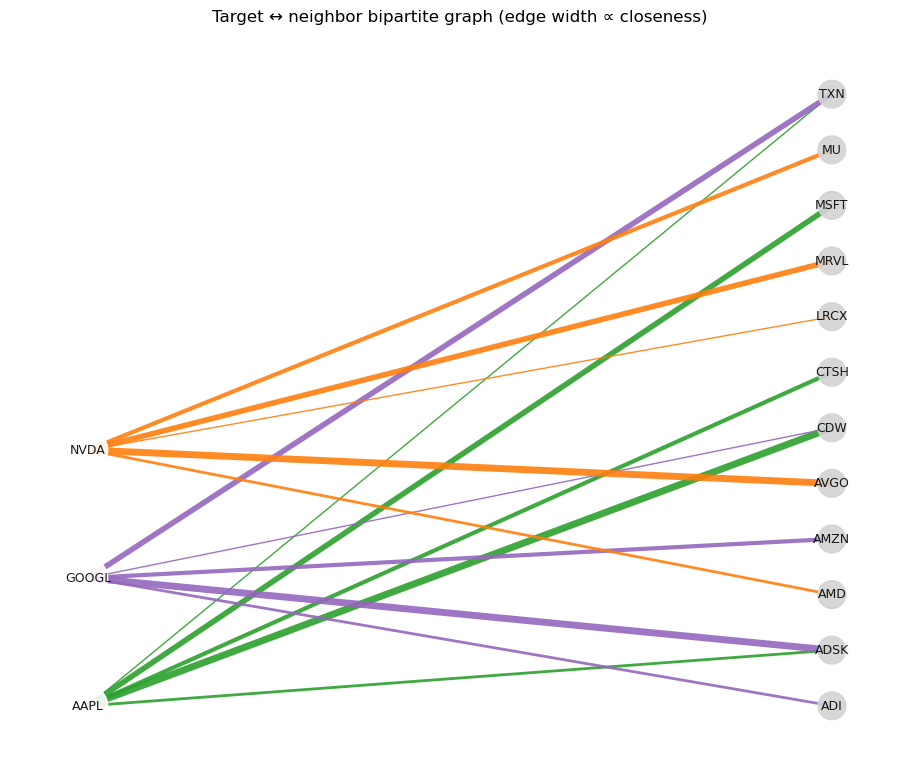

In [144]:
# Bipartite Graph
G = nx.Graph()
G.add_nodes_from(targets, bipartite=0, kind='target')
G.add_nodes_from(all_names, bipartite=1, kind='neighbor')

for t in targets:
    for r, tk in enumerate(nn[t], start=1):
        G.add_edge(t, tk, weight=6-r)  # thicker edge for closer neighbor

pos = {}
pos.update({t: (-1.0, i) for i, t in enumerate(targets)})     # left column: targets
for k, tk in enumerate(all_names):
    pos[tk] = (0.7, k/2.3)                                     # right column: neighbors

edge_colors = {'AAPL':'tab:green','GOOGL':'tab:purple','NVDA':'tab:orange'}
ec = [edge_colors[[u,v][0] if u in targets else [u,v][1]] for u,v in G.edges()]
ew = [G[u][v]['weight'] for u,v in G.edges()]

plt.figure(figsize=(9, 0.45*len(all_names)+2))
nx.draw(G, pos, with_labels=True, node_size=[800 if n in targets else 400 for n in G.nodes()],
        node_color=['white' if n in targets else 'lightgray' for n in G.nodes()],
        edge_color=ec, width=ew, font_size=9, linewidths=1, alpha=0.9)
plt.title("Target ↔ neighbor bipartite graph (edge width ∝ closeness)")
plt.tight_layout(); plt.show()


In [146]:
# lollipop_distances: Draw per-target “lollipop” charts of neighbor distances, highlighting overlaps—
# points that appear as neighbors for multiple targets (red ring) vs unique neighbors (filled blue).
def lollipop_distances(nn_by_target, targets):
    # union of neighbors for overlap detection
    union_others = {t: set().union(*[set(nn_by_target[s].index)
                                     for s in targets if s != t]) for t in targets}
    for t in targets:
        ser = nn_by_target[t]          # distances (sorted ascending)
        names = ser.index.to_list()
        y = np.arange(len(ser))

        plt.figure(figsize=(6.8, 3.6))
        # stems
        plt.hlines(y, 0, ser.values, color='lightgray', lw=1)

        # mask: also a neighbor of another target?
        overlap = ser.index.isin(union_others[t])

        # non-overlap points (filled blue)
        m = ~overlap
        plt.scatter(ser.values[m], y[m], s=60,
                    facecolors='#1f77b4', edgecolors='#1f77b4')

        # overlap points (red ring, transparent fill)
        m = overlap
        plt.scatter(ser.values[m], y[m], s=60,
                    facecolors='none', edgecolors='#d62728', linewidths=2)

        # labels
        for i, tk in enumerate(names):
            plt.text(ser.values[i]*1.01, y[i], tk, va='center', fontsize=9)

        # top-5 cutoff line
        if len(ser) >= 5:
            plt.axvline(ser.values[4], color='k', ls='--', alpha=0.4)

        plt.gca().invert_yaxis()
        plt.xlabel("Euclidean distance (lower = closer)")
        plt.title(f"{t}: nearest distances (red ring = also neighbor of another target)")
        plt.tight_layout()
        plt.show()


In [147]:
edge_colors_map = {'AAPL':'#2ca02c','GOOGL':'#9467bd','NVDA':'#ff7f0e'}
ec = []
for u, v in G.edges():
    if u in targets:   ec.append(edge_colors_map[u])
    elif v in targets: ec.append(edge_colors_map[v])
    else:              ec.append('#999999')  # fallback

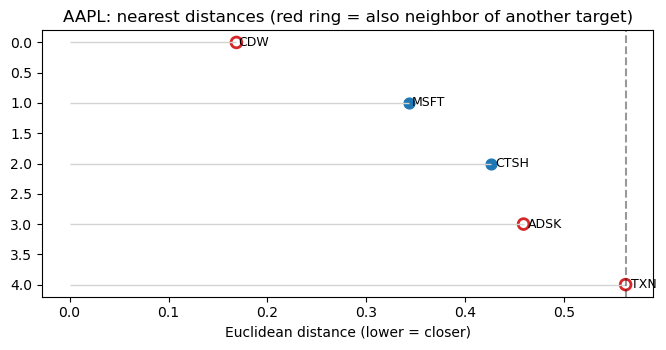

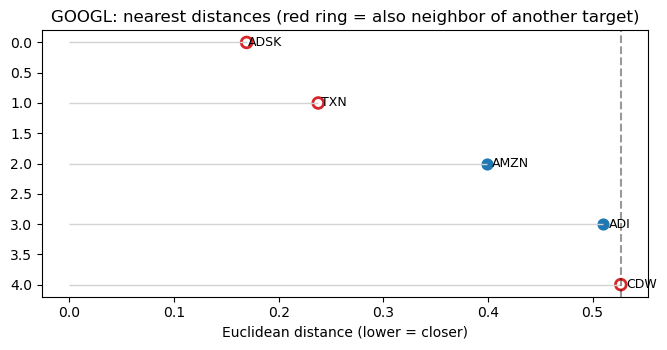

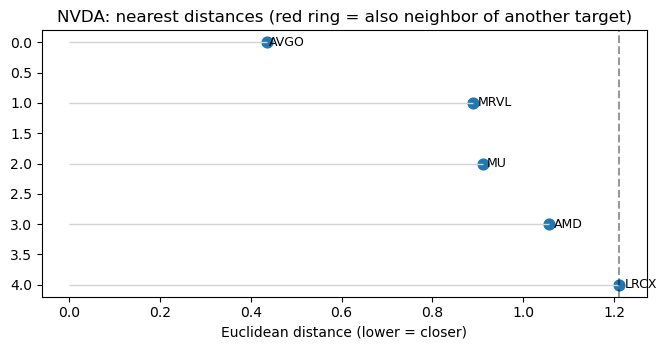

In [148]:
lollipop_distances(nn_by_target, targets)

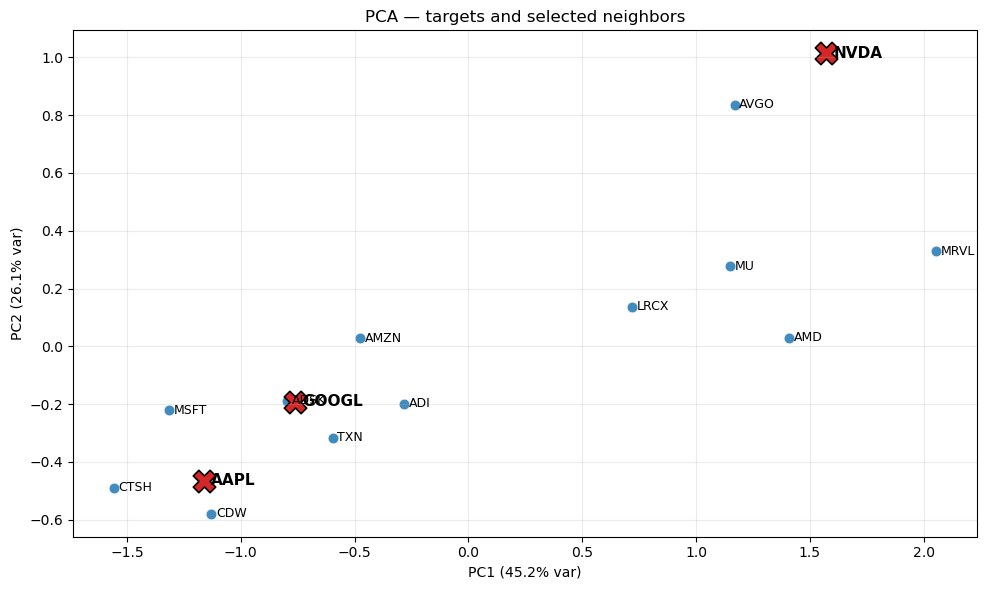

In [153]:
# --- mapping inputs---
features_final = ['mom_20d','beta_sp_60d','rv_20d','rv_5d','range_pct','mom_63d']
targets = ['AAPL','GOOGL','NVDA']
neighbors_all = ['CDW','MSFT','CTSH','ADSK','TXN','AMZN','ADI','AVGO','MRVL','MU','AMD','LRCX']  # your list (no targets here)

# --- build the data (daily rows -> z-score -> per-ticker centroid) ---
sel = sorted(set(targets) | set(neighbors_all))
df = (work_final[['ticker','date'] + features_final]
      .dropna()
      .query('ticker in @sel')
      .copy())

Z = StandardScaler().fit_transform(df[features_final].astype('float32'))
zcols = [f'z_{c}' for c in features_final]
for i,c in enumerate(zcols): df[c] = Z[:, i]

centroids = df.groupby('ticker')[zcols].mean()

# --- PCA fit on daily z-rows, then project centroids ---
pca = PCA(n_components=2, random_state=42).fit(df[zcols].values)
PC = pca.transform(centroids.loc[sel].values)
plot = pd.DataFrame({'ticker': sel, 'PC1': PC[:,0], 'PC2': PC[:,1]})
plot['is_target'] = plot['ticker'].isin(targets)

# --- plot: neighbors = blue dots, targets = big X with distinct colors ---
target_colors = {'AAPL':'#d62728','GOOGL':'#d62728','NVDA':'#d62728'}

fig, ax = plt.subplots(figsize=(10,6))
# neighbors
ne = plot[~plot['is_target']]
ax.scatter(ne.PC1, ne.PC2, s=60, c='tab:blue', alpha=0.85, label='Neighbors', edgecolor='white', linewidth=0.6)
for _, r in ne.iterrows():
    ax.text(r.PC1+0.02, r.PC2, r.ticker, fontsize=9, va='center')

# targets
for t in targets:
    r = plot.loc[plot['ticker']==t].iloc[0]
    ax.scatter(r.PC1, r.PC2, s=260, marker='X',
               c=target_colors[t], edgecolor='black', linewidth=1.2, label=f'{t} (target)')
    ax.text(r.PC1+0.03, r.PC2, t, fontsize=11, weight='bold', va='center')

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
ax.set_title("PCA — targets and selected neighbors")
ax.grid(alpha=0.25)
# ax.legend(loc='upper right', frameon=True)
plt.tight_layout(); plt.show()


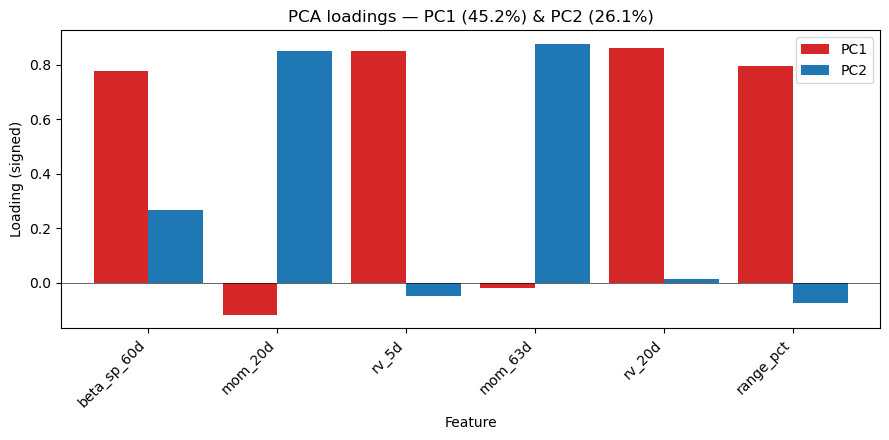

In [156]:
# --- PCA loadings barplot (signed) ---
# loadings = eigenvectors scaled by sqrt(eigenvalues)
load = pca.components_.T * np.sqrt(pca.explained_variance_)

# nice labels (strip any 'z_' prefix)
feat_names = [c.replace('z_', '') for c in zcols]
L = pd.DataFrame(load, index=feat_names, columns=['PC1', 'PC2'])

# (optional) sort features by total contribution
order = L.abs().sum(axis=1).sort_values(ascending=False).index
L = L.loc[order]

# plot
# colors
pc1_color = '#d62728'  # red
pc2_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]  # default blue (#1f77b4)

# plot signed loadings with custom colors
ax = L.plot(kind='bar', figsize=(9, 4.5), width=0.85, color=[pc1_color, pc2_color])
ax.axhline(0, color='k', lw=0.7, alpha=0.6)
ax.set_ylabel('Loading (signed)')
ax.set_xlabel('Feature')
ax.set_title(f'PCA loadings — PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%) & '
             f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### After identifying the nearest neighbors for each target company within its designated cluster, **the selection was further refined by restricting the pool to firms in the technology and communication sectors**. From this filtered set, a fixed group of the five closest peers was retained for each target company:
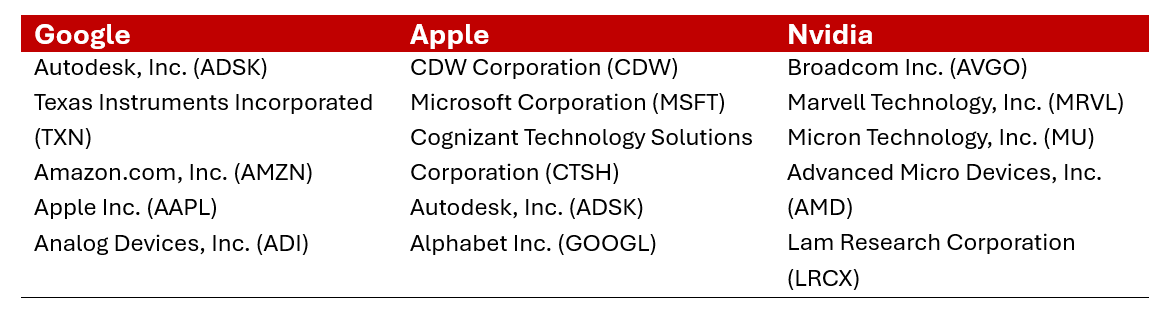

#### Risks & Limitations — Daily-Row Clustering vs. Ticker-Centroid Neighbors
This pipeline clusters daily rows, so the algorithm naturally partitions “day types” (e.g., quiet vs. volatile vs. high-attention sessions). Features that describe the state of the day—such as intraday range, realized volatility, market beta, and volume z-scores—tend to separate observations more strongly than slower-moving position indicators (RSI, Bollinger, MACD). Momentum and position signals become more influential when data are aggregated per ticker (e.g., medians/means across days) or when longer windows are emphasized; that is why the nearest-neighbor “look-alike” step, which uses ticker centroids, often highlights momentum/position more clearly.